In [1]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
data_dir = "../"
include(data_dir*"/src/TempModel.jl")
;

In [8]:
using DataFrames
using Base.Dates

In [3]:
module Batch
    const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
    using ..TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Base.Dates
    using Distributions
    plt.rc("figure", dpi=300.0)
    plt.rc("figure", figsize=(12,8))
    plt.rc("savefig", dpi=300.0)
    plt.rc("text", usetex=false)
    plt.rc("font", family="serif")
    plt.rc("font", serif="Palatino")
    ;
    include("../src/batch_diagnostics.jl")
    include("../src/plot_diagnostics.jl")
end

Batch

In [4]:
# obtain the list of stations
isdList=TempModel.read_isdList(;data_dir=data_dir)
# just the Iowa stations
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF]],:]

# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isdSubset; data_dir=data_dir)
# mark station 3 (Waterloo) as the test station
itest=3
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
# get the USAF code for the test station
test_usaf=isdSubset[itest,:USAF]

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #readtable#233(::Bool, ::Char, ::Array{Char,1}, ::Char, ::Array{String,1}, ::Array{String,1}, ::Array{String,1}, ::Bool, ::Int64, ::Array{Symbol,1}, ::Array{Any,1}, ::Bool, ::Char, ::Bool, ::Int64, ::Array{Int64,1}, ::Bool, ::Symbol, ::Bool, ::Bool, ::DataFrames.#readtable, ::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1050
 [3] readtable(::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/deprecated.jl:1050
 [4] #read_isdList#18(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:31
 [5] (::TempModel.#kw##read_isdList)(::Array{Any,1}, ::TempModel.#read_isdList) at ./<missing>:0
 [6] include_string(::String, ::String) at /Users/imolk/bin/julia_v0.6.2_binary/lib/julia/sys.dylib:?
 [7] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages_experimental/v0.6/Com

725480

In [5]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Getting Tn and Tx

In [9]:
function get_TnTx(temperatures::AbstractVector{Float64}, 
                  ts::AbstractVector{DateTime}, 
                  measure_day::AbstractVector{Date}, 
                  unique_days::AbstractVector{Date})
    ndays = length(unique_days)
    Tn_vec = Vector{Float64}(ndays)
    Tx_vec = Vector{Float64}(ndays)
    buffer_vec = Vector{Base.Dates.TimePeriod}(ndays)
    for (i,day) in enumerate(unique_days)
        # brute force:
        iday = measure_day .== day
        ts_day = ts[iday]
        buffer_start = minimum(ts_day) - minimum(ts)
        buffer_end = maximum(ts) - maximum(ts_day)
        buffer = min(buffer_start, buffer_end)
        day_temps = temperatures[iday]
        Tn_vec[i] = minimum(day_temps)
        Tx_vec[i] = maximum(day_temps)
        buffer_vec[i] = buffer
    end
    TnTx_df = DataFrames.DataFrame(
        day = unique_days,
        Tn = Tn_vec,
        Tx = Tx_vec,
        buffer = buffer_vec
        )
    return TnTx_df
end

get_TnTx (generic function with 1 method)

In [10]:
function get_TnTx(temperatures::AbstractVector{Float64}, 
                  ts::AbstractVector{DateTime}, 
                  hr_measure::Hour)
    measure_day = [TempModel.measurement_date(t, hr_measure) for t in ts]
    unique_days = sort(unique(measure_day))
    return get_TnTx(temperatures, ts, measure_day, unique_days)
end

get_TnTx (generic function with 2 methods)

In [11]:
hours = Hour(0):Hour(1):Hour(23)

0 hours:1 hour:23 hours

In [12]:
TnTx_0 = get_TnTx(hourly_test[:temp],
              hourly_test[:ts],
              Hour(0))
;

In [16]:
TnTx_23 = get_TnTx(hourly_test[:temp],
              hourly_test[:ts],
              Hour(23))
;

In [15]:
TnTx_24 = get_TnTx(hourly_test[:temp],
              hourly_test[:ts],
              Hour(24))
;

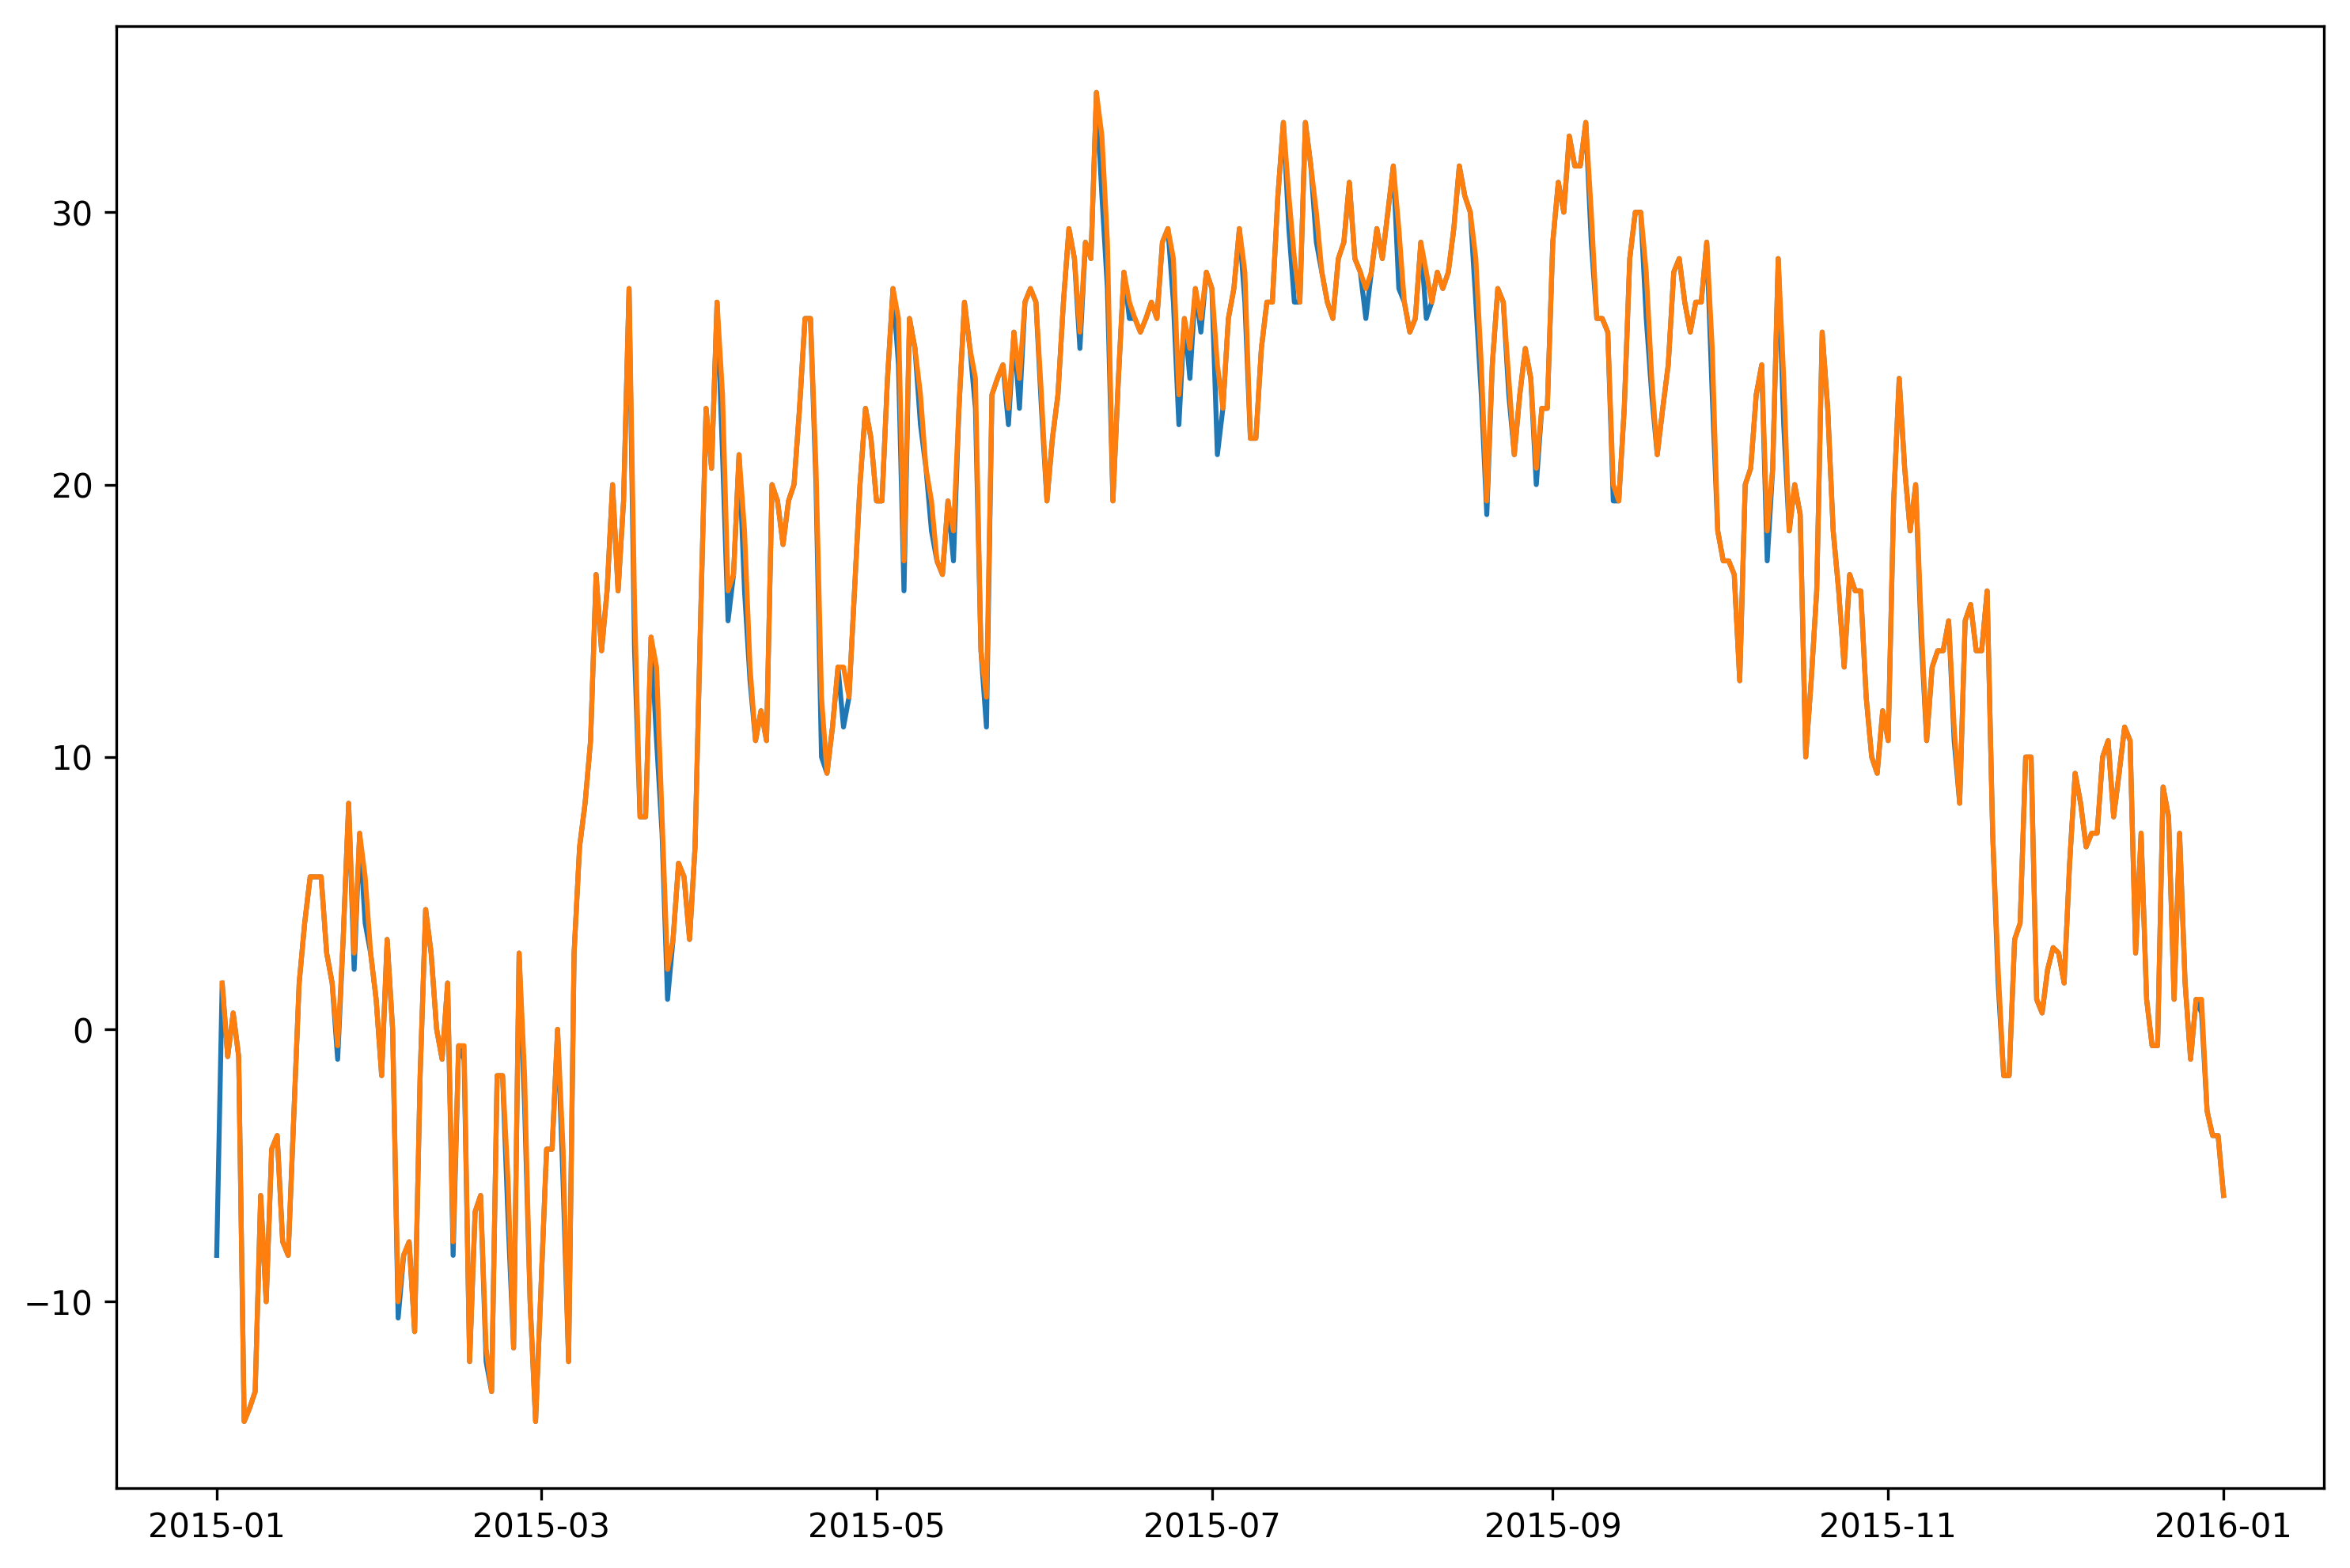

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1377adf60>

In [19]:
plt.plot(TnTx_0[:day], TnTx_0[:Tx])
plt.plot(TnTx_24[:day]+Day(1), TnTx_24[:Tx])
# plt.xlim(Date(2015,4,20), Date(2015,5,3))

In [20]:
DataFrames.tail(get_TnTx(hourly_test[:temp],
              hourly_test[:ts],
              Hour(0)))

6×4 DataFrames.DataFrame
│ Row │ day        │ Tn    │ Tx   │ buffer                 │
├─────┼────────────┼───────┼──────┼────────────────────────┤
│ 1   │ 2015-12-27 │ -1.1  │ 1.1  │ 431640000 milliseconds │
│ 2   │ 2015-12-28 │ -5.0  │ 0.6  │ 345240000 milliseconds │
│ 3   │ 2015-12-29 │ -6.1  │ -3.0 │ 258840000 milliseconds │
│ 4   │ 2015-12-30 │ -6.0  │ -3.9 │ 172440000 milliseconds │
│ 5   │ 2015-12-31 │ -6.1  │ -3.9 │ 86040000 milliseconds  │
│ 6   │ 2016-01-01 │ -10.0 │ -6.1 │ 0 milliseconds         │

In [22]:
DataFrames.tail(get_TnTx(hourly_test[:temp],
              hourly_test[:ts],
              Hour(24)))

6×4 DataFrames.DataFrame
│ Row │ day        │ Tn    │ Tx   │ buffer                 │
├─────┼────────────┼───────┼──────┼────────────────────────┤
│ 1   │ 2015-12-26 │ -1.1  │ 1.1  │ 432000000 milliseconds │
│ 2   │ 2015-12-27 │ -5.0  │ 1.1  │ 345600000 milliseconds │
│ 3   │ 2015-12-28 │ -6.1  │ -3.0 │ 259200000 milliseconds │
│ 4   │ 2015-12-29 │ -6.0  │ -3.9 │ 172800000 milliseconds │
│ 5   │ 2015-12-30 │ -6.1  │ -3.9 │ 86400000 milliseconds  │
│ 6   │ 2015-12-31 │ -10.0 │ -6.1 │ 0 milliseconds         │

In [23]:
ts = hourly_test[:ts]
ts[1]

2015-01-01T00:00:00

In [31]:
TempModel.measurement_date.(ts[2], Hour(0))

2015-01-02

In [33]:
ts[(TempModel.measurement_date.(ts, Hour(0)) .- Day(1)) .!= TempModel.measurement_date.(ts, Hour(24))]

363-element Array{DateTime,1}:
 2015-01-01T00:00:00
 2015-01-02T00:00:00
 2015-01-03T00:00:00
 2015-01-04T00:00:00
 2015-01-05T00:00:00
 2015-01-06T00:00:00
 2015-01-07T00:00:00
 2015-01-08T00:00:00
 2015-01-09T00:00:00
 2015-01-10T00:00:00
 2015-01-11T00:00:00
 2015-01-12T00:00:00
 2015-01-13T00:00:00
 ⋮                  
 2015-12-20T00:00:00
 2015-12-21T00:00:00
 2015-12-22T00:00:00
 2015-12-23T00:00:00
 2015-12-24T00:00:00
 2015-12-25T00:00:00
 2015-12-26T00:00:00
 2015-12-27T00:00:00
 2015-12-28T00:00:00
 2015-12-29T00:00:00
 2015-12-30T00:00:00
 2015-12-31T00:00:00

In [18]:
(15+9) / 365

0.06575342465753424

# Obtaining statistics

In [34]:
""" 

Within a Stan imputation window, obtain summary statistics.

Args:
    stacked_impute: Array of imputations
    ts: vector of times
    hr_measure: hour of Tn/Tx measurement
"""
function get_window_summary(stacked_impute, ts, hr_measure)
    nstansamples = size(stacked_impute, 1)
    # For each Stan sample, extract the Tn and Tx
    # assuming the hour of measurement is `hour`
    measure_day = [TempModel.measurement_date(t, hr_measure) for t in ts]
    unique_days = sort(unique(measure_day))
    # for each imputation, obtain a TnTx DataFrame
    window_tntx_dfs = [get_TnTx(view(stacked_impute, iimpute, :), 
                                ts, measure_day, unique_days)
                       for iimpute in 1:nstansamples]

    # now for each day, extract some summary
    # statistics (over the samples)
    exampleTnTx = window_tntx_dfs[1]
    ndays = DataFrames.nrow(exampleTnTx)
    day_vec = exampleTnTx[:day]
    buffer_vec = exampleTnTx[:buffer]

    # allocate vectors for outputs
    Tn_mean = zeros(ndays)
    Tx_mean = zeros(ndays)
    Tn_var = zeros(ndays)
    Tx_var = zeros(ndays)
    Tn_covar_yest = zeros(ndays)
    Tx_covar_yest = zeros(ndays)
    Tn_covar_tmrw = zeros(ndays)
    Tx_covar_tmrw = zeros(ndays)
    
    yesterday_Tns = zeros(nstansamples)
    yesterday_Txs = zeros(nstansamples)
    tomorrow_Tns = [TnTx[1,:Tn] for TnTx in window_tntx_dfs]
    tomorrow_Txs =[TnTx[1,:Tx] for TnTx in window_tntx_dfs]
    for iday in 1:ndays
        today_Tns = tomorrow_Tns
        today_Txs = tomorrow_Txs
        
        if iday < ndays
            tomorrow_Tns = [TnTx[iday+1,:Tn] for TnTx in window_tntx_dfs]
            tomorrow_Txs = [TnTx[iday+1,:Tx] for TnTx in window_tntx_dfs]
        else
            tomorrow_Tns = zeros(nstansamples)
            tomorrow_Txs = zeros(nstansamples)
        end
        
        # compute mean over imputations
        Tn_mean[iday] = mean(today_Tns)
        Tx_mean[iday] = mean(today_Txs)
        # and variance
        Tn_var[iday] = var(today_Tns; corrected=false)
        Tx_var[iday] = var(today_Txs; corrected=false)
        # and covariance with yesterday and with tomorrow
        Tn_covar_yest[iday] = cov(today_Tns, yesterday_Tns)
        Tn_covar_tmrw[iday] = cov(today_Tns, tomorrow_Tns)
        Tx_covar_yest[iday] = cov(today_Txs, yesterday_Txs)
        Tx_covar_tmrw[iday] = cov(today_Txs, tomorrow_Txs)
        
        yesterday_Tns = today_Tns
        yesterday_Txs = today_Txs
    end

    # and package it up into a DataFrame
    window_summary_df = DataFrames.DataFrame(
        Tn_mean = Tn_mean,
        Tx_mean = Tx_mean,
        Tn_var = Tn_var,
        Tx_var = Tx_var,
        Tn_covar_yest = Tn_covar_yest,
        Tx_covar_yest = Tx_covar_yest,
        Tn_covar_tmrw = Tn_covar_tmrw,
        Tx_covar_tmrw = Tx_covar_tmrw,
        day = day_vec,
        buffer = buffer_vec,
        )
    return window_summary_df
end

get_window_summary

## iterating over all hours and windows

In [35]:
GPmodel = "nomodel"
models_hours_tntx_dict = Dict{String,
                              Dict{Hour, 
                                   Vector{DataFrames.DataFrame}
                                   }
                              }()
models = ["SExSE", "simpler"]

2-element Array{String,1}:
 "SExSE"  
 "simpler"

Loop over all models, fitting windows, and hours of measurement.
`models_hours_tntx_dict` is a dictionary of dictionaries of vectors of dataframes.
e.g. `models_hours_tntx_dict["SExSE"][Hour(13)][5]` means:

* for model `SExSE`
* applied the summary statistics to the imputations with hour of measurement 13 o'clock
* in the 5th window
* these are the resulting summary statistics for the days in this window

In [39]:
@time begin
    for GPmodel in models
        println("")
        println("==========")
        println(GPmodel)
        println("==========")
        hours_tntx_dict = Dict{Hour, 
                               Vector{DataFrames.DataFrame}
                               }()
        models_hours_tntx_dict[GPmodel] = hours_tntx_dict
        # initialize
        for hour in hours
            hours_tntx_dict[hour] = Vector{DataFrames.DataFrame}()
        end

        for window_num in 1:150
            println("")
            println("---")
            println("Window ", window_num)
            println("---")
            # fitting window for Stan
            stan_fw = Batch.get_window(window_num)
            # center of the stan window
            center_fw = Batch.window_center(stan_fw, Batch.stan_increment)
            local chains
            local ts
            try
                # obtain Stan output samples
                chains, ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
            catch
                break
            end
            # extract imputed temperatures
            temp_impute = Batch.get_temperatures_reparam(chains)
            stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
            nstansamples = size(stacked_impute, 1)
            for hour in hours
                print("|",hour,"|")
                window_summary_df = get_window_summary(stacked_impute, ts, hour)
                push!(hours_tntx_dict[hour], window_summary_df)
            end
        end
    end
end


SExSE

---
Window 1
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 2
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 3
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 4
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---


|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 34
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 35
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 36
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 37
---
|0 hours

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 67
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 68
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 69
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 70
---
|0 hours

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 100
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 101
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 102
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 103
---
|0 h

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 13
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 14
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 15
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 16
---
|0 hours

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 46
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 47
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 48
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 49
---
|0 hours

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 79
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 80
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 81
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 82
---
|0 hours

|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 112
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 113
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 114
---
|0 hours||1 hour||2 hours||3 hours||4 hours||5 hours||6 hours||7 hours||8 hours||9 hours||10 hours||11 hours||12 hours||13 hours||14 hours||15 hours||16 hours||17 hours||18 hours||19 hours||20 hours||21 hours||22 hours||23 hours|
---
Window 115
---
|0 h

Previous run for 3 models: `2160.011339 seconds (5.84 G allocations: 1.282 TiB, 33.77% gc time)`

# Picking best window

Multiple windows cover the same days. 
For a given day, the best window the use is the one that has the highest buffer (longest time) between the edges of the window and the edges of that day.

In [42]:
all_hours_tntx_best = Dict{String,
                           Dict{Hour, 
                                DataFrames.DataFrame}
                           }()
for GPmodel in models
    all_hours_tntx_best[GPmodel] = Dict{
            Hour, DataFrames.DataFrame}()
    hours_tntx_dict = models_hours_tntx_dict[GPmodel]
    for hour in hours
        # make a single dataframe with all the 
        # fitting windows for this hour
        hour_tntx_cat = vcat(hours_tntx_dict[hour]...)
        # some days are covered by multiple windows
        # only keep the window with the longest buffer
        hour_tntx_best = DataFrames.by(hour_tntx_cat, 
                                       :day, 
                                       df -> df[indmax(df[:buffer]),:])
        all_hours_tntx_best[GPmodel][hour] = hour_tntx_best
    end
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/other/index.jl:186
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#71(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/dataframe/dataframe.jl:818
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [7] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /Users/imolk/Library/Julia/packages_experimental/v0.6/DataFrames/src/groupeddataframe/group

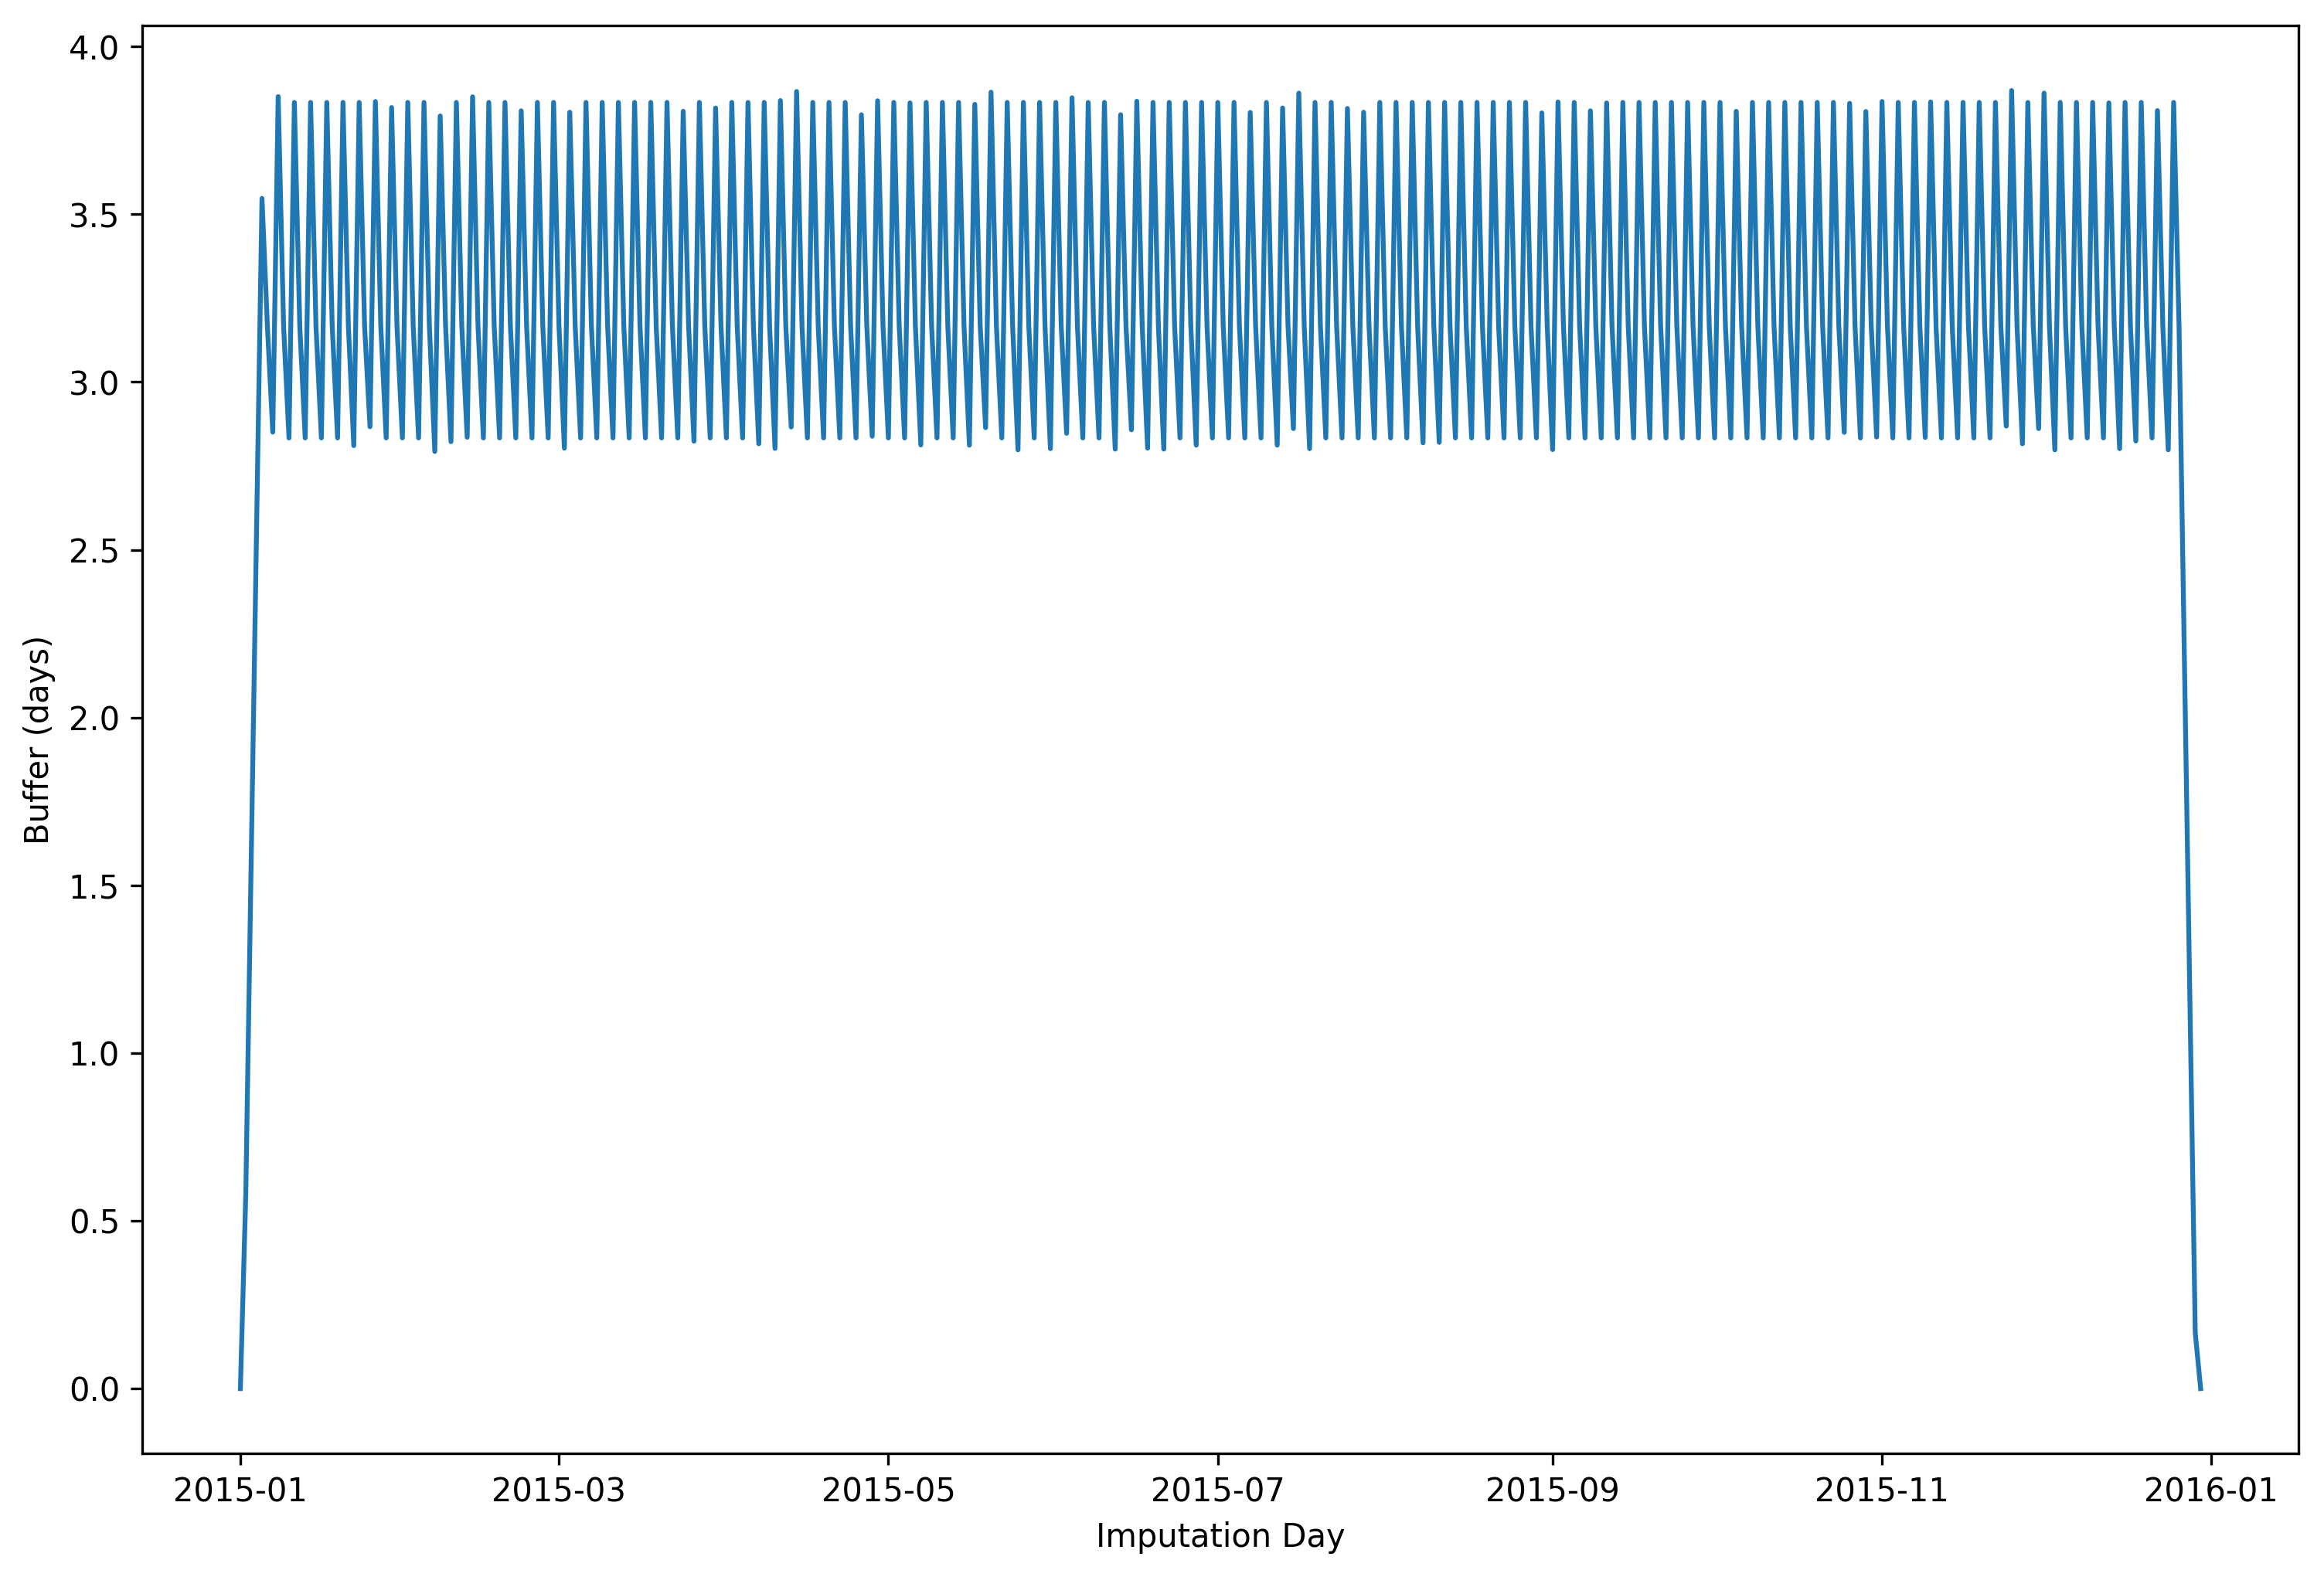

PyObject <matplotlib.text.Text object at 0x1377790f0>

In [43]:
eg = all_hours_tntx_best["simpler"][Hour(13)]
days_buffer = (eg[:buffer]) ./ Dates.Millisecond(Dates.Day(1))
plt.plot(eg[:day], days_buffer)
plt.ylabel("Buffer (days)")
plt.xlabel("Imputation Day")

# Adding variance and covariances

In [44]:
function add_varcovar!(df::DataFrames.DataFrame, tntx::Symbol)
    tx_var = df[Symbol(tntx, "_var")]
    tx_covar_yest = df[Symbol(tntx, "_covar_yest")]
    tx_covar_tmrw = df[Symbol(tntx, "_covar_tmrw")]
    tx_varcovar = tx_var .+ tx_covar_yest .+ tx_covar_tmrw
    df[Symbol(tntx, "_varcovar")] = tx_varcovar
    return df
end 

add_varcovar! (generic function with 1 method)

In [45]:
for GPmodel in models
    for hour in hours
        add_varcovar!(all_hours_tntx_best[GPmodel][hour], :Tx)
        add_varcovar!(all_hours_tntx_best[GPmodel][hour], :Tn)
    end
end

# Comparing imputed & true Tn & Tx

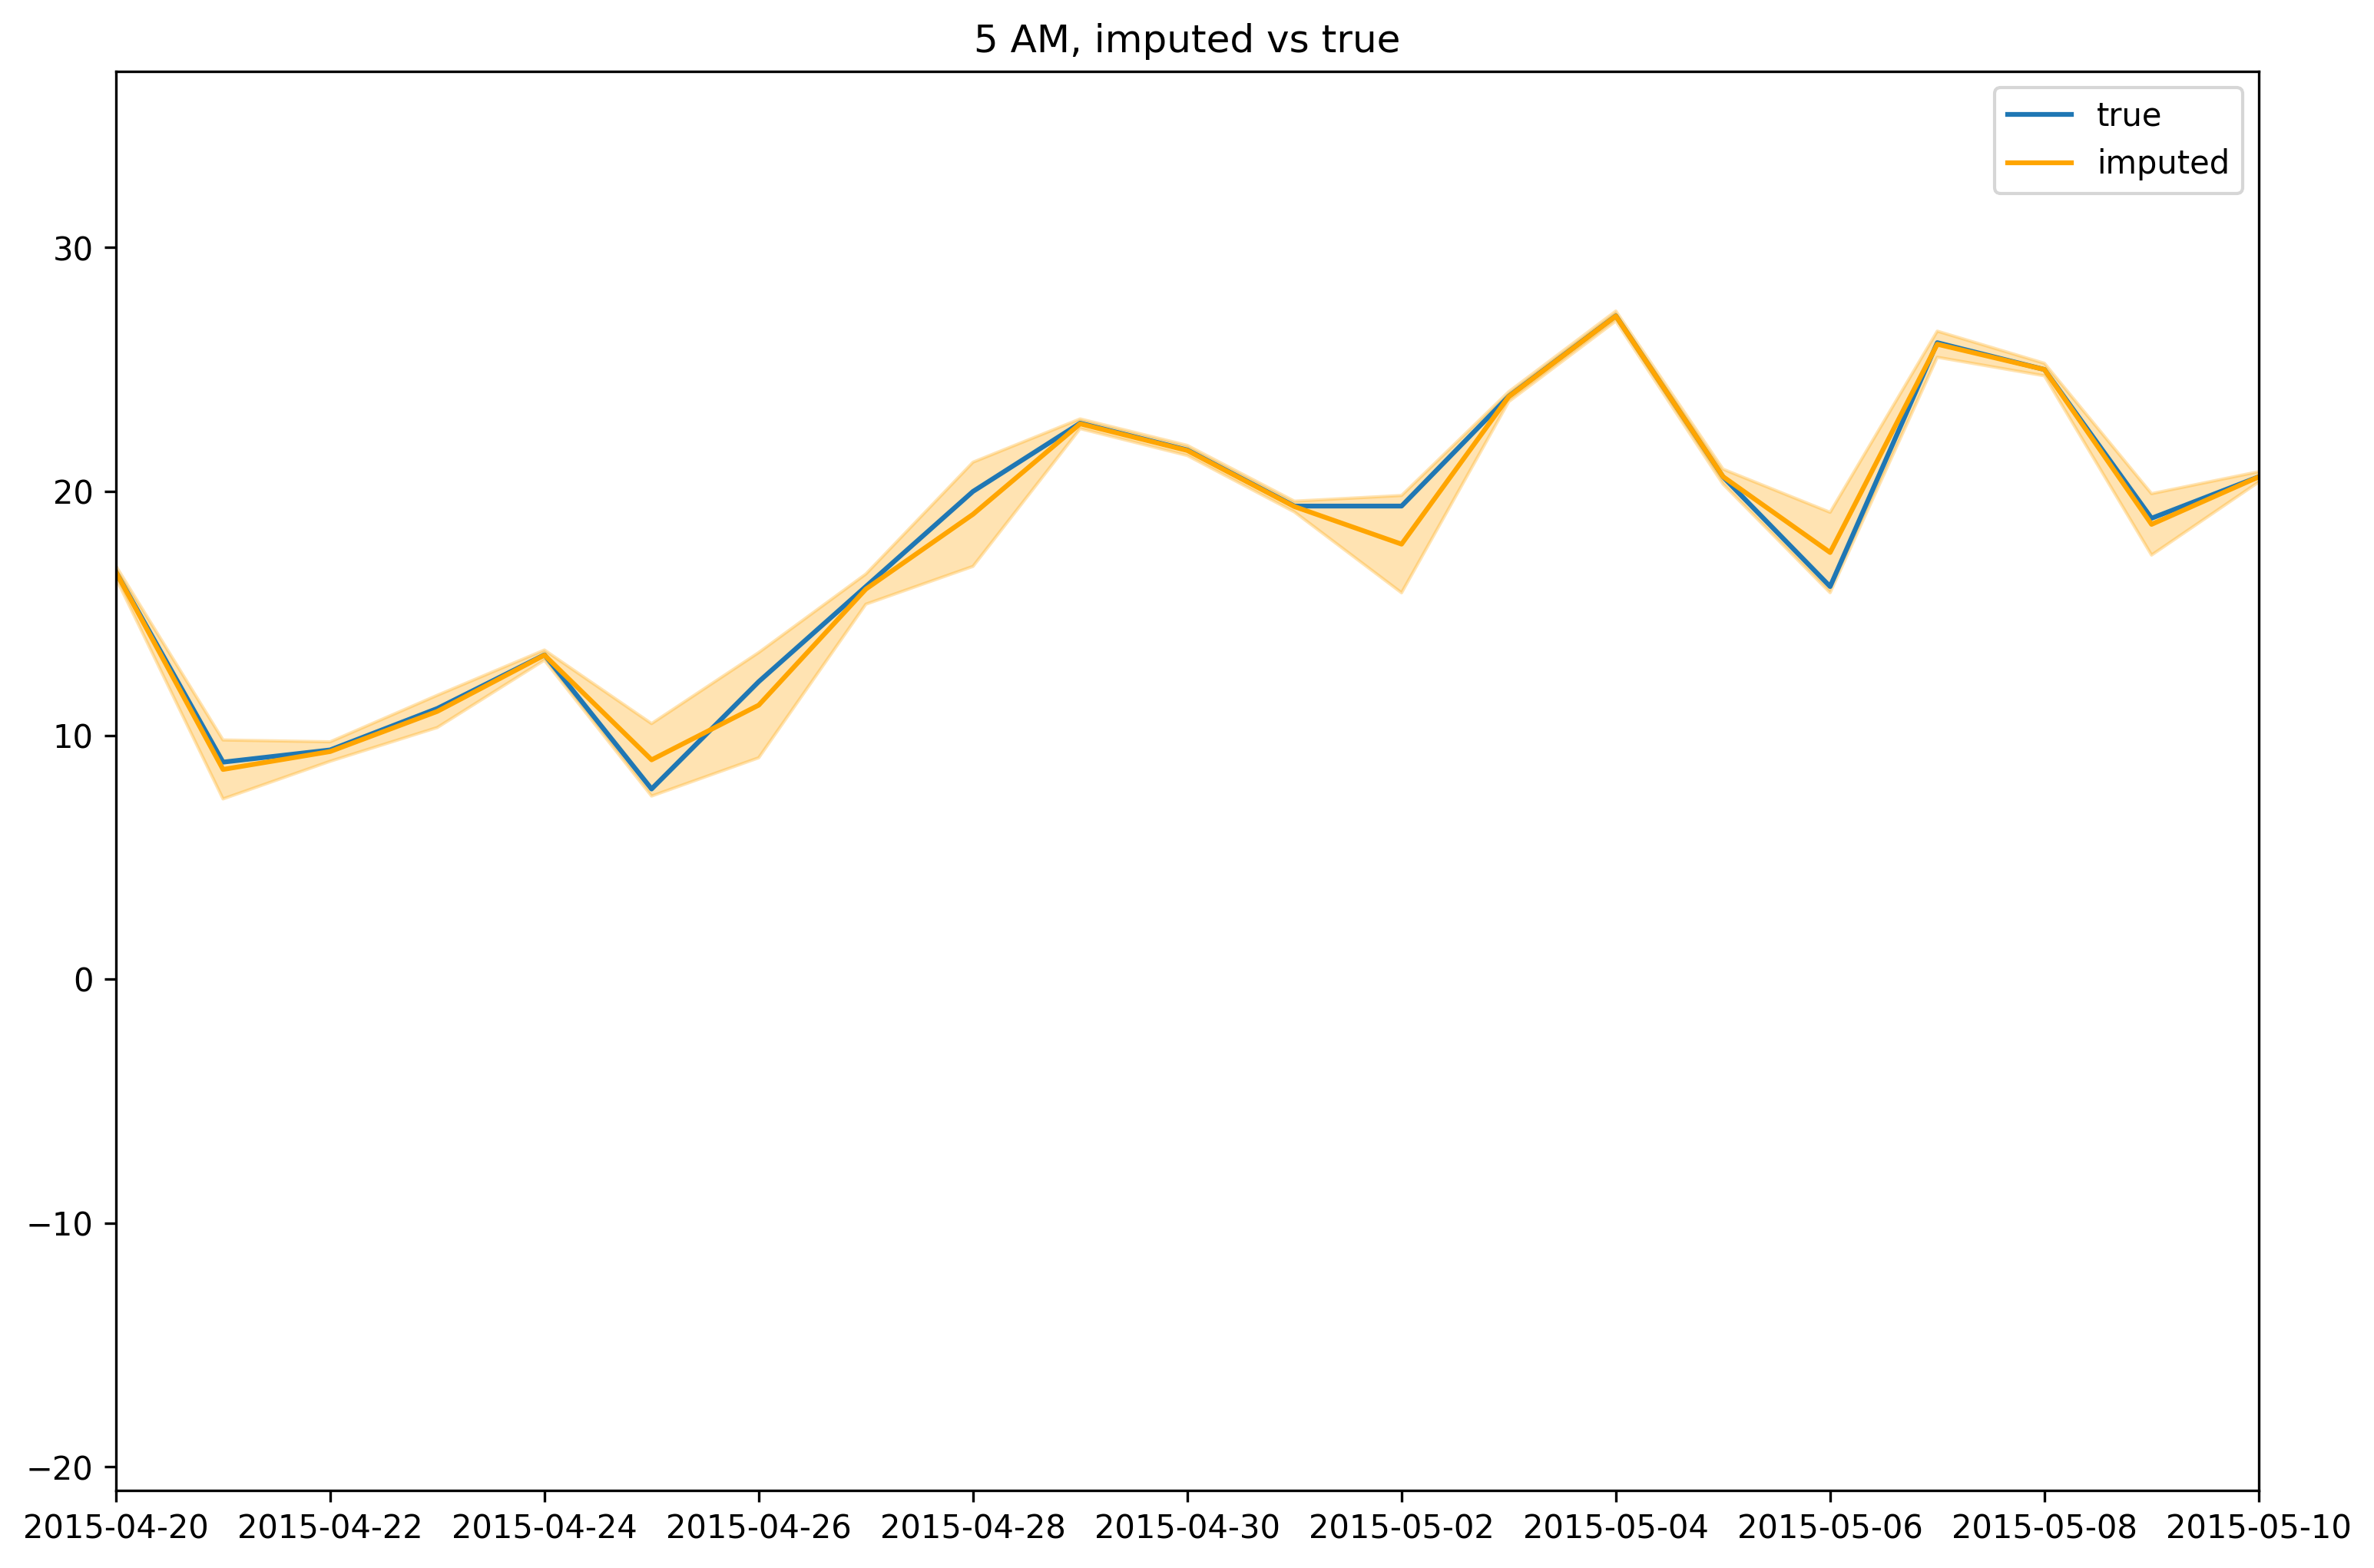

366

In [46]:
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    plt.plot(TnTx[:day], TnTx[:Tx], label="true")
    tntx_impt = all_hours_tntx_best[GPmodel][hr]
    t = tntx_impt[:day]
    y = tntx_impt[:Tx_mean]
    y_err = sqrt.(tntx_impt[:Tx_var])
    plt.plot(t, y, label="imputed", color="orange")
    plt.fill_between(t, y.-2*y_err, y.+2*y_err, alpha=0.3, color="orange")
    plt.legend(loc="best")
end
plt.xlim(Date(2015,4,20),Date(2015,5,10))
plt.title("5 AM, imputed vs true")
;

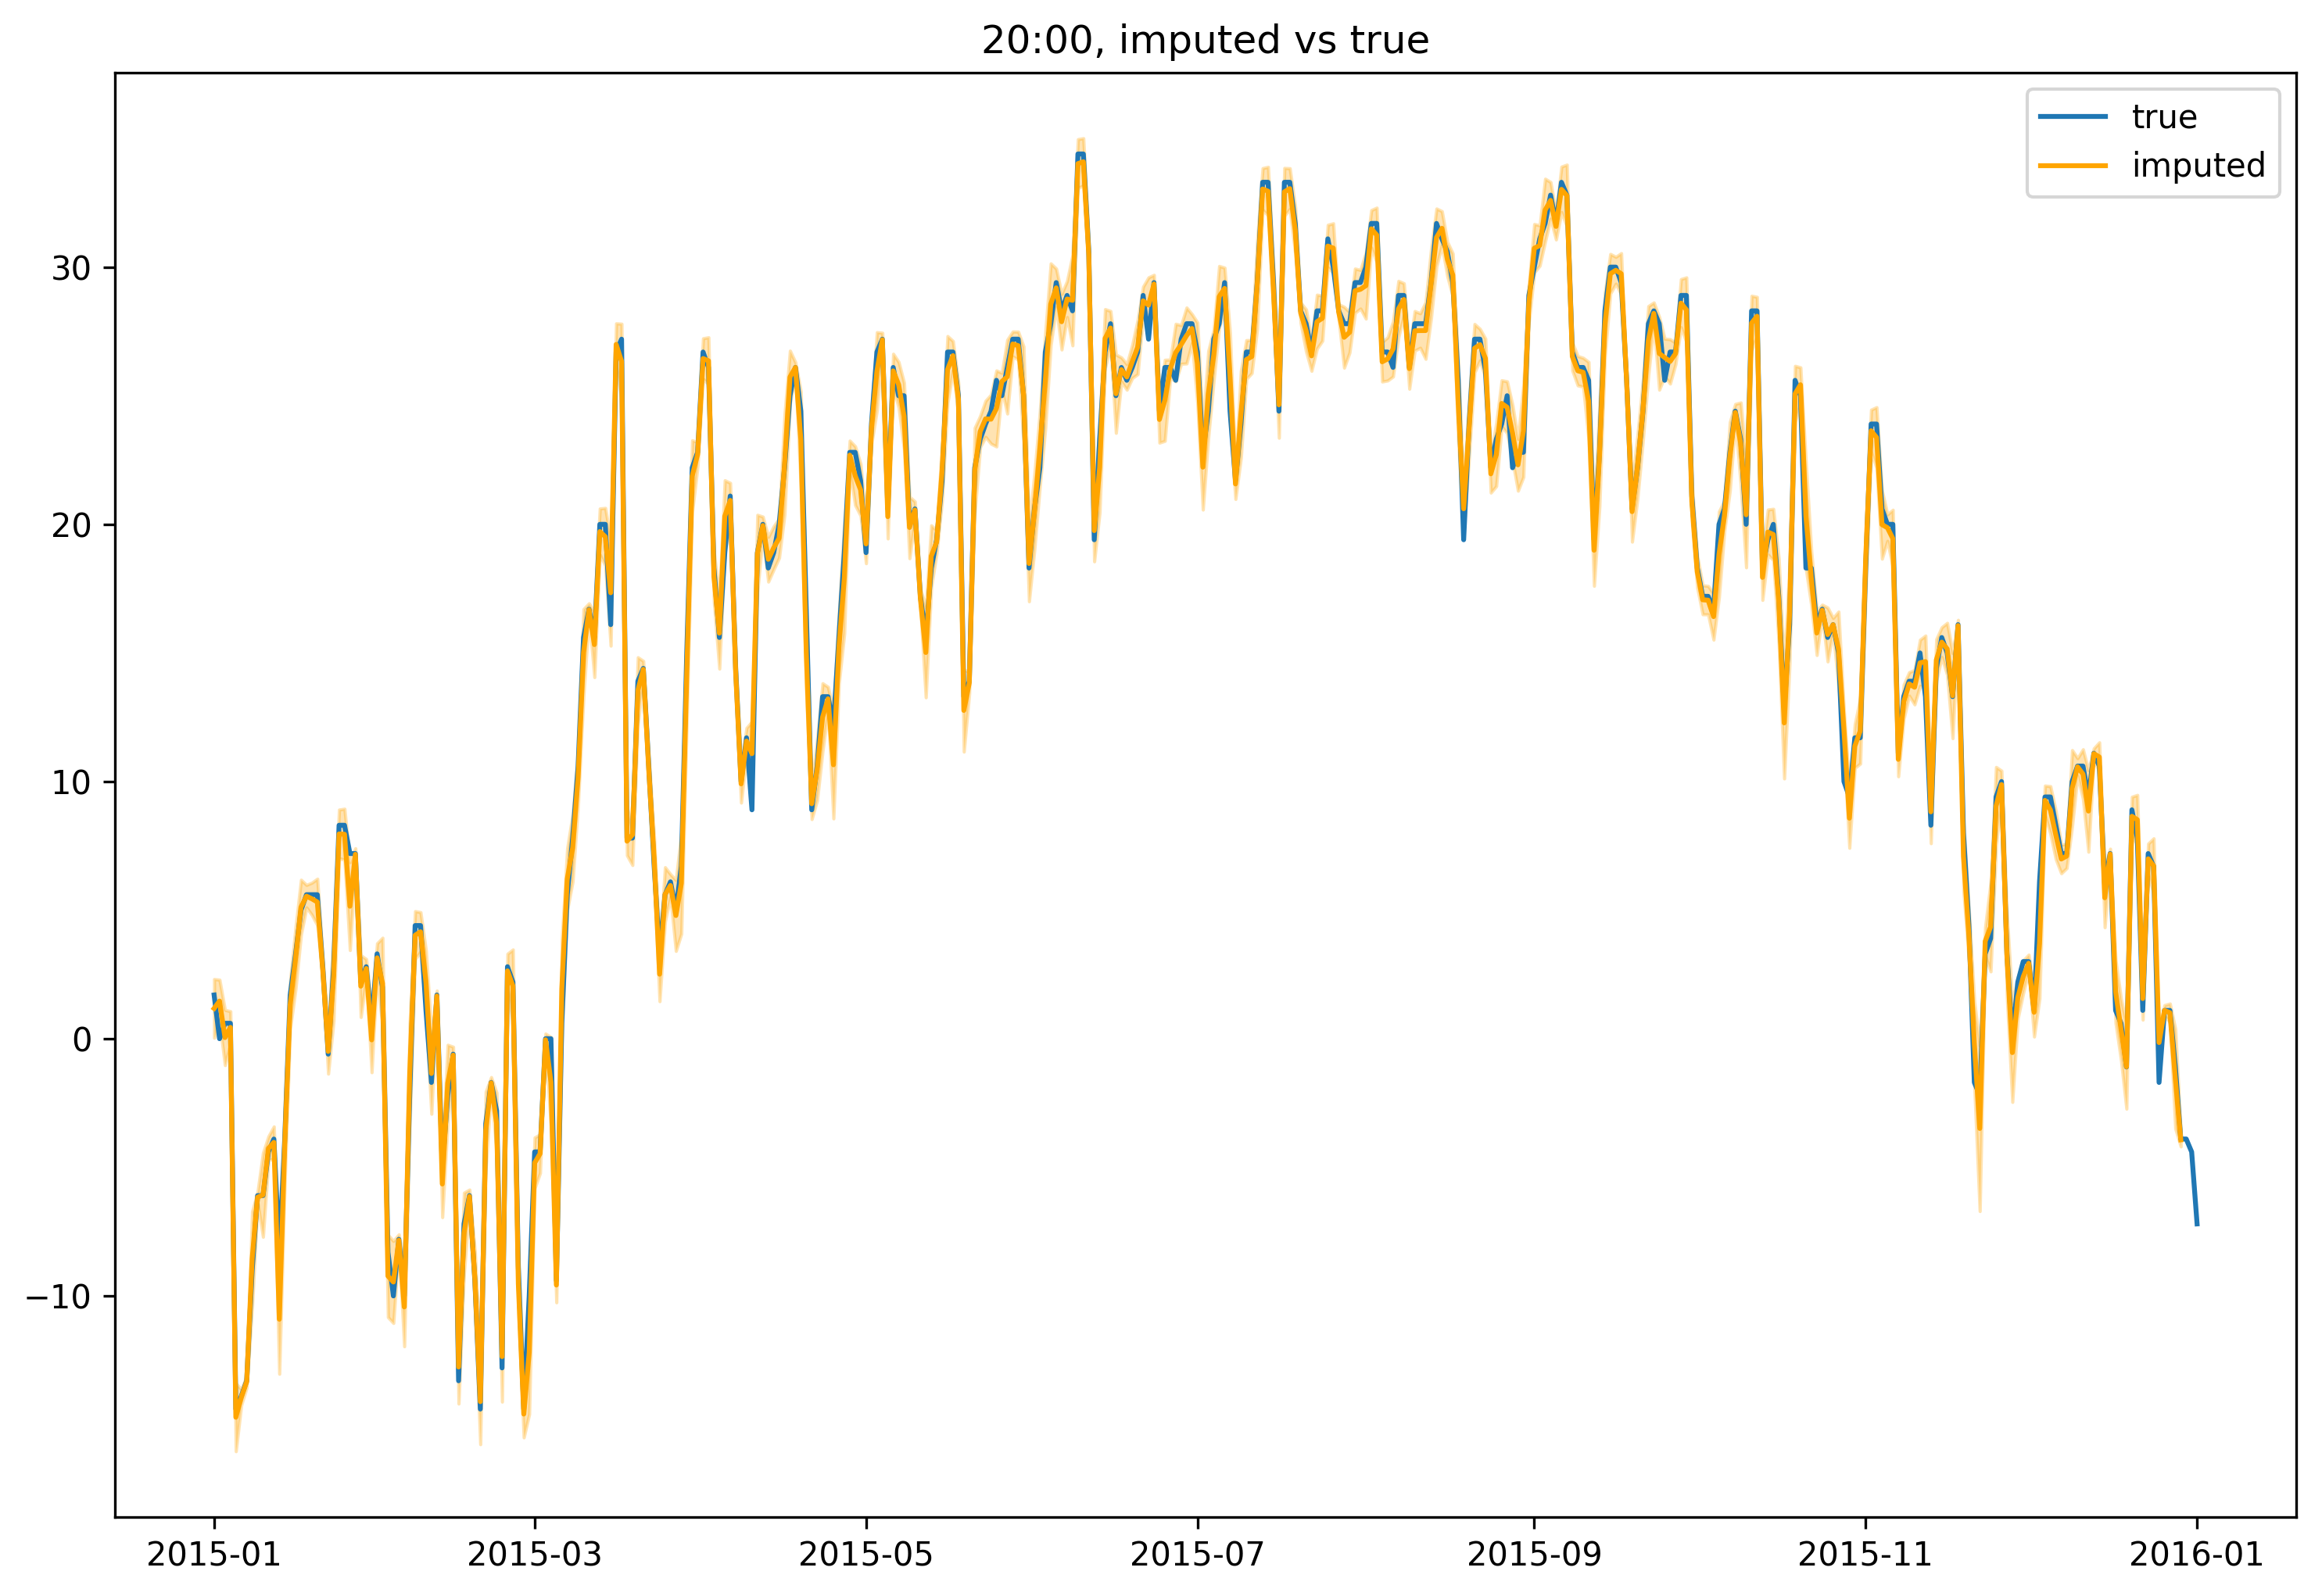

366

In [47]:
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(20)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    plt.plot(TnTx[:day], TnTx[:Tx], label="true")
    tntx_impt = all_hours_tntx_best[GPmodel][hr]
    t = tntx_impt[:day]
    y = tntx_impt[:Tx_mean]
    y_err = sqrt.(tntx_impt[:Tx_var])
    plt.plot(t, y, label="imputed", color="orange")
    plt.fill_between(t, y.-2*y_err, y.+2*y_err, alpha=0.3, color="orange")
    plt.legend(loc="best")
end
# plt.xlim(Date(2015,4,20),Date(2015,5,10))
plt.title("20:00, imputed vs true")
;

In [26]:
# include(data_dir*"src/plot_diagnostics.jl")

plot_residuals (generic function with 1 method)

In [48]:
window_num = 37
stan_fw = Batch.get_window(window_num)

Batch.FittingWindow(2015-04-19, 2015-04-28)

In [52]:
iowa_time(ts) = ts - Hour(6)

iowa_time (generic function with 1 method)

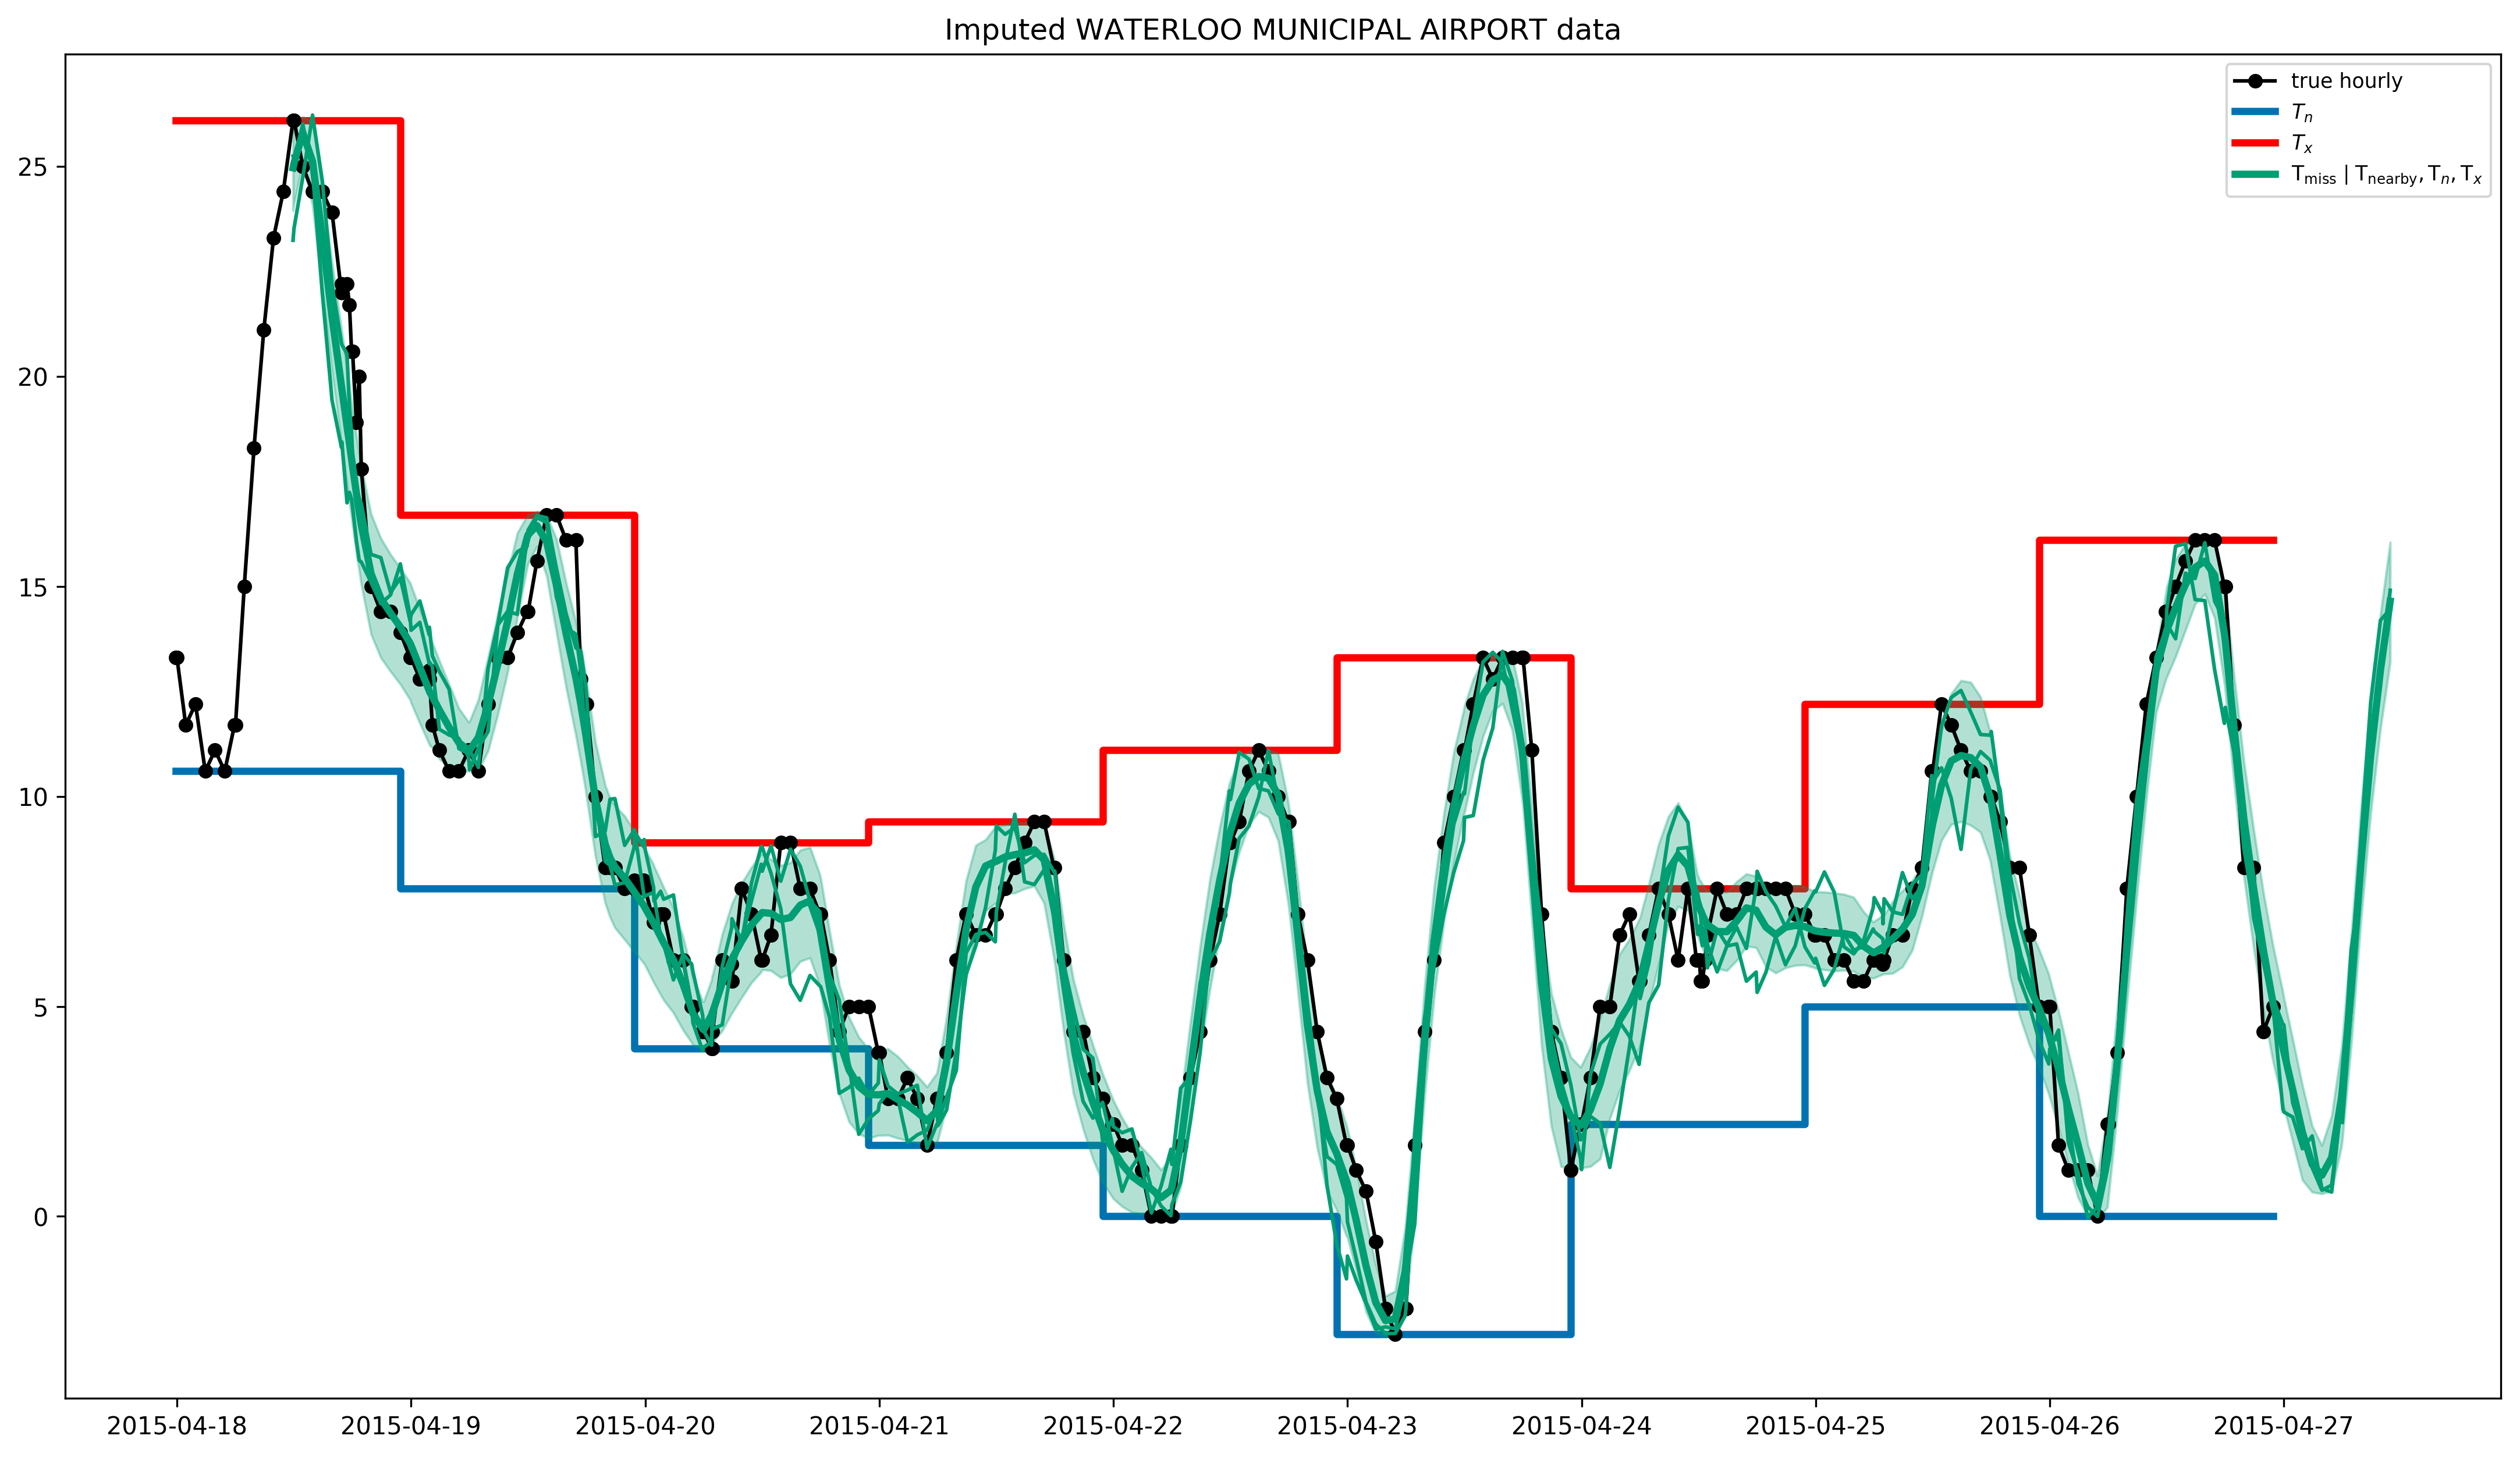

In [53]:
# not sure what the point of this plot is...
begin
    hr_measure = Hour(5) # number between 0 and 24
    hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
    
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    TnTx = get_TnTx(temps, ts, hr_measure)
    
    TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
        Tn=minimum(df[:temp]), 
        Tx=maximum(df[:temp])))
    # add column to test data for TnTx (useful for plotting)
    test_trimmed=join(hourly_test, TnTx, on=:ts_day)

    GPmodel = "simpler"
    window_num = 37
    stan_fw = Batch.get_window(window_num)
    chains, chain_ts = Batch.get_chains_and_ts(stan_fw, GPmodel, test_usaf)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)

    Batch.plot_truth(test_subsubset, stan_fw, hr_measure, iowa_time; tntx=true)
#     Batch.plot_imputations(chain_ts, temp_impute)
    Batch.plot_imputations(chain_ts, temp_impute, iowa_time; impt_indices=[250,500])

    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", isdSubset[itest,:NAME]))
end
;

366(366,)
(364,)
366

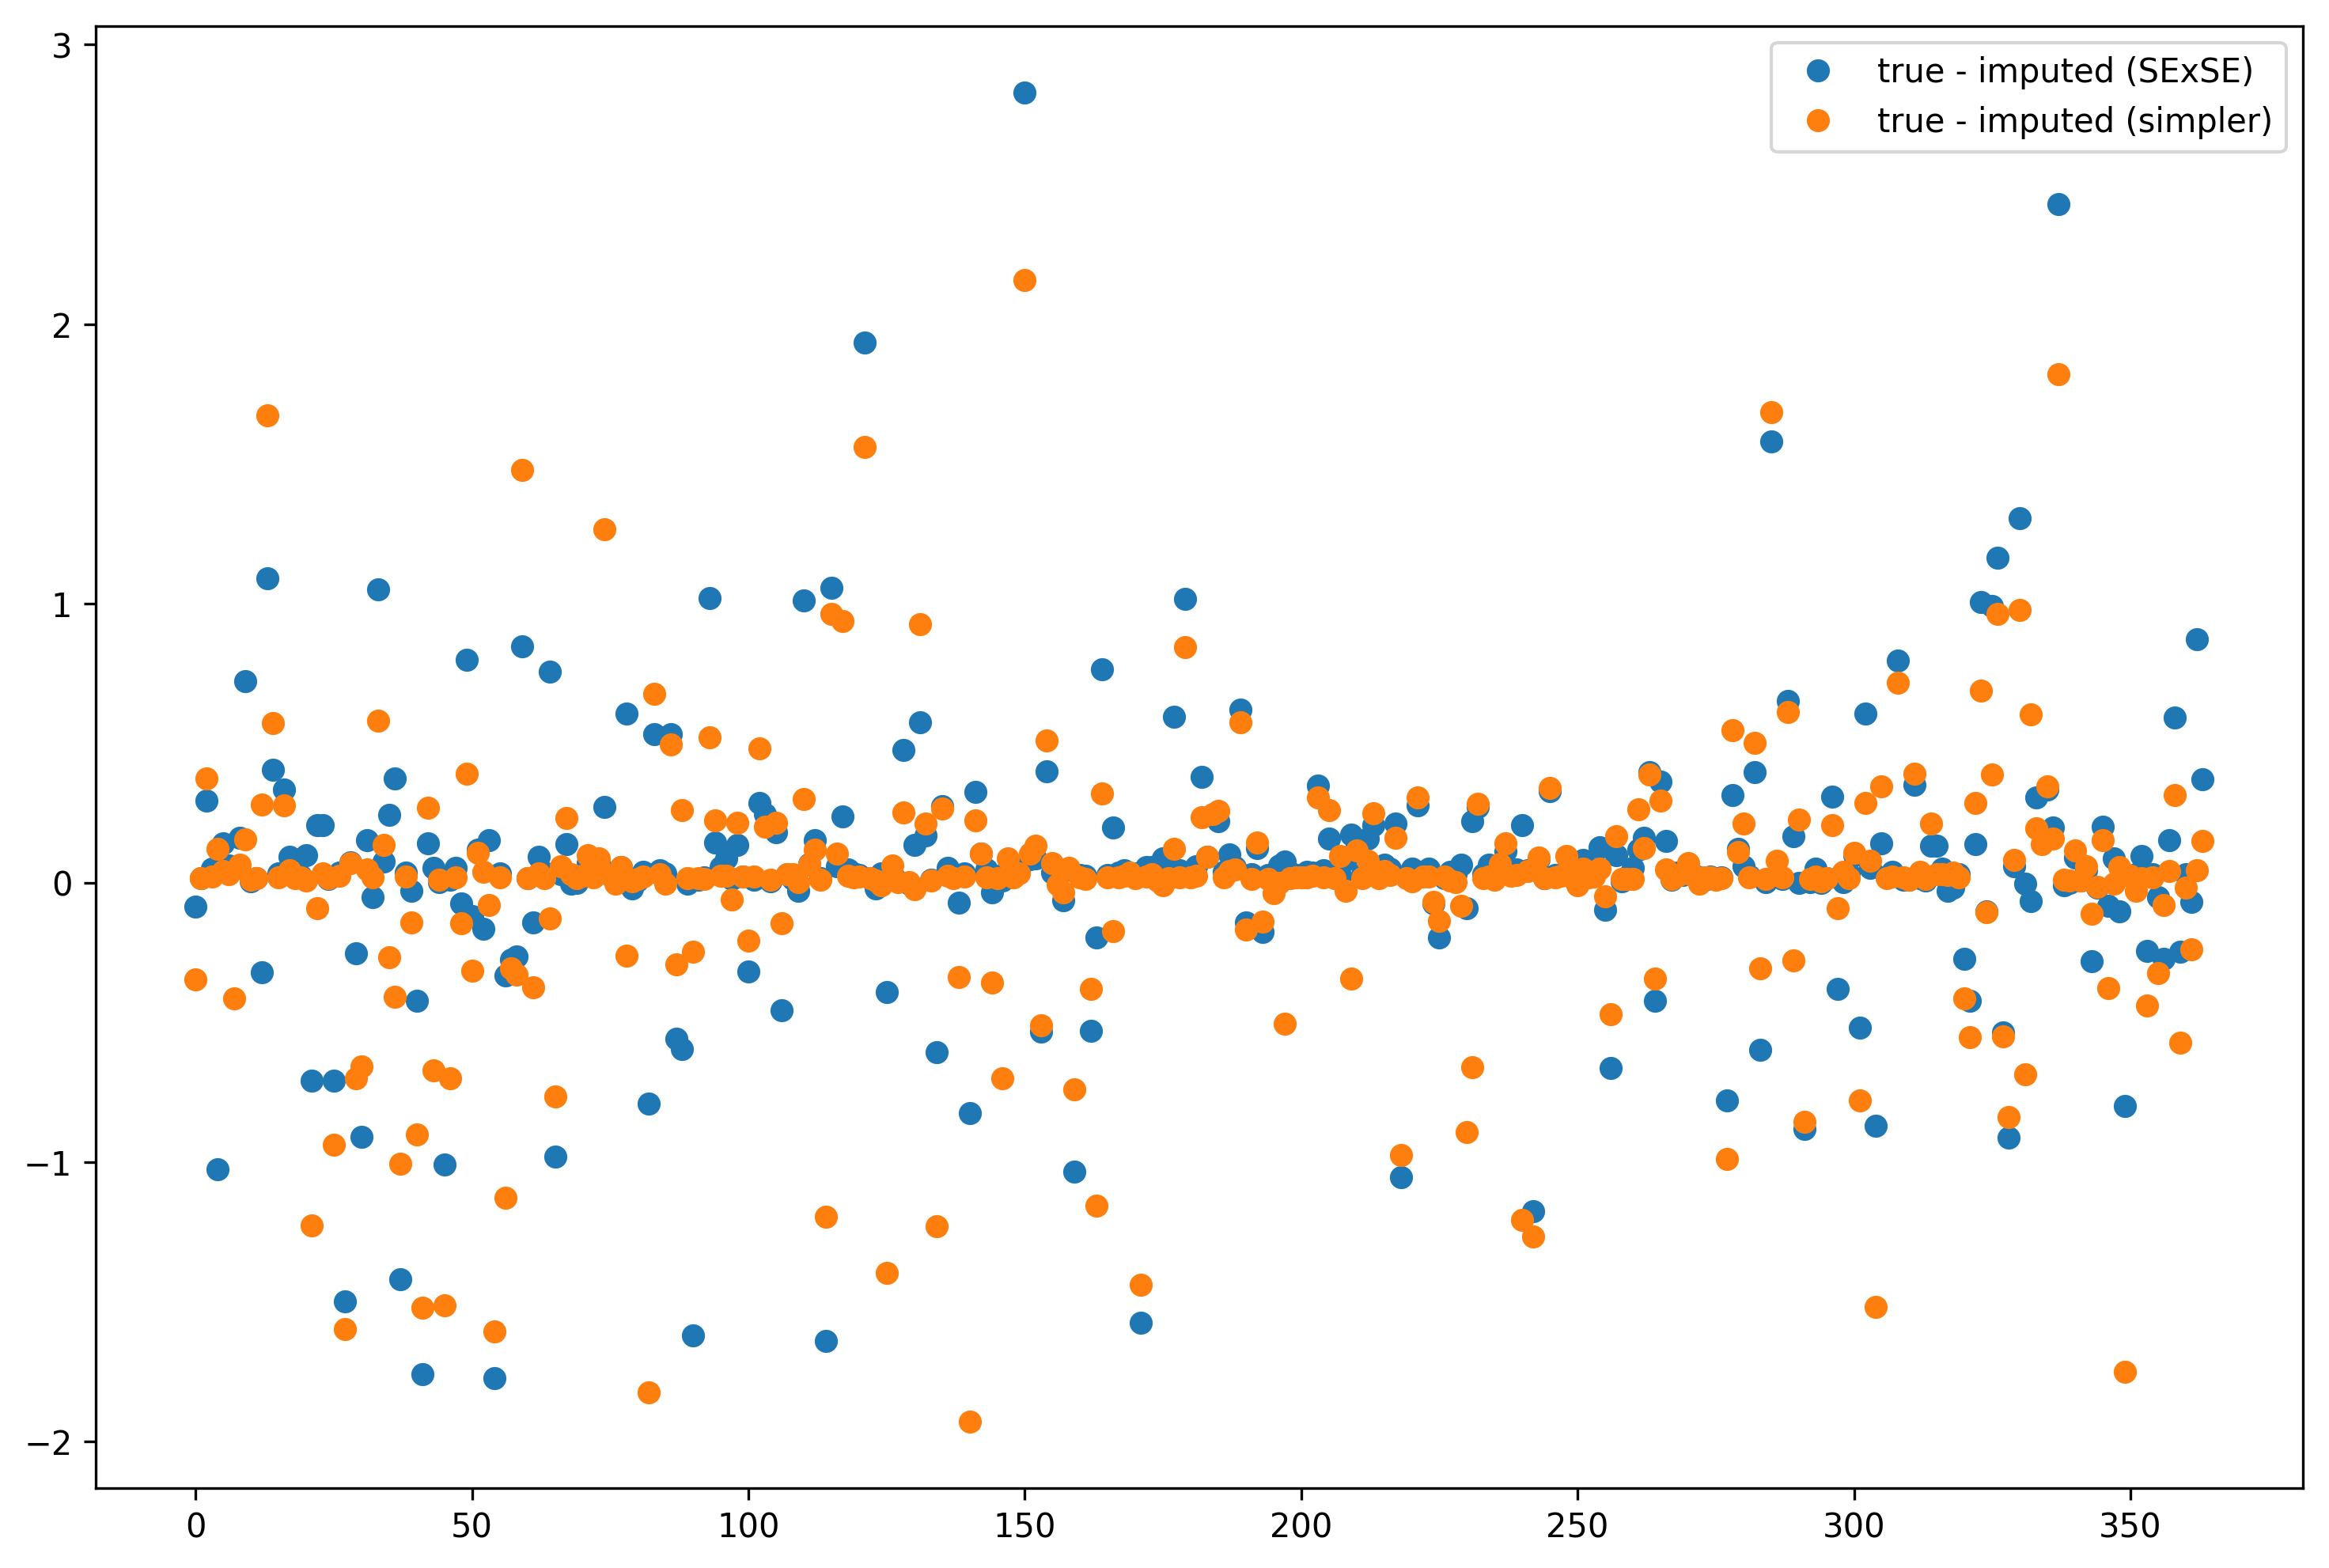

(366,)
(364,)


In [54]:
begin
    GPmodel = "SExSE"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plot(y_diff, "o", label="true - imputed (SExSE)")
end
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plot(y_diff, "o", label="true - imputed (simpler)")
    plt.legend(loc="best")
end
;

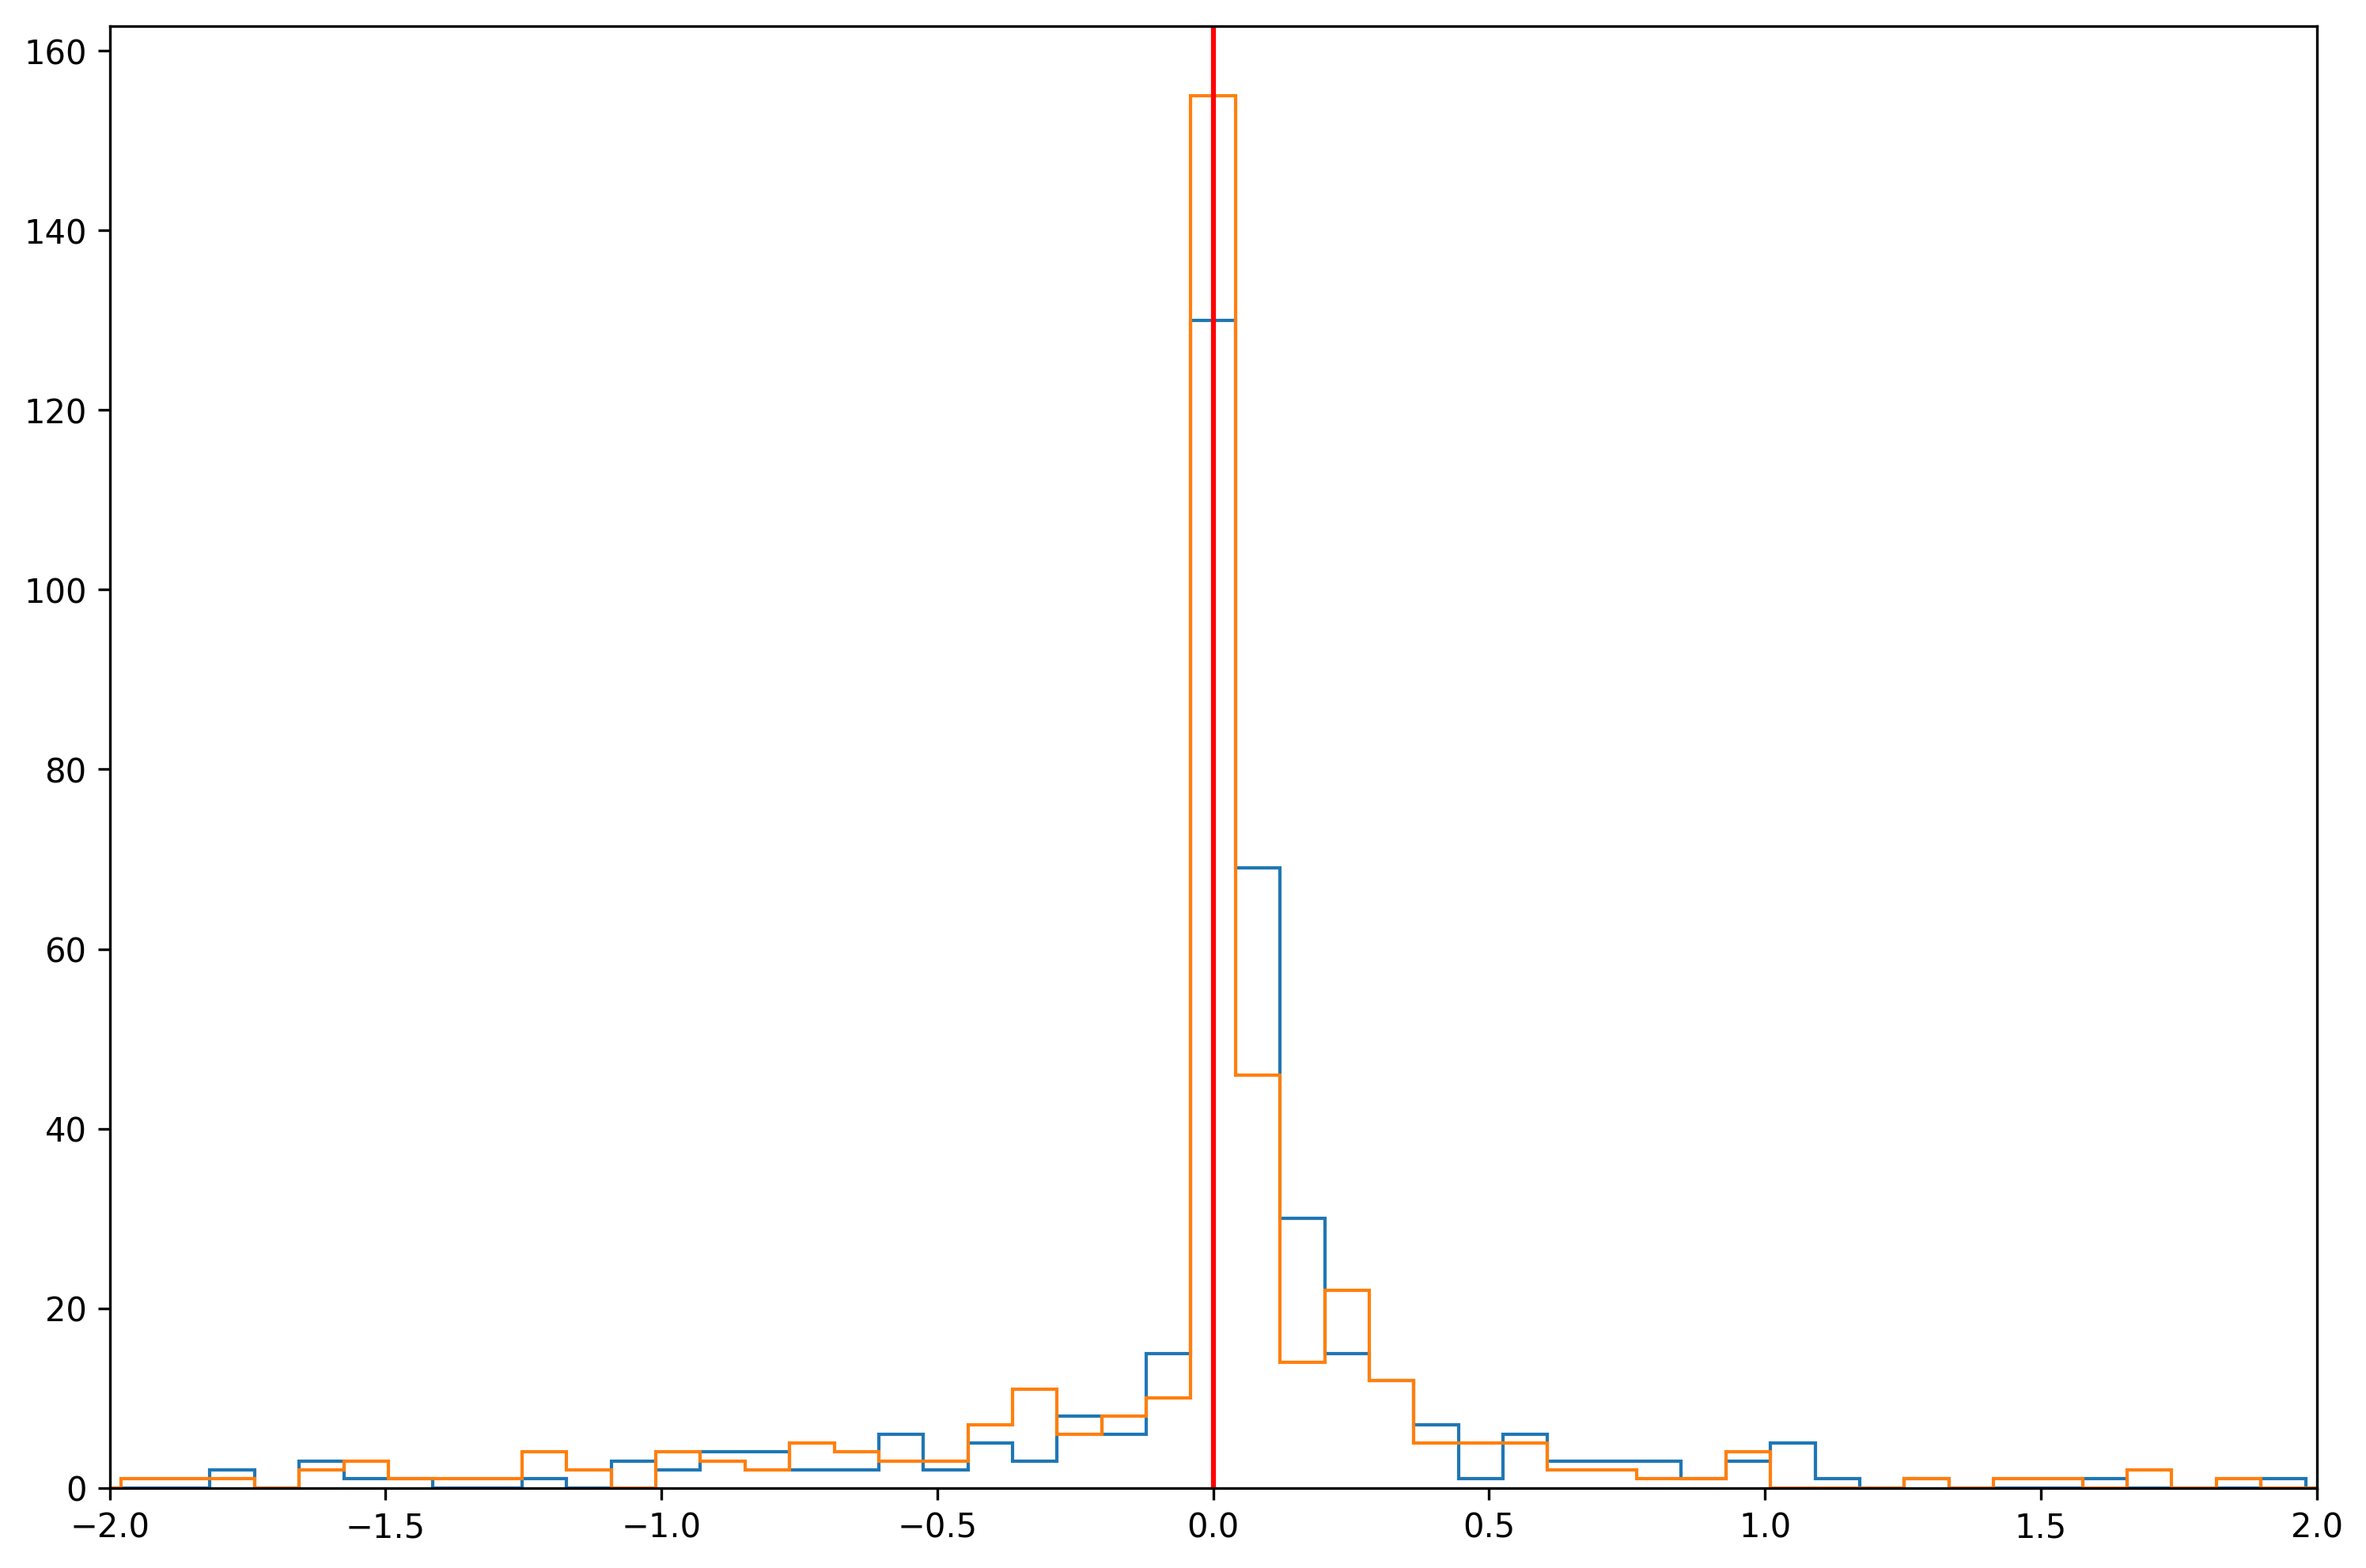

366(366,)
(364,)
366(366,)
(364,)


In [56]:
begin
    GPmodel = "SExSE"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plt[:hist](y_diff, bins=linspace(-4,4,100), histtype="step")
end
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plt[:hist](y_diff, bins=linspace(-4,4,100), histtype="step")
end
plt.axvline(x=0.0, color="red")
plt.legend(loc="best")
plt.xlim(-2,2)
;

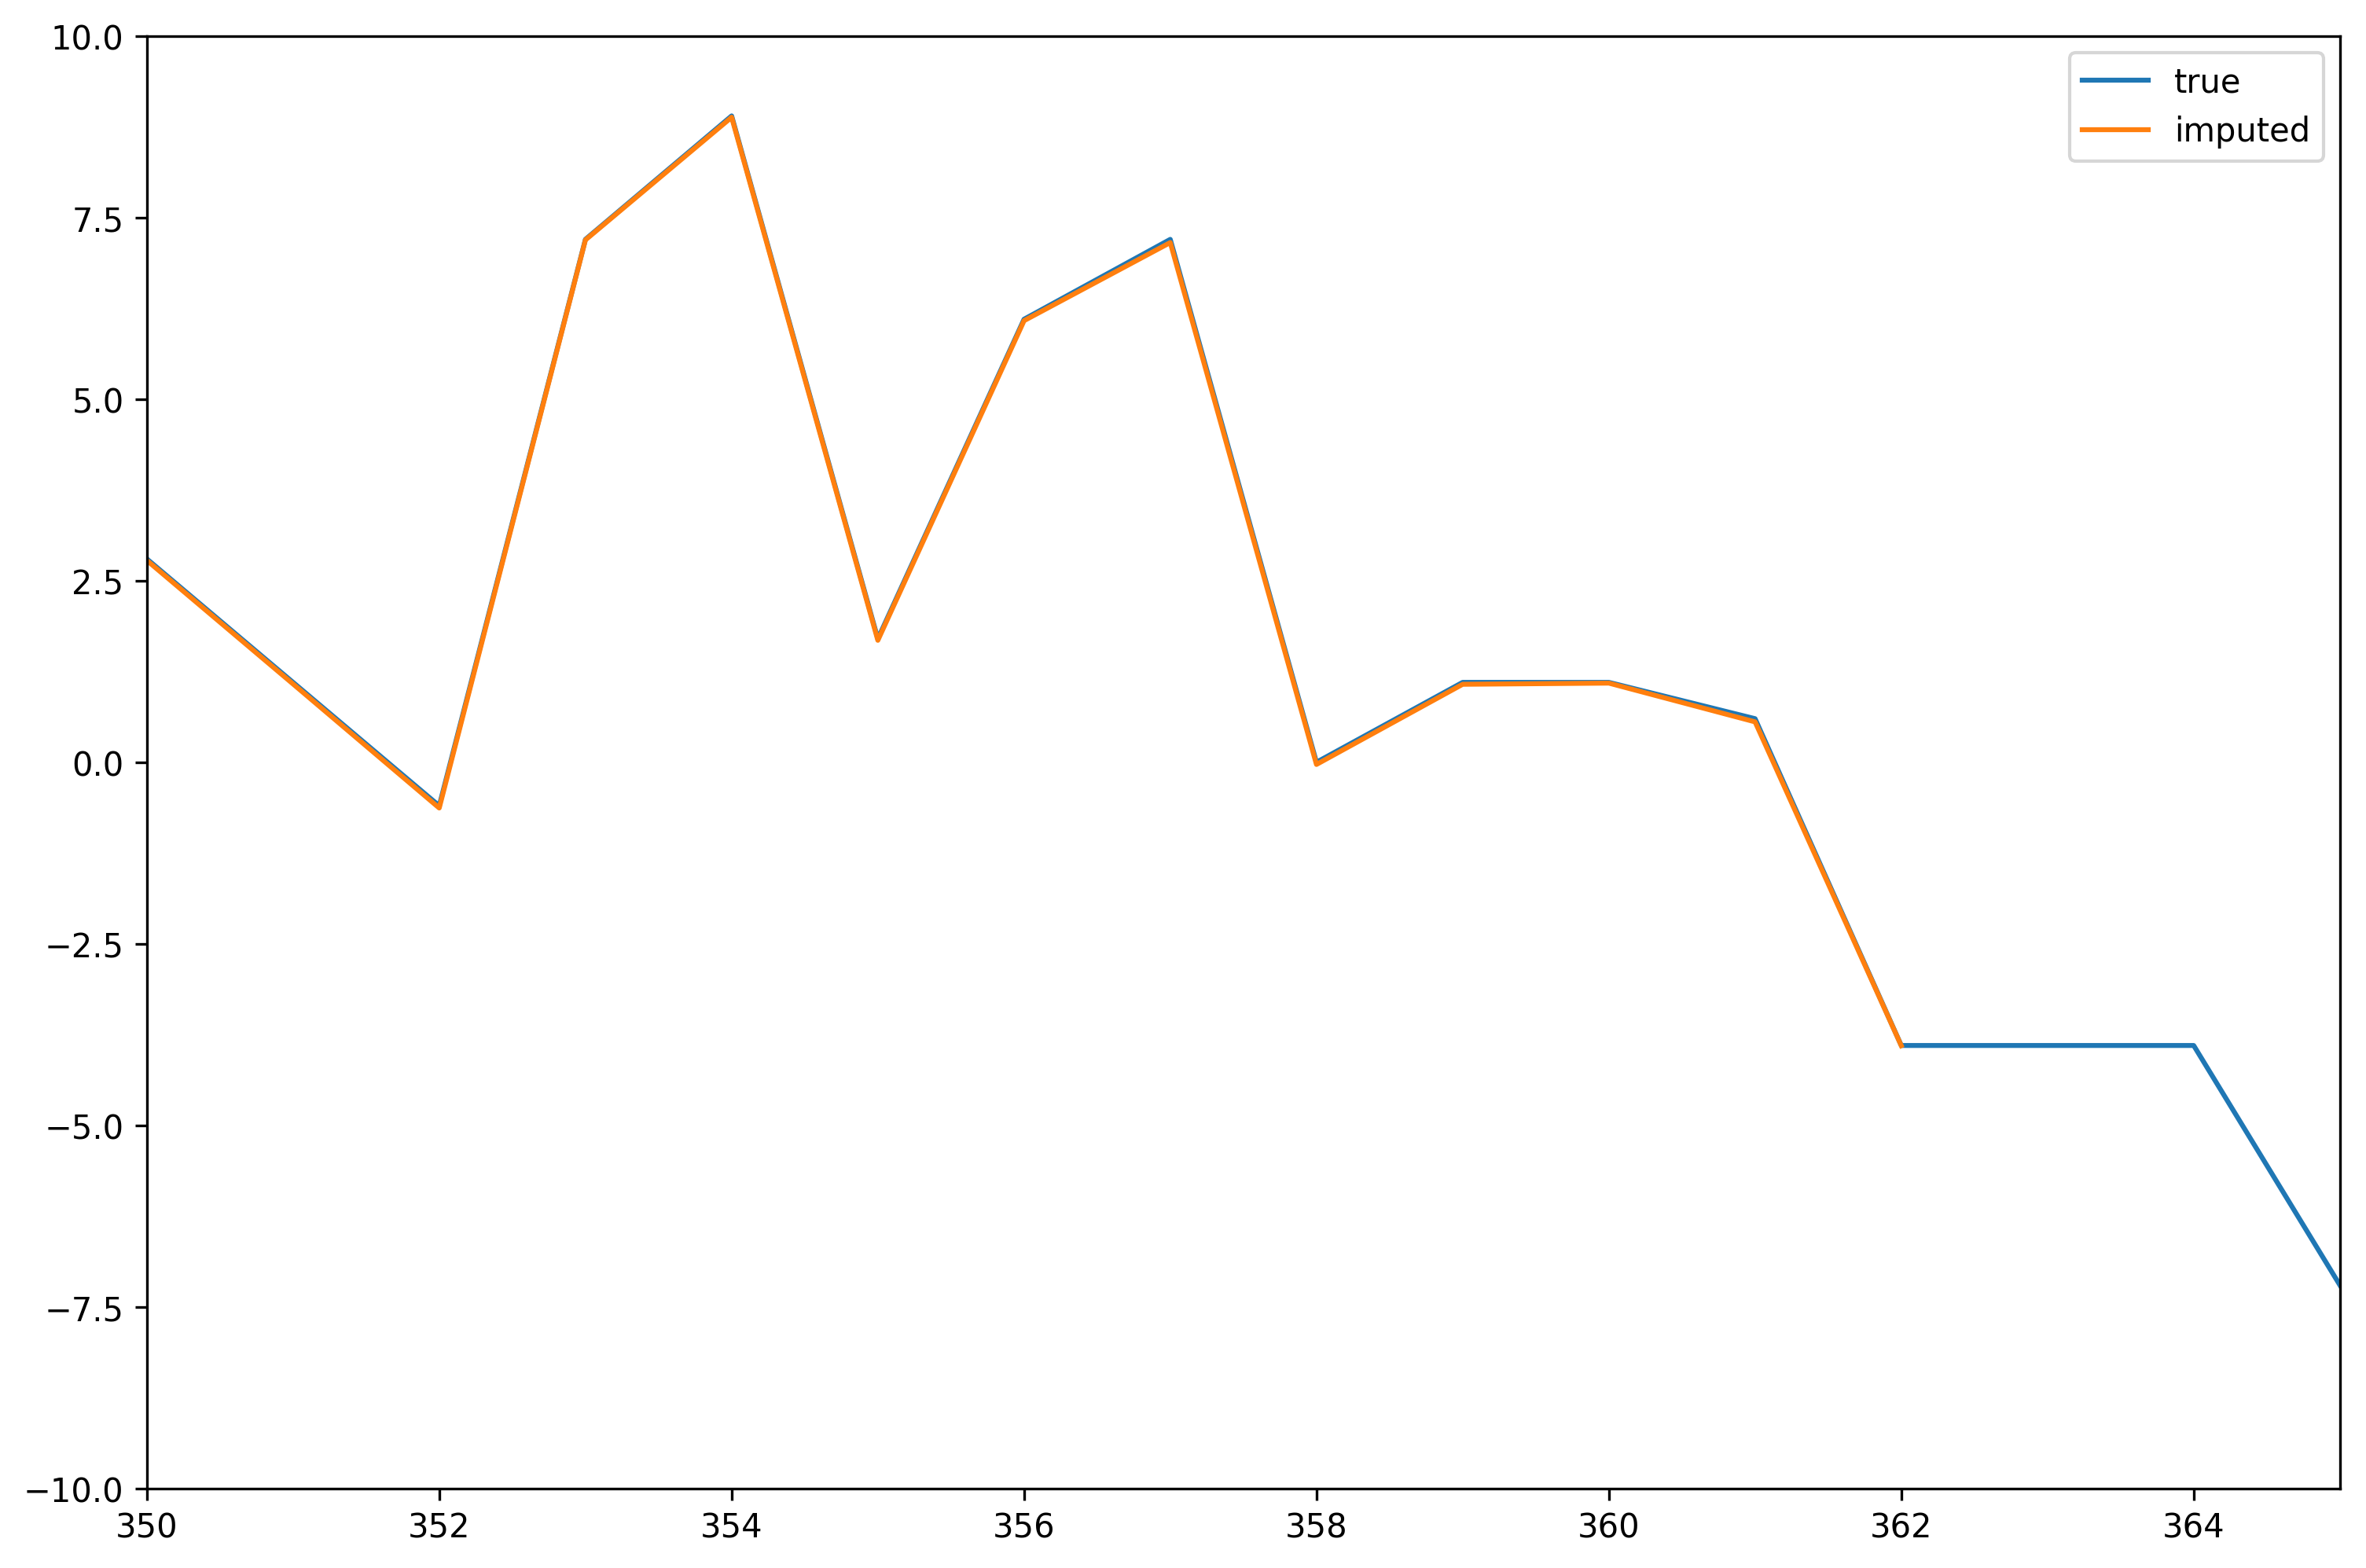

366

(-10, 10)

In [57]:
begin
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    hr = Hour(17)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    plt.plot(TnTx[:Tx], label="true")
    plt.plot(all_hours_tntx_best[GPmodel][hr][:Tx_mean], label="imputed")
    plt.legend(loc="best")
end
plt.xlim(350,365)
plt.ylim(-10,10)

# Summarizing

In [60]:
""" The earliest date available in each imputed TnTx. """
function maxmindate(tntx_dict::Dict{Hour, DataFrames.DataFrame})
    maxmin = maximum(
        minimum(tntx[:day])
        for tntx in values(tntx_dict)
        )
    return maxmin
end
""" The latest date available in each imputed TnTx. """
function minmaxdate(tntx_dict::Dict{Hour, DataFrames.DataFrame})
    minmax = minimum(
        maximum(tntx[:day])
        for tntx in values(tntx_dict)
        )
    return minmax
end
minday = Date(2015,1,2)
maxday = minmaxdate(all_hours_tntx_best[GPmodel])

2015-12-29

In [61]:
"""
    Compute mean Tn or Tx within a range of days.
"""
function mean_days(tntx_df::DataFrames.DataFrame, tntx_sym::Symbol, minday::Date, maxday::Date)
    y = tntx_df[tntx_sym]
    day = tntx_df[:day]
    inside = (day .>= minday) .& (day .<= maxday)
    return mean(y[inside])
end
mean_days(all_hours_tntx_best[GPmodel][Hour(17)], :Tn_mean, minday, maxday)

4.604266602363253

In [62]:
"""
    Compute the posterior variance of the mean Tn or Tx within a range of days.
    Note: this is an approximation ignoring covariances beyond time lags of 1.
"""
function mean_se(all_hours_tntx_best, GPmodel::String, tntx::Symbol, minday::Date, maxday::Date)
    mean_mean = [mean_days(all_hours_tntx_best[GPmodel][hour],
                          Symbol(tntx, "_mean"),
                          minday, maxday)
                for hour in hours]
    ndays = (maxday - minday + Day(1)) / Day(1)
    se2_mean = [(mean_days(
        all_hours_tntx_best[GPmodel][hour],
        Symbol(tntx, "_var"), 
        minday, maxday)
        / ndays)
        for hour in hours]
    varcovar_mean = [(
            mean_days(all_hours_tntx_best[GPmodel][hour],
            Symbol(tntx, "_varcovar"),
            minday, maxday)
            / ndays)
            for hour in hours]              
    return mean_mean, se2_mean, varcovar_mean
end

mean_se

# Plotting

## truth

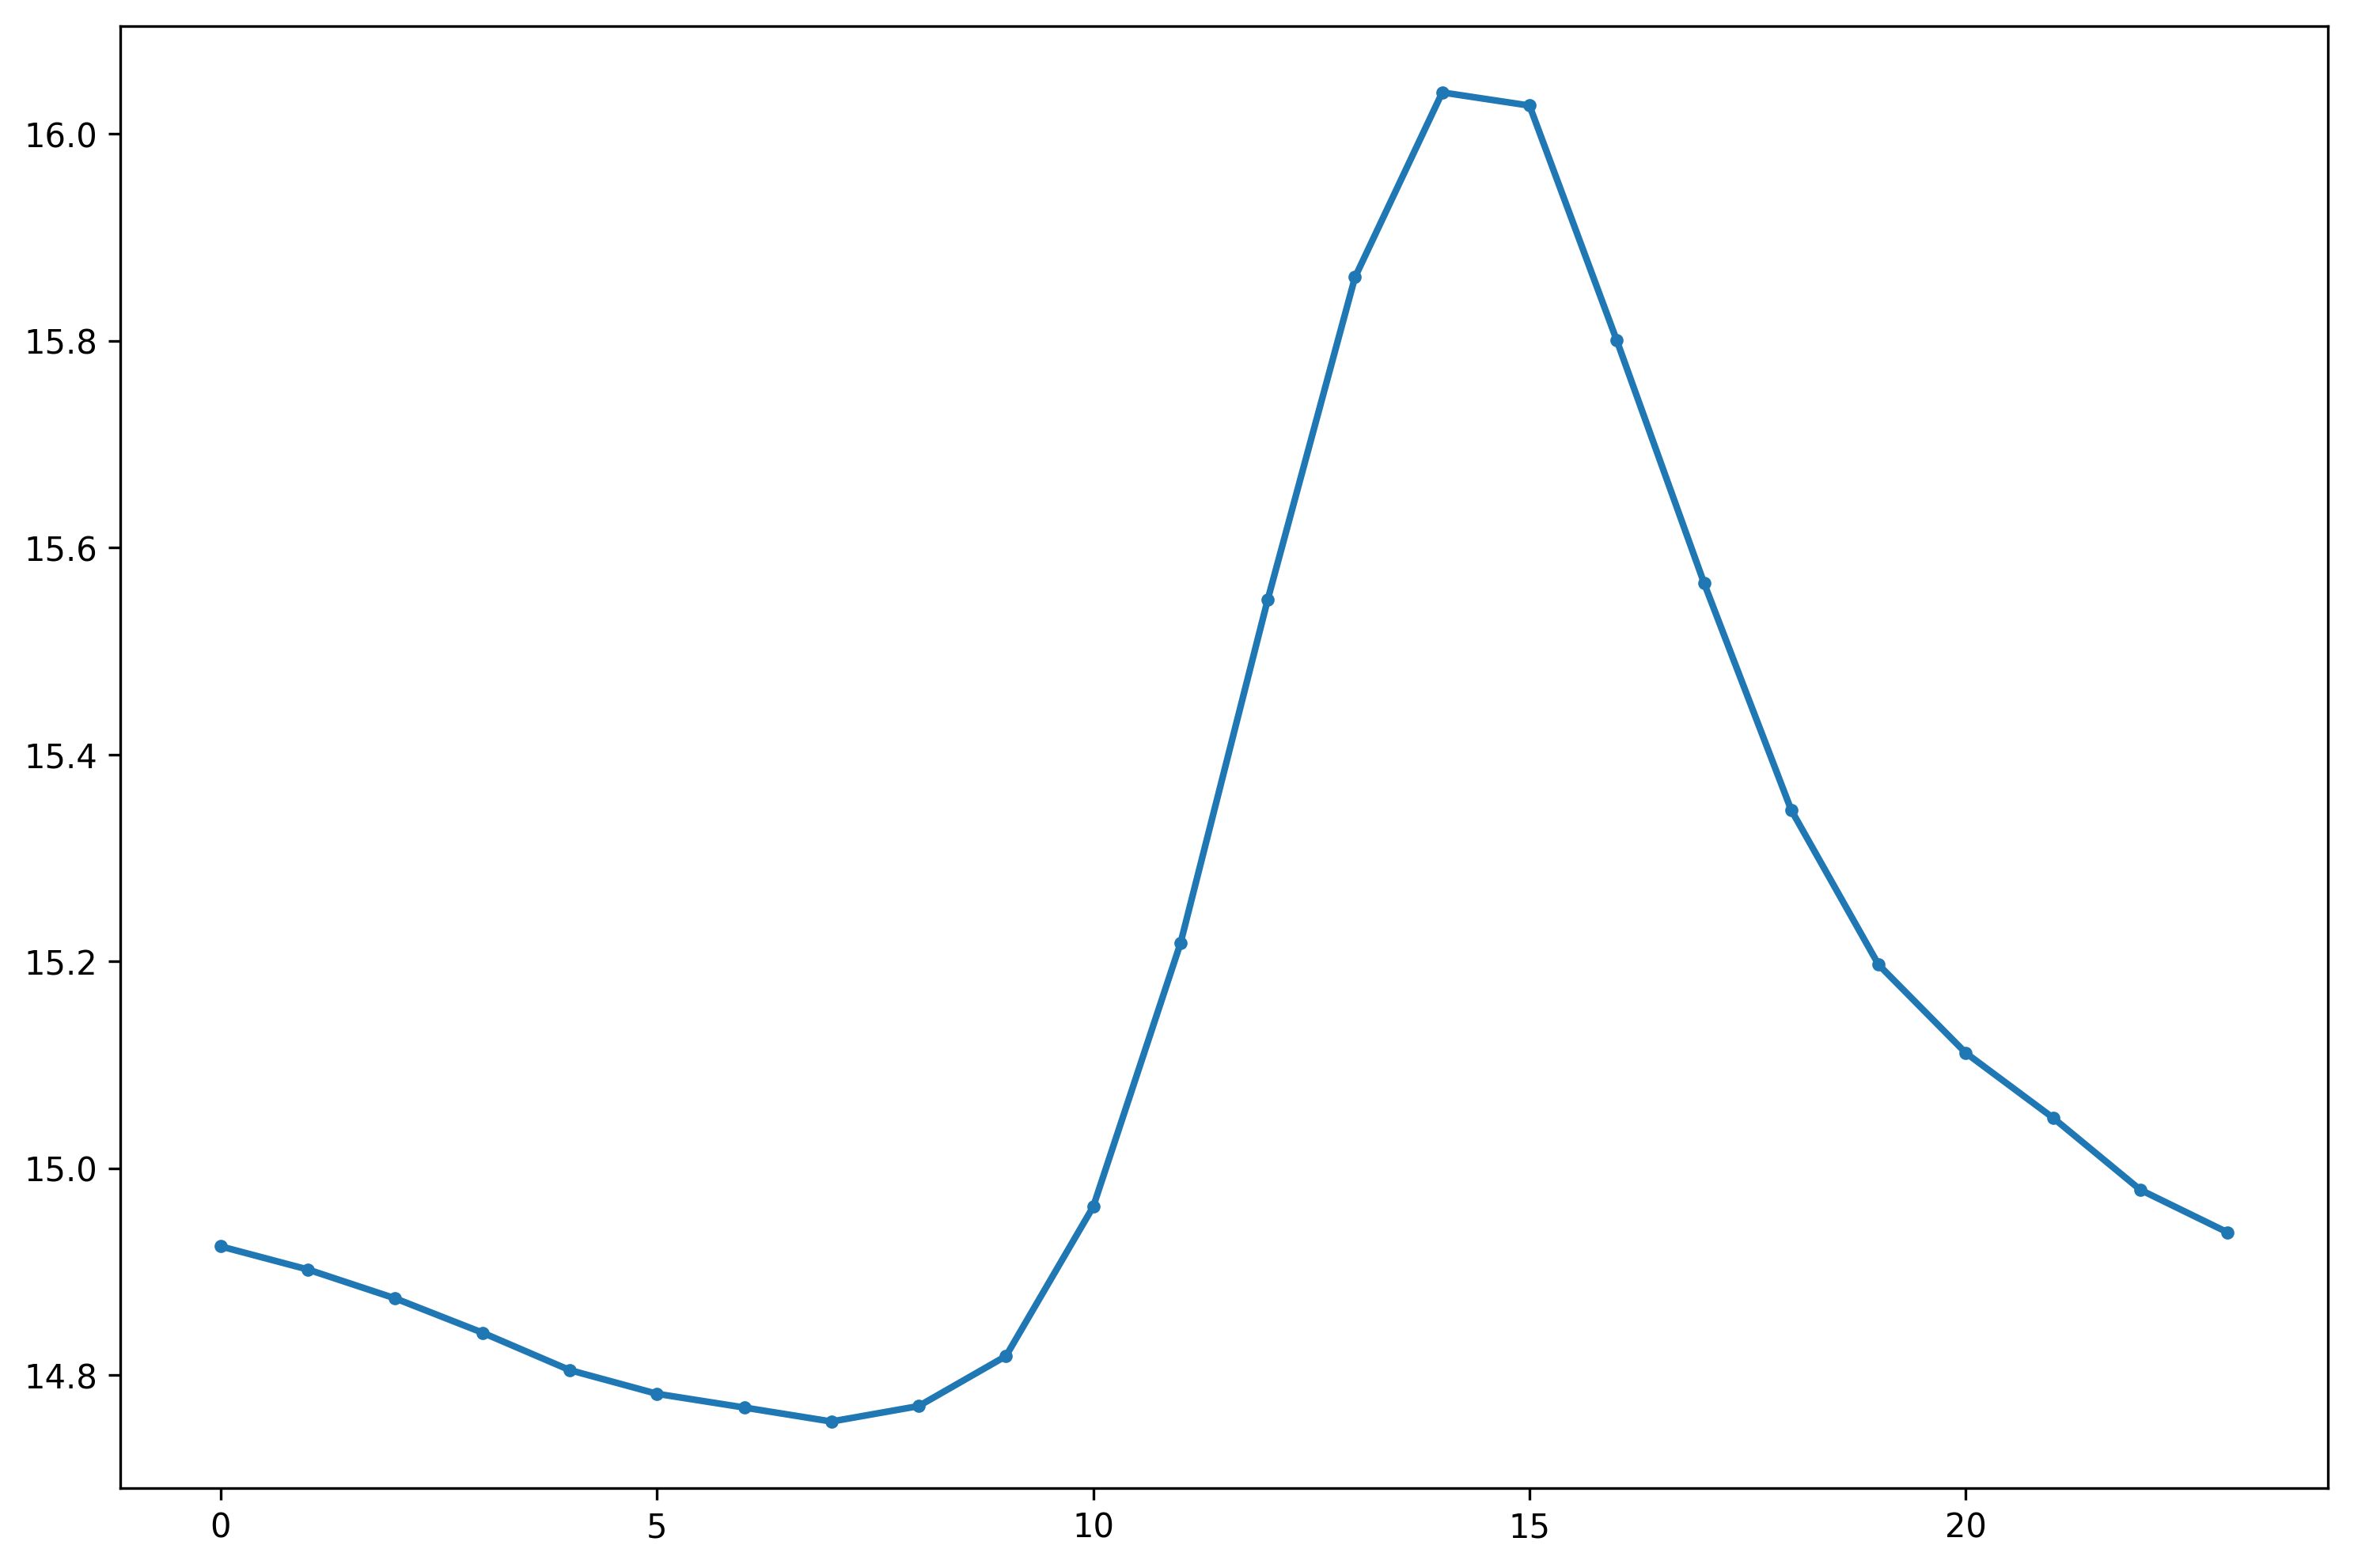

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13babb9b0>

In [100]:
function get_true_TnTx(tntx::Symbol, stat::Function, hr::Hour, minday::Date, maxday::Date)
    ts = hourly_test[:ts]
    temps = hourly_test[:temp]
    TnTx = get_TnTx(temps, ts, hr)
    day = TnTx[:day]
    inside = (day .>= minday) .& (day .<= maxday)
    result = stat(TnTx[inside,tntx])
    return result
end 
    
function plot_true_TnTx(tntx::Symbol, stat::Function, minday::Date, maxday::Date; hr_shift=-6)
    ilocaltime = circshift(1:24, hr_shift)
    stat_vec = Vector{Float64}()
    for hr in Hour(0):Hour(1):Hour(23)
        result = get_true_TnTx(tntx, stat, hr, minday, maxday)
        push!(stat_vec, result)
    end
    plt.plot(0:23, stat_vec[ilocaltime], 
             linewidth=2,
             marker=".",
             label="true")
end
plot_true_TnTx(:Tx, mean, minday, maxday)

## imputed

In [86]:
0.1 / sqrt(363)

0.00524863881081478

In [87]:
y_err[18]

0.2185470855142373

### T_n

In [72]:
h=Hour(15)

15 hours

In [75]:
Dates.value(h)

15

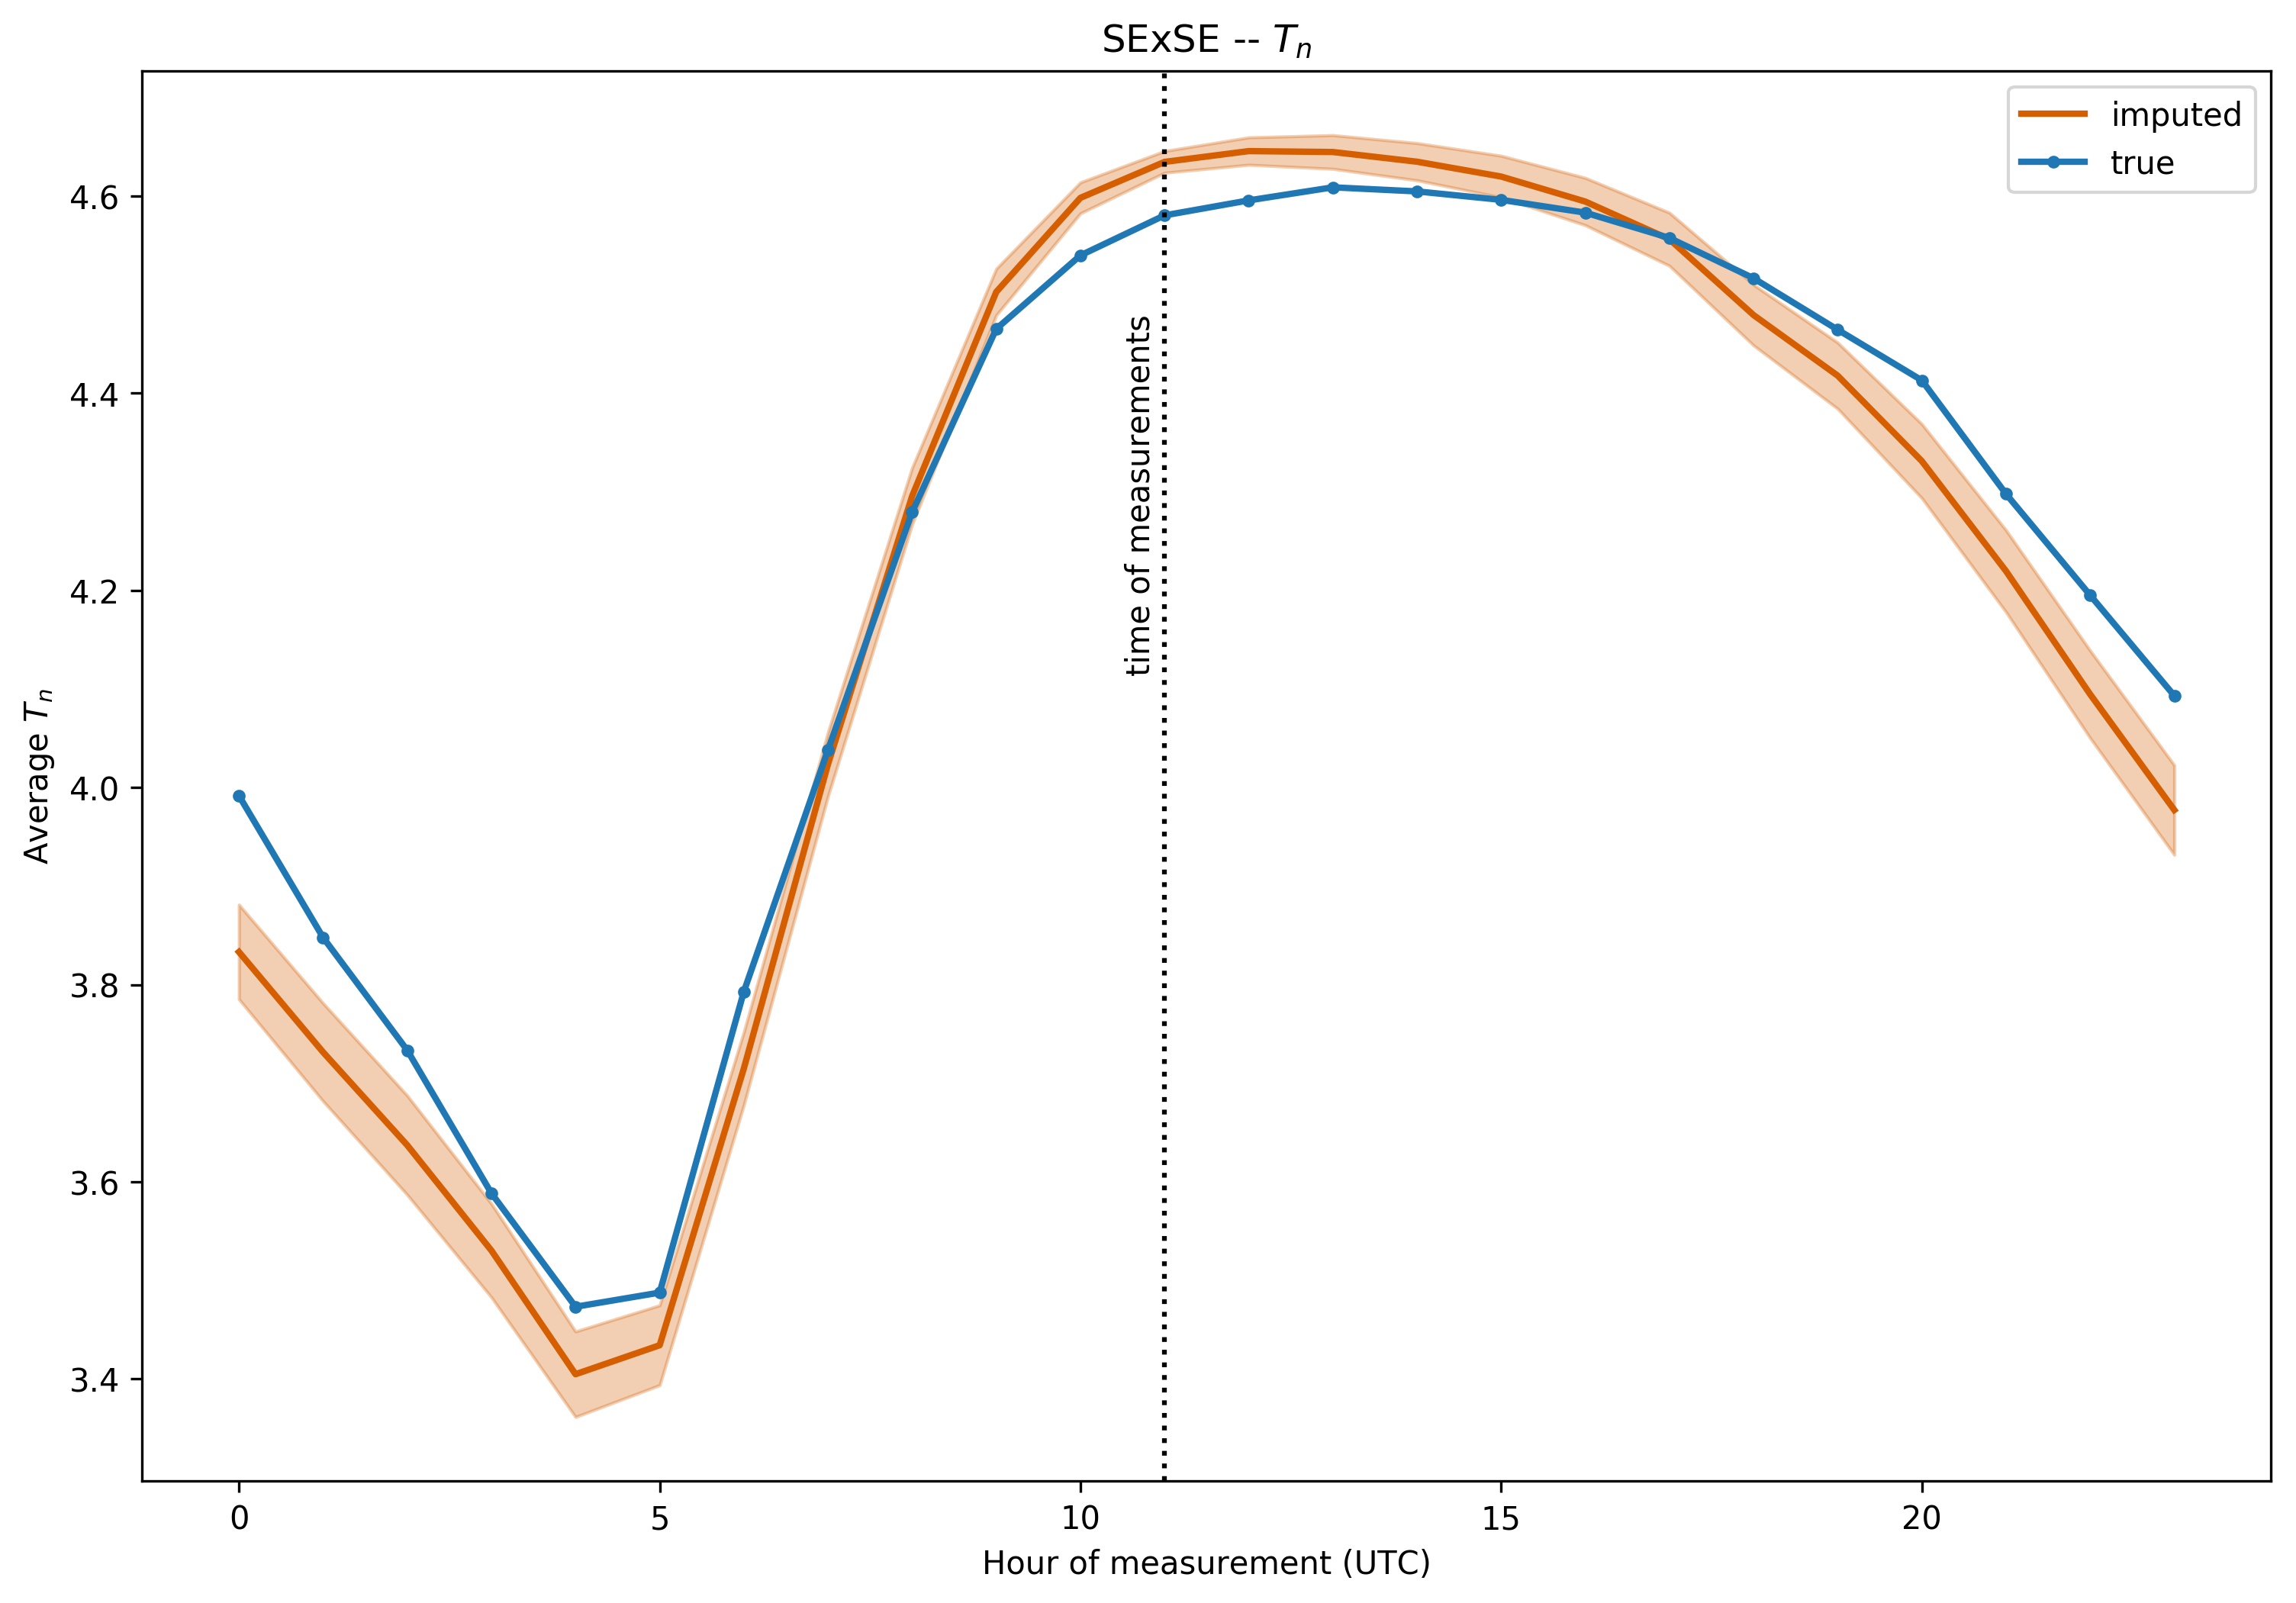

In [105]:
function plot_mean(all_hours_tntx_best, GPmodel::String, tntx::Symbol; hr_shift::Int=-6)
    ilocaltime = circshift(1:24, hr_shift)
    local_time = dt -> dt + Hour(hr_shift)
    cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    y, y_err2, y_varcovar = mean_se(all_hours_tntx_best, GPmodel, tntx, minday, maxday)
    y_err = sqrt.(y_err2)
    y_sqrtvar = sqrt.(y_varcovar)
    plt.plot(0:23, y[ilocaltime], 
             color=cbbPalette[6], 
             linewidth=2, 
             label="imputed")
    # plt.fill_between(0:23,
    #                  y.-2*y_err,
    #                  y.+2*y_err,
    #                  color=cbbPalette[6],
    #                  alpha=0.3
    #                  )
    plt.fill_between(0:23,
                     (y.-2*y_sqrtvar)[ilocaltime],
                     (y.+2*y_sqrtvar)[ilocaltime],
                     color=cbbPalette[6],
                     alpha=0.3
                     )
    y_true = plot_true_TnTx(tntx, mean, minday, maxday; hr_shift=hr_shift)

    plt.xlabel("Hour of measurement (UT-6)")
    hr_measure = Hour(17)
    local_measurement_time = Dates.value(local_time(hr_measure))
    plt.axvline(x=local_measurement_time, color="black", linestyle=":")
    y_imput = y[Dates.value(hr_measure)+1]
    y_true = get_true_TnTx(tntx, mean, hr_measure, minday, maxday)
    y_low = min(y_imput, y_true)
    y_high = max(y_imput, y_true)
    ylim1, ylim2 = plt.ylim()
    if y_low - ylim1 > ylim2 - y_high
        # more room underneath line
        align = "top"
        y_label = y_low - 0.1
    else
        align = "bottom"
        y_label = y_high + 0.1
    end
    plt.text(
            x=local_measurement_time-0.1, 
            y=y_label, 
            horizontalalignment="right", # text on the left of the line
            verticalalignment=align, 
            s="time of measurements", 
            rotation=90,
            )
    plt.legend(loc="best")
end
plot_mean(all_hours_tntx_best, "SExSE", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"SExSE -- $T_n$")
;

In [41]:
plot_mean(all_hours_tntx_best, "sumprod", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"Sum of products v1 -- $T_n$")

LoadError: [91mKeyError: key "sumprod" not found[39m

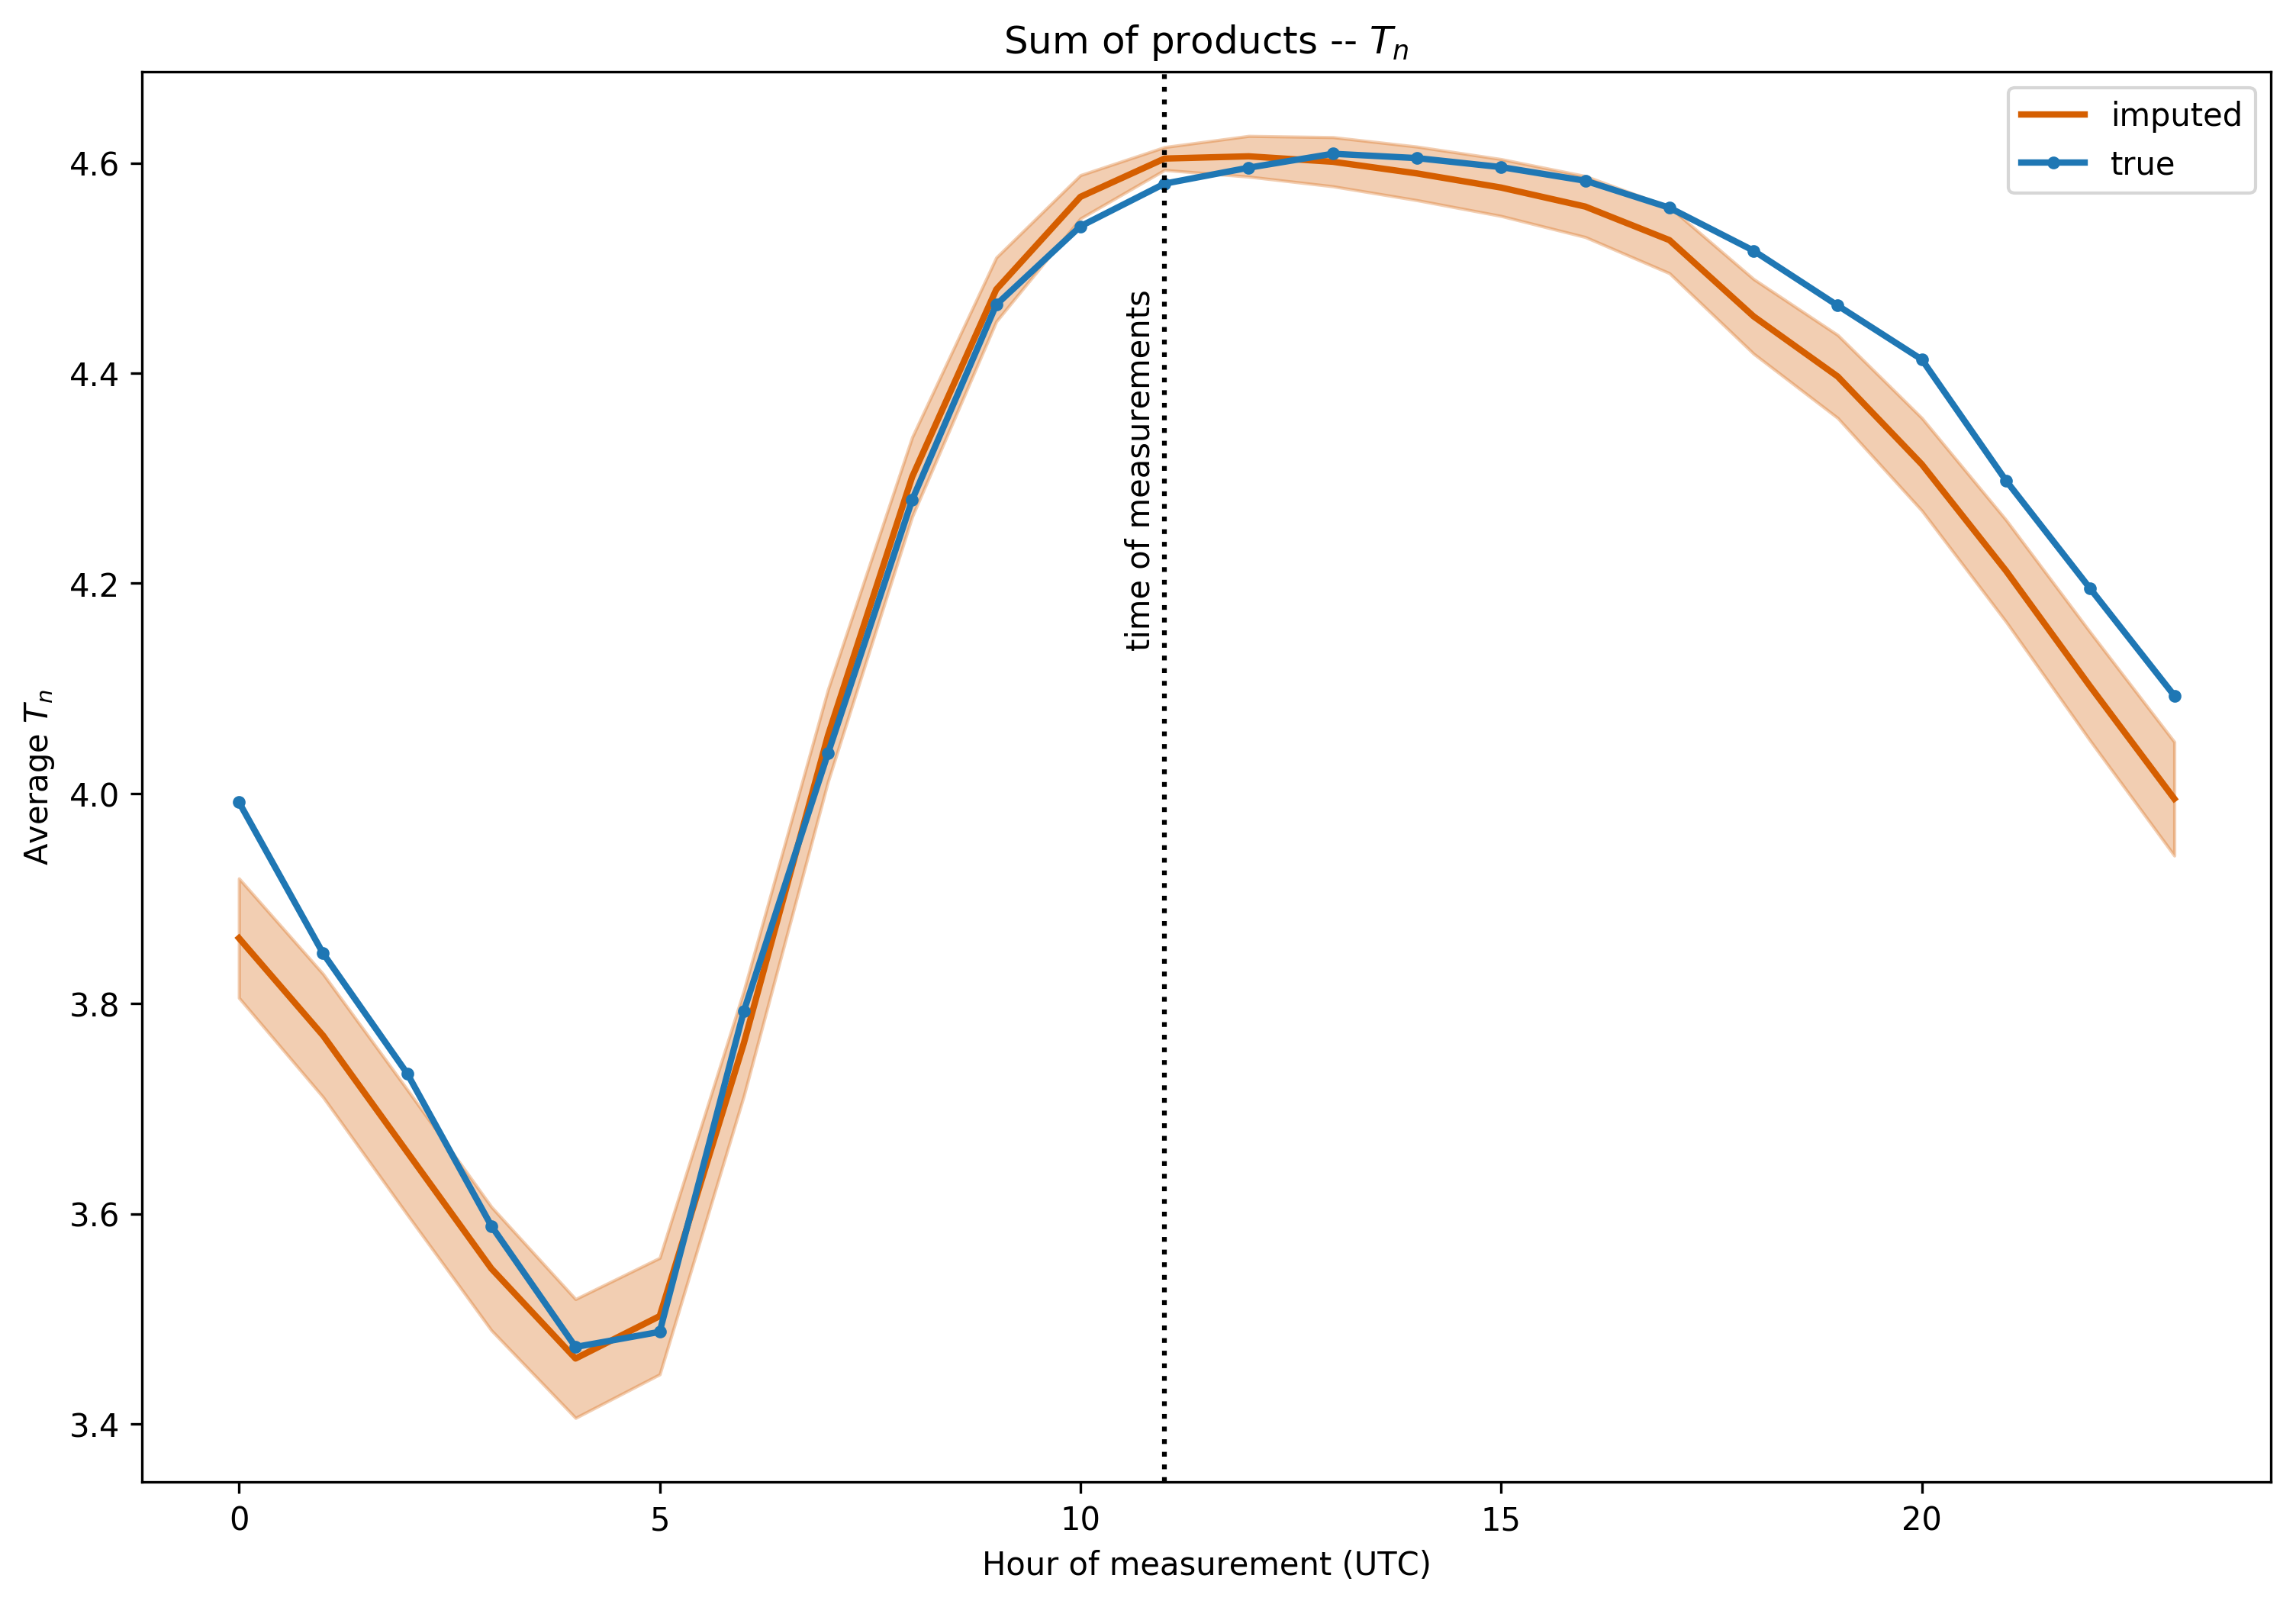

In [106]:
plot_mean(all_hours_tntx_best, "simpler", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"Sum of products -- $T_n$")
;

### T_x

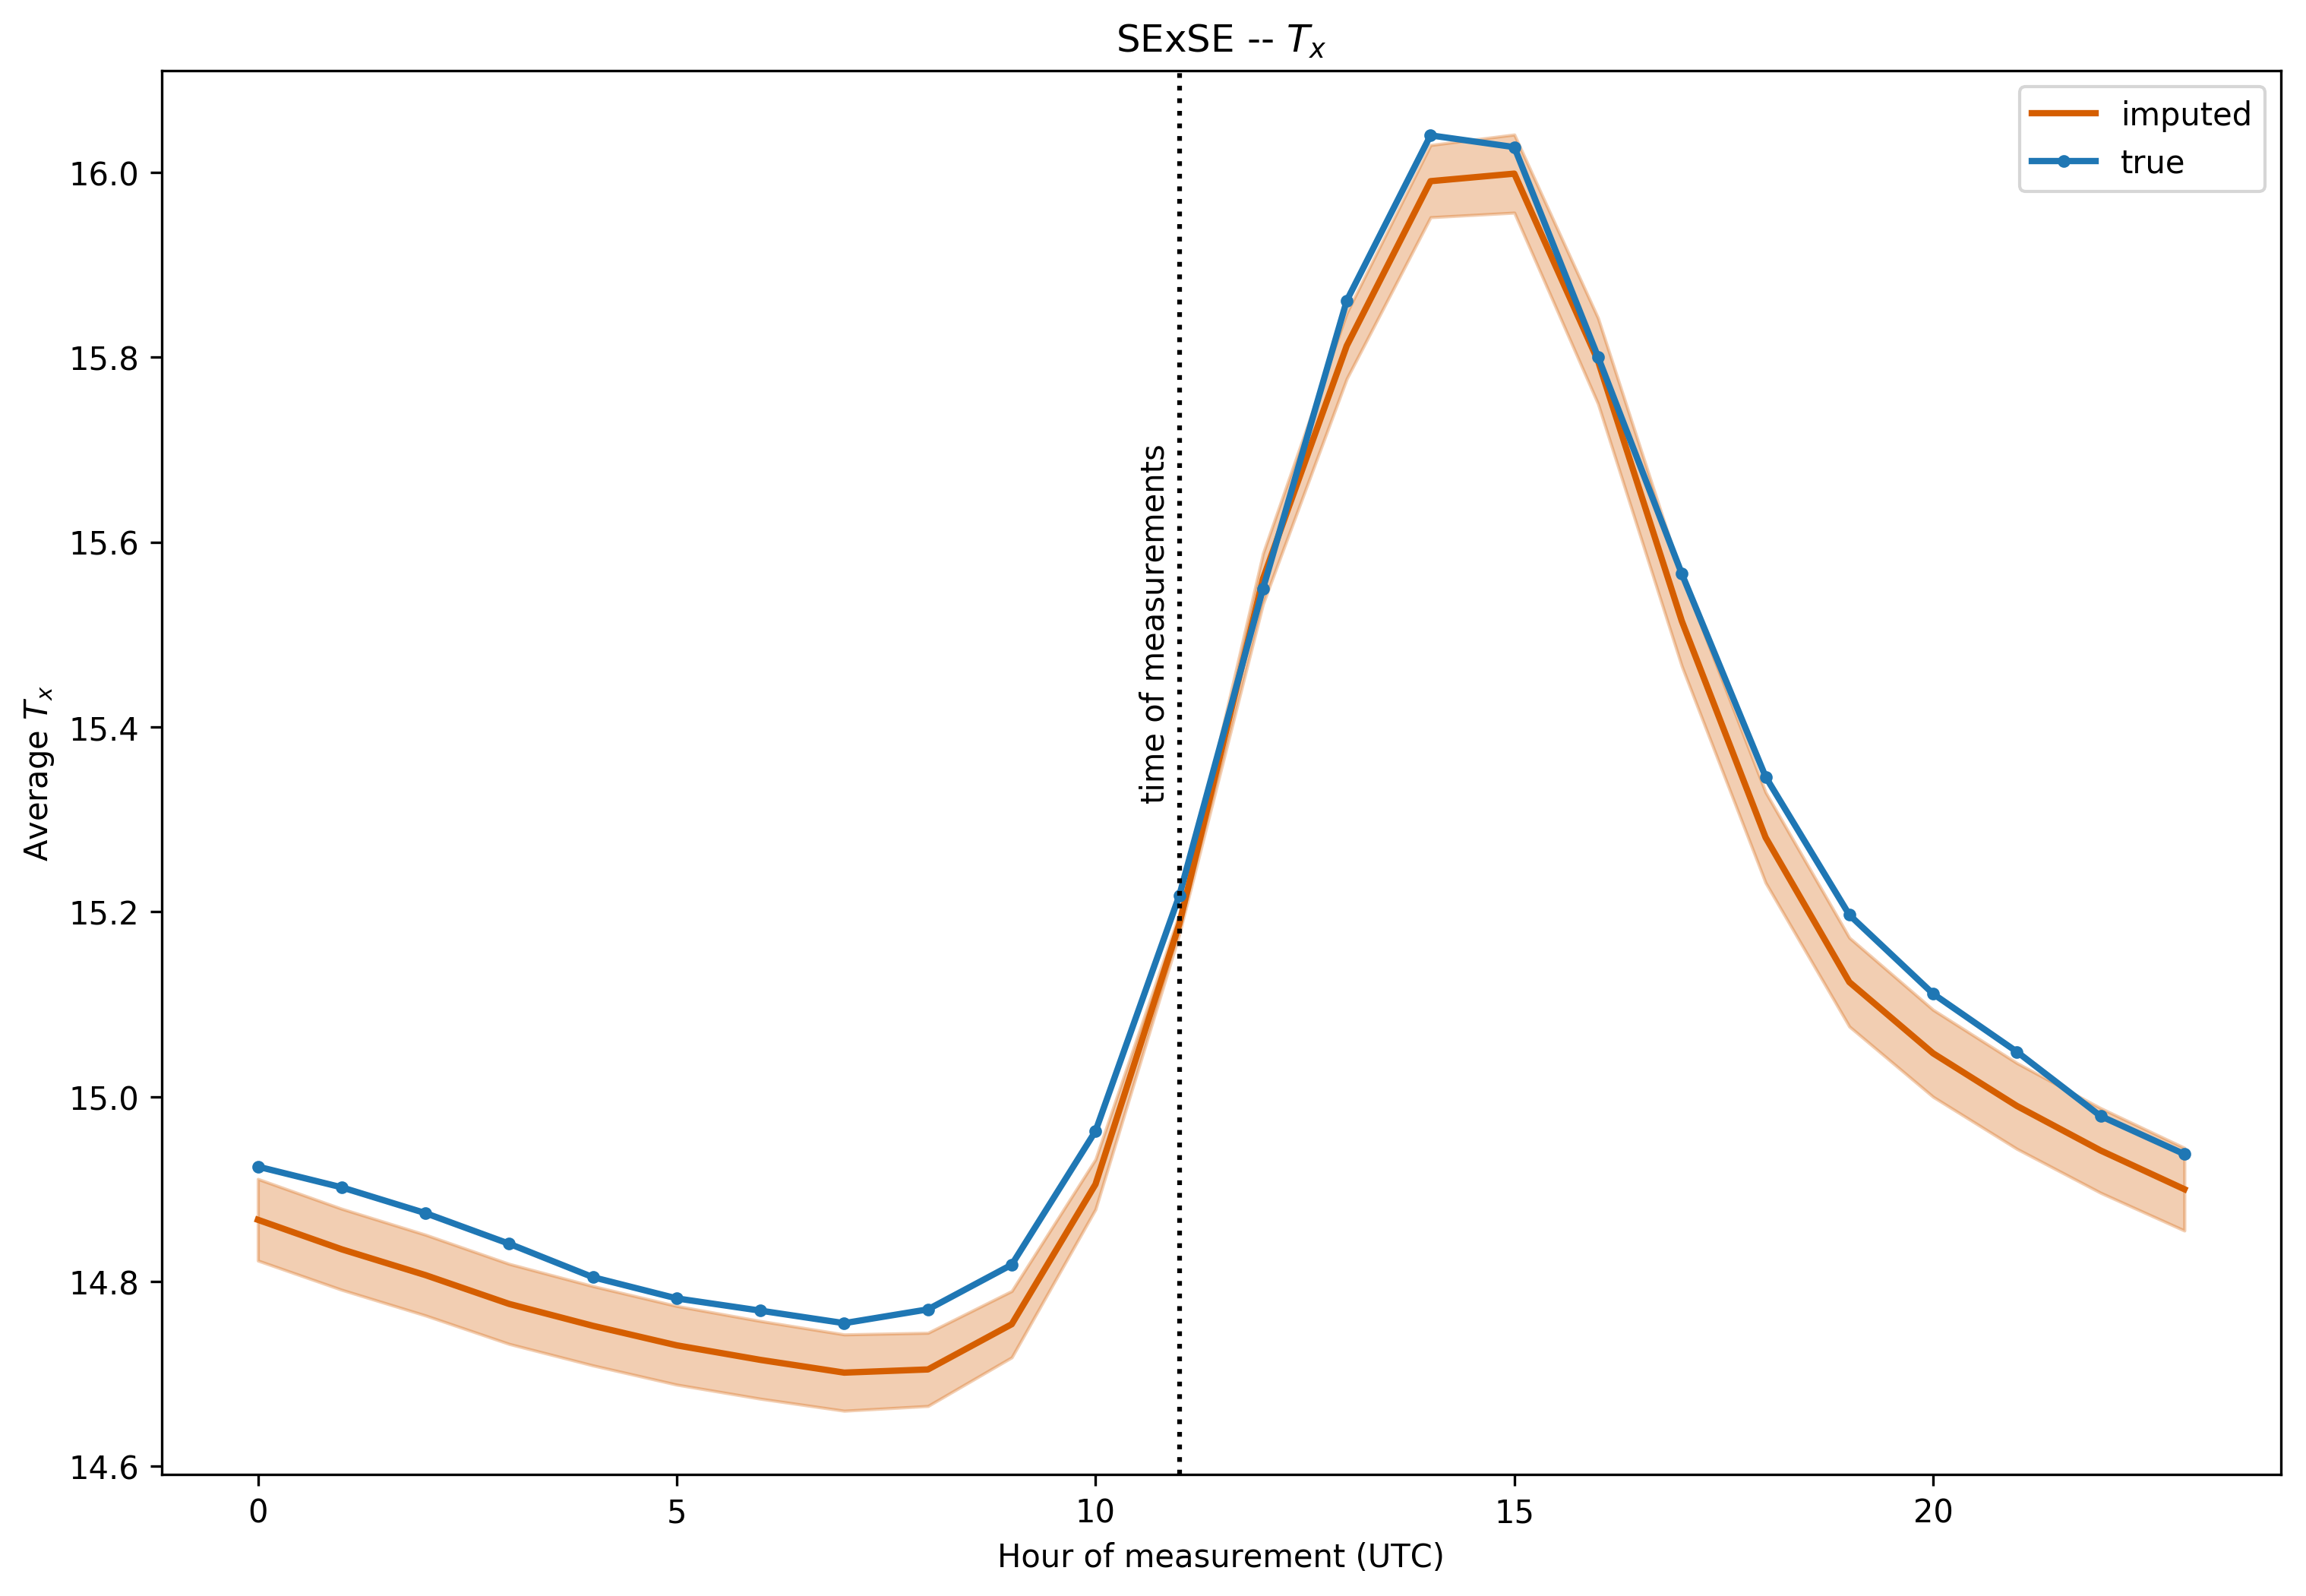

PyObject <matplotlib.text.Text object at 0x135478860>

In [107]:
plot_mean(all_hours_tntx_best, "SExSE", :Tx)
plt.ylabel(L"Average $T_x$")
plt.title(L"SExSE -- $T_x$")

In [53]:
GPmodel = "simpler"
m,se = mean_se(all_hours_tntx_best, GPmodel, :Tx, minday, maxday)


([15.2199, 15.0815, 15.0195, 14.972, 14.9283, 14.8956, 14.8605, 14.83, 14.8065, 14.7772  …  14.7146, 14.7647, 14.8979, 15.1477, 15.5039, 15.731, 15.8855, 15.8903, 15.7255, 15.4836], [0.000324593, 0.000407247, 0.000523017, 0.000635331, 0.000732738, 0.000815157, 0.000915768, 0.000973503, 0.000998091, 0.0009843  …  0.000361568, 0.000232852, 0.000106956, 2.95258e-5, 9.36501e-5, 0.000136421, 0.000161866, 0.000182535, 0.000209814, 0.000247137], [0.000324316, 0.000396071, 0.000489999, 0.000588926, 0.000668385, 0.000731372, 0.000805027, 0.000856248, 0.000880909, 0.000859549  …  0.00035561, 0.000230403, 0.000105872, 2.95576e-5, 9.34202e-5, 0.000136034, 0.000161665, 0.000182072, 0.000209683, 0.000247417])

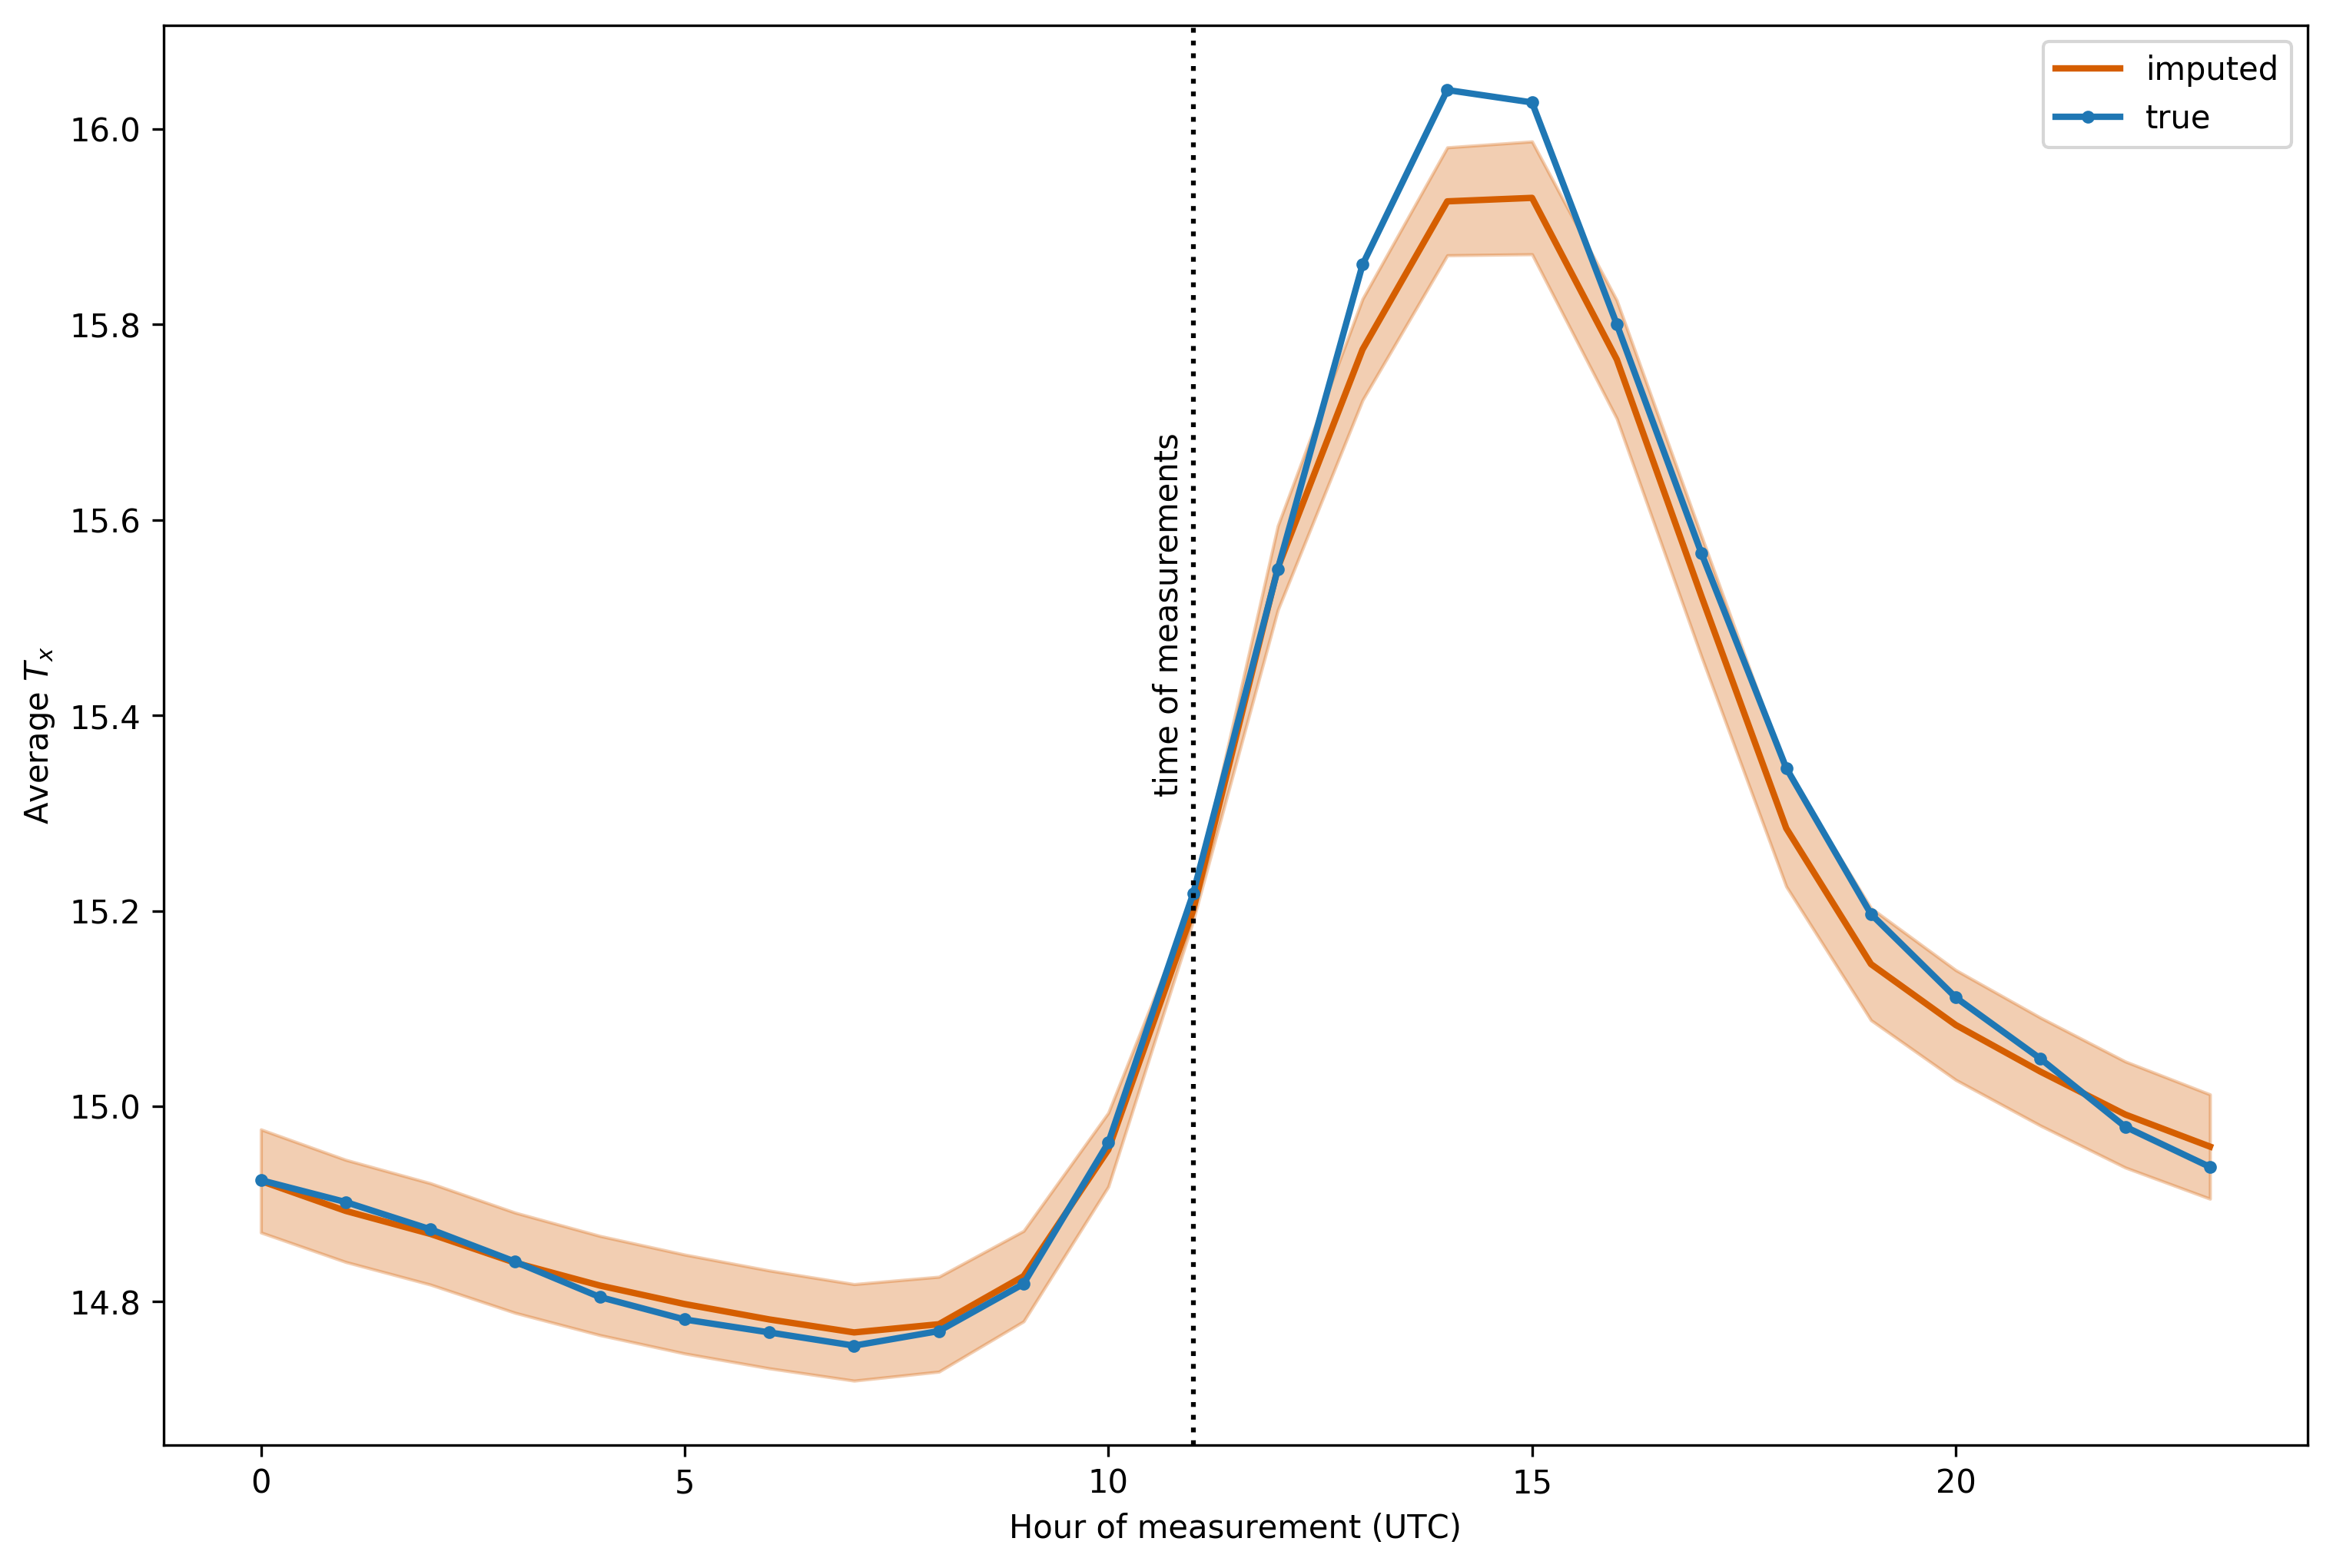

In [108]:
GPmodel = "simpler"
# plt.title(L"Sum of products -- $T_x$")
# measured = get_true_TnTx(:Tx, mean, minday, maxday)
plot_mean(all_hours_tntx_best, "simpler", :Tx)
plt.ylabel(L"Average $T_x$")
plt.savefig(data_dir*"figures/imputed_summary_stats.png", bbox_inches="tight")
plt.savefig(data_dir*"figures/imputed_summary_stats.pdf", bbox_inches="tight")

## 2x2 plot

In [ ]:
function yaxis_right()
    ax = plt.gca()
    ax[:yaxis][:tick_right]()
    ax[:yaxis][:set_label_position]("right")
end
function title_in_axis(s)
    plt.text(0.05, 0.95,s,
         horizontalalignment="left",
         verticalalignment="top",
         transform = plt.gca()[:transAxes])
end

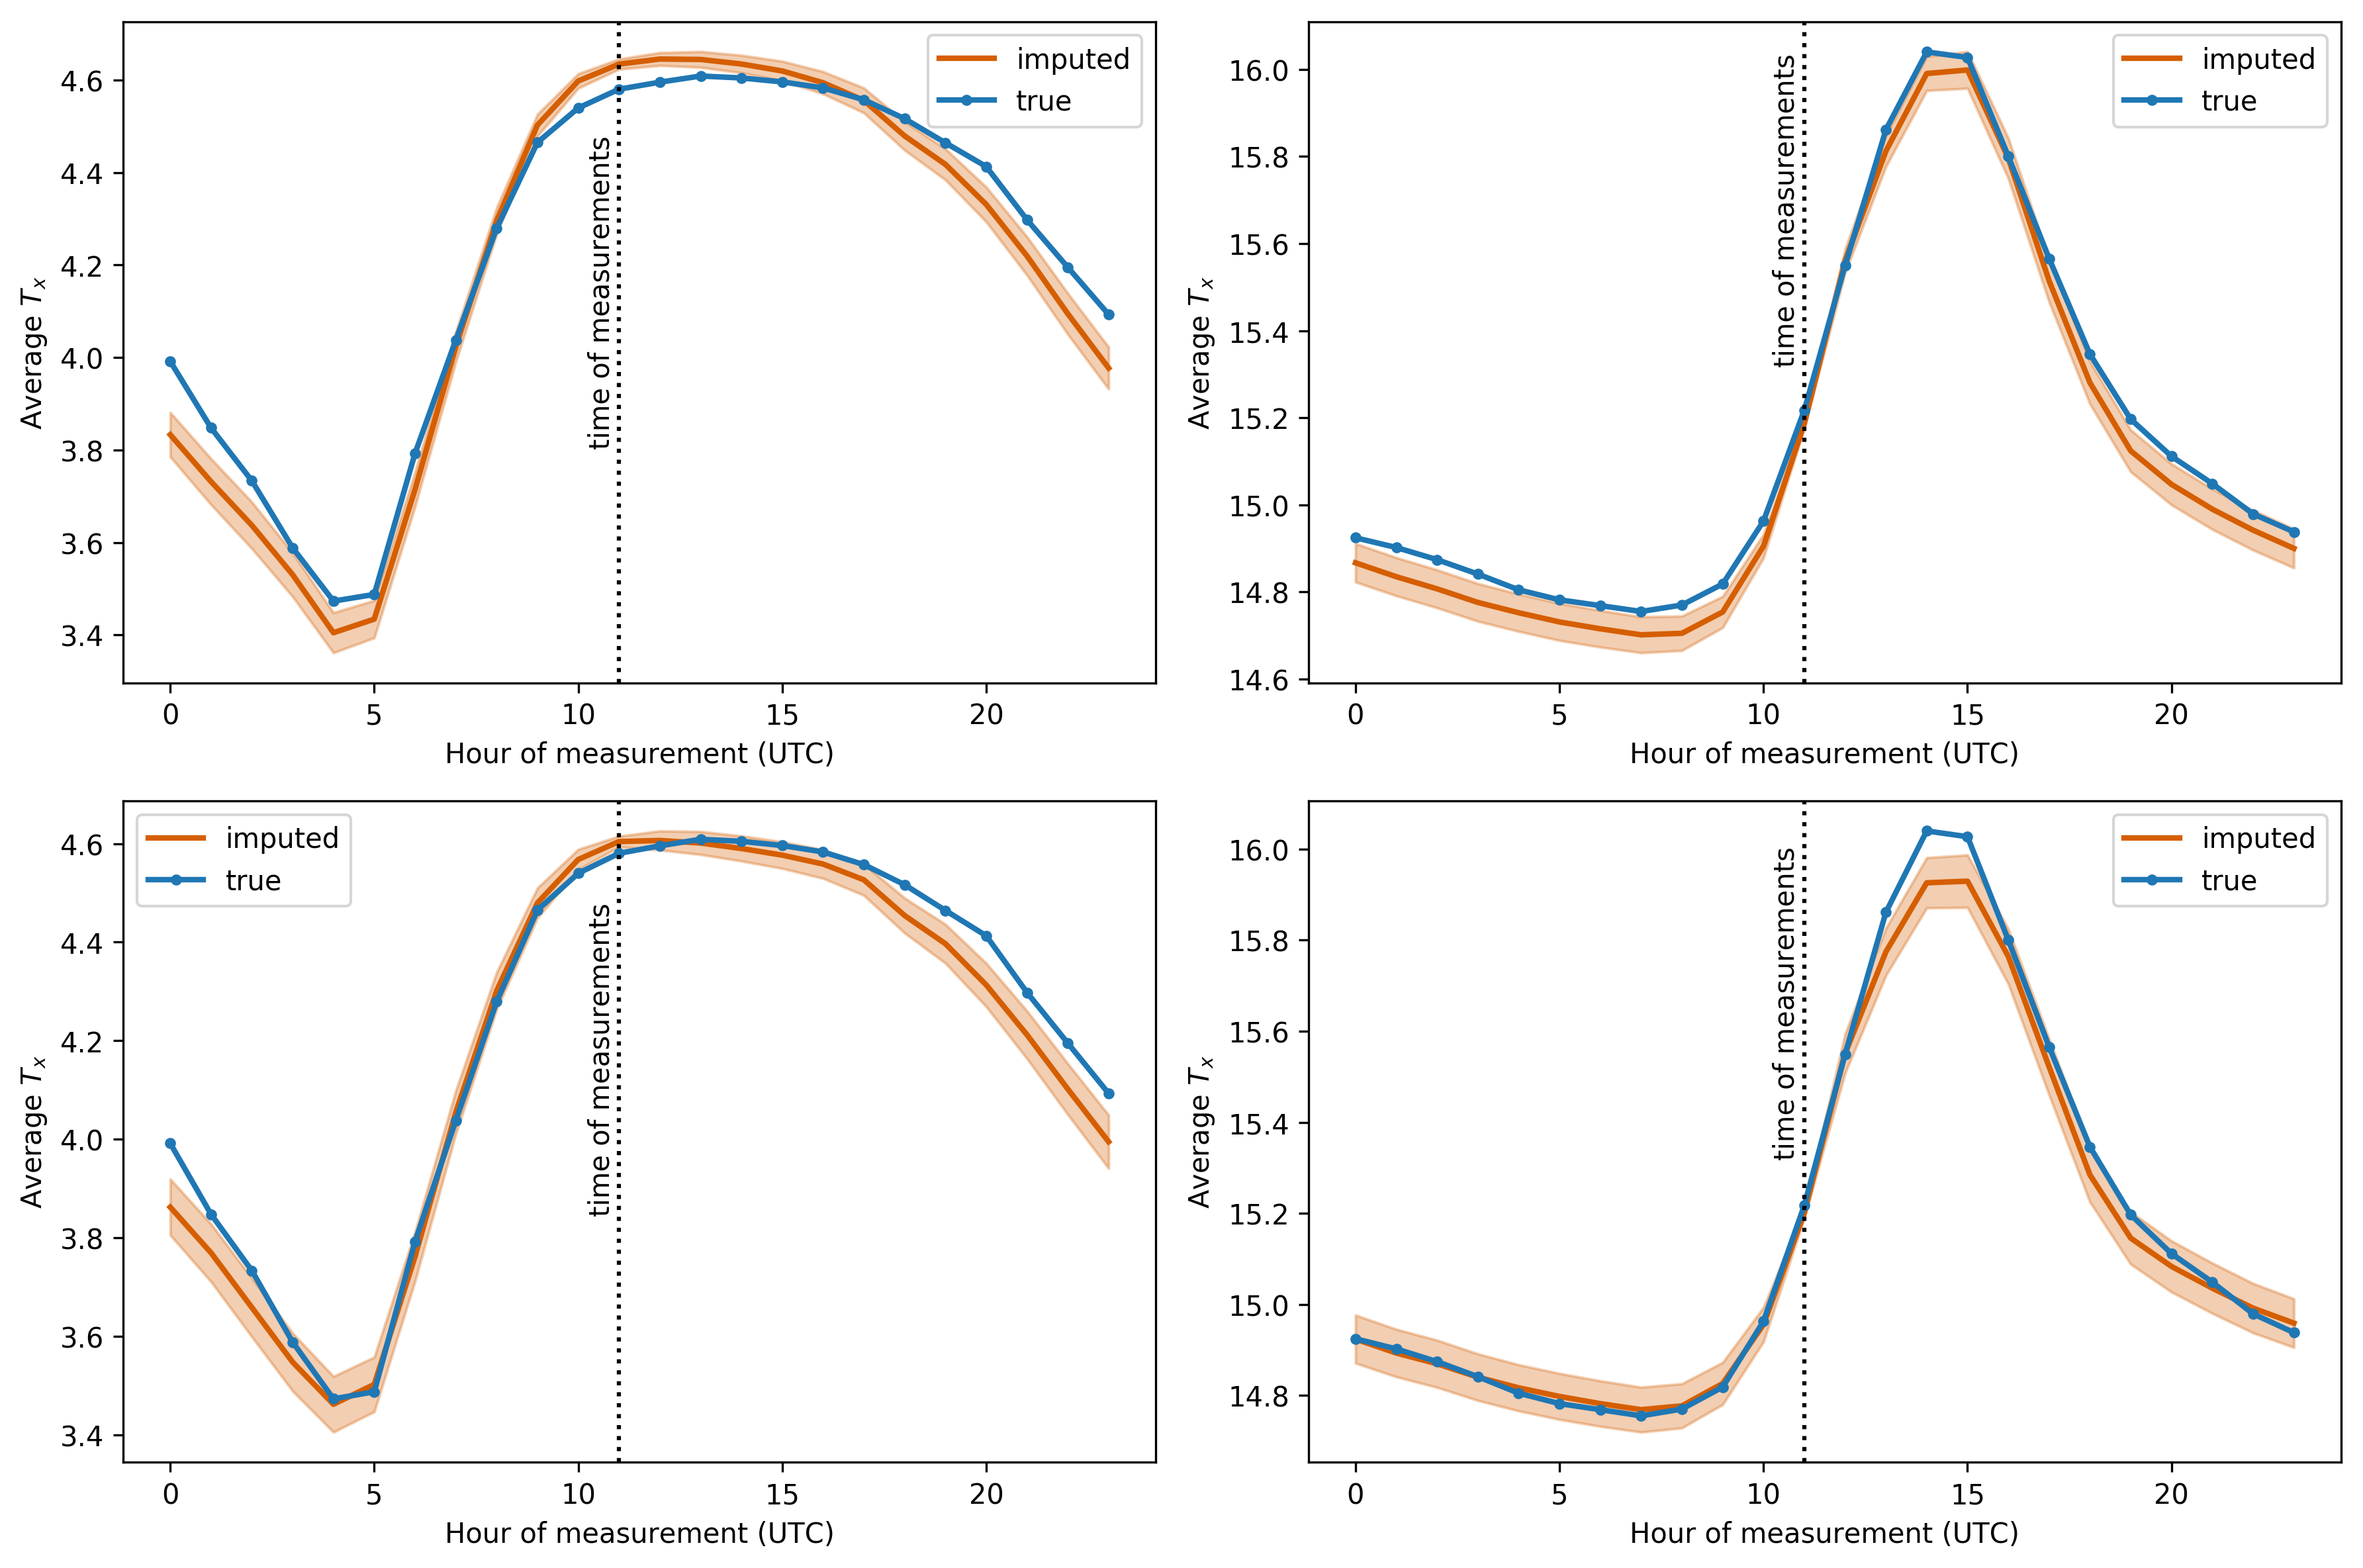

In [111]:
plt.subplot(2,2,1)

GPmodel = "SExSE"
plot_mean(all_hours_tntx_best, GPmodel, :Tn)
plt.ylabel(L"Average $T_n$")
title_in_axis("(a)")

plt.subplot(2,2,2)

GPmodel = "SExSE"
plot_mean(all_hours_tntx_best, GPmodel, :Tx)
plt.ylabel(L"Average $T_x$")
title_in_axis("(b)")

plt.subplot(2,2,3)

GPmodel = "simpler"
plot_mean(all_hours_tntx_best, GPmodel, :Tn)
plt.ylabel(L"Average $T_n$")
title_in_axis("(c)")

plt.subplot(2,2,4)

GPmodel = "simpler"
plot_mean(all_hours_tntx_best, GPmodel, :Tx)
plt.ylabel(L"Average $T_x$")
title_in_axis("(d)")

plt.gcf()[:tight_layout]()
plt.savefig(data_dir*"figures/imputed_summary_stats.png", bbox_inches="tight")
plt.savefig(data_dir*"figures/imputed_summary_stats.pdf", bbox_inches="tight")

# Measurement day

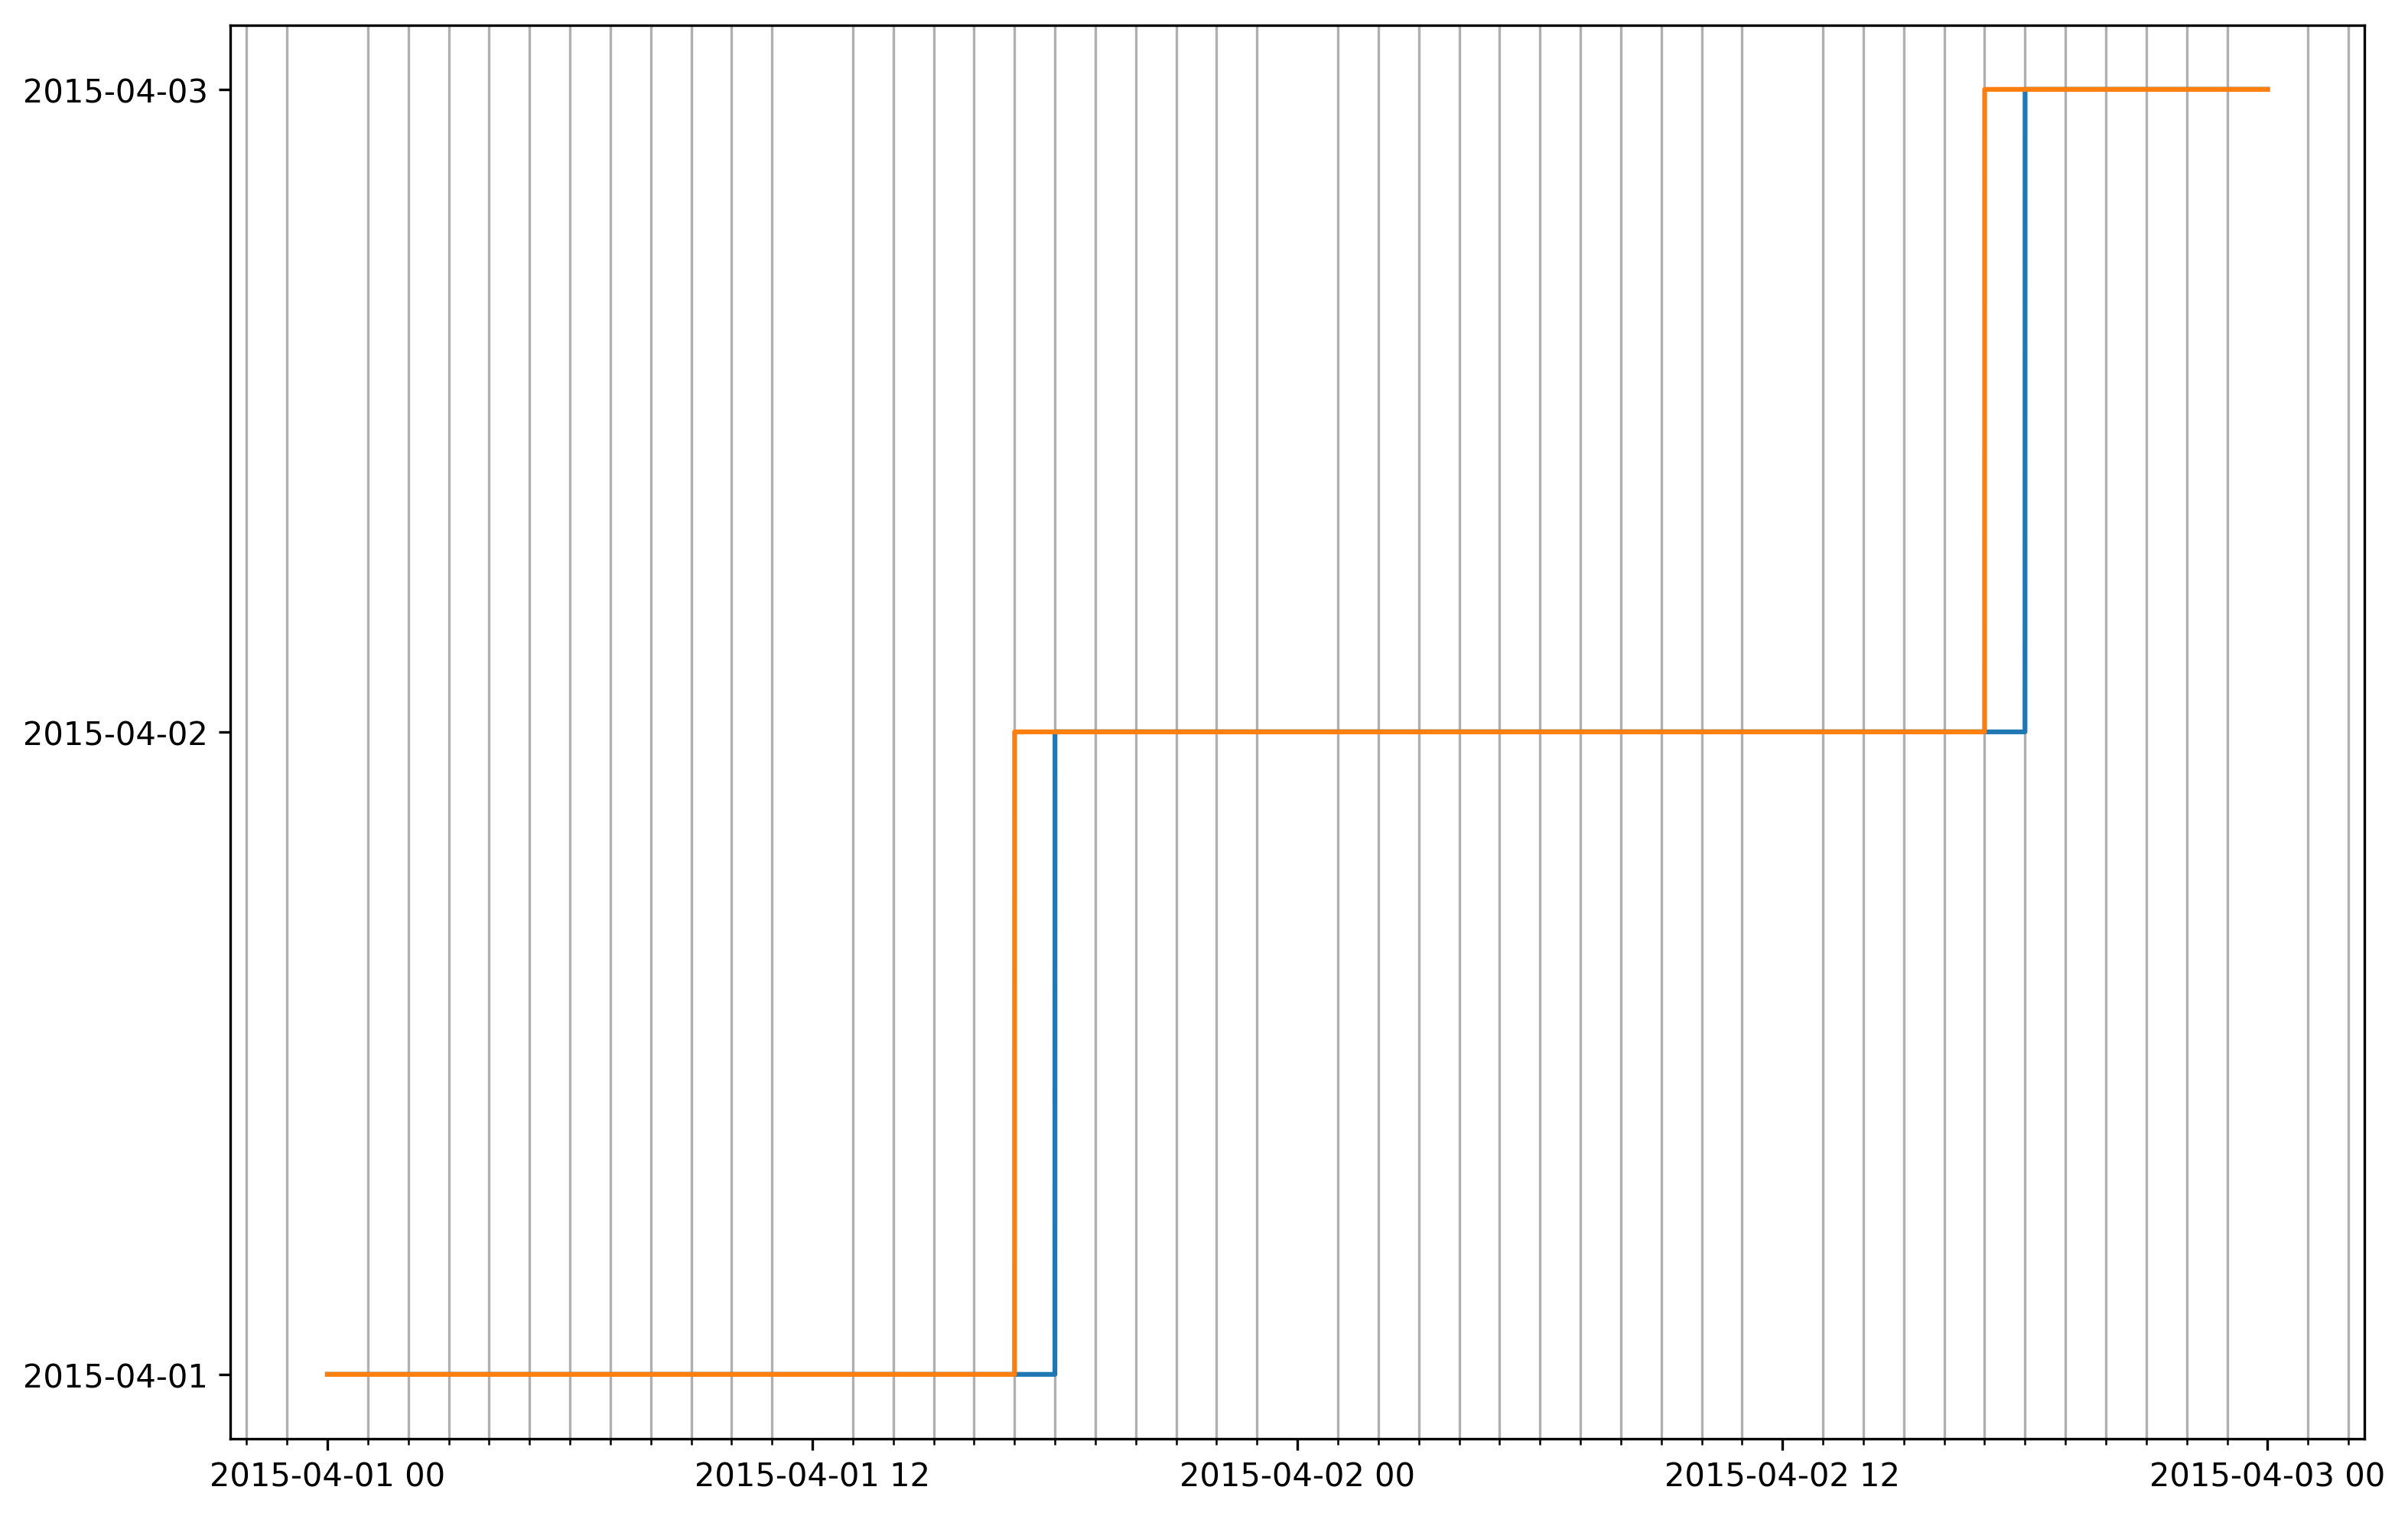

In [81]:
dt = DateTime(2015,4,1,0,0,0):Second(1):DateTime(2015,4,3,0,0,0)
old_day = TempModel.old_measurement_date.(dt, Hour(17))
new_day = TempModel.measurement_date.(dt, Hour(17))
plt.plot(dt, old_day)
plt.plot(dt, new_day)
plt.gca()[:yaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d"))
plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d %H"))
plt.yticks(DateTime(2015,4,1,0,0,0):Day(1):DateTime(2015,4,3,0,0,0))
plt.xticks(DateTime(2015,4,1,0,0,0):Hour(12):DateTime(2015,4,3,0,0,0))

minor_locator = plt.matplotlib[:ticker][:AutoMinorLocator](12)
plt.gca()[:xaxis][:set_minor_locator](minor_locator)
plt.grid(which="minor")

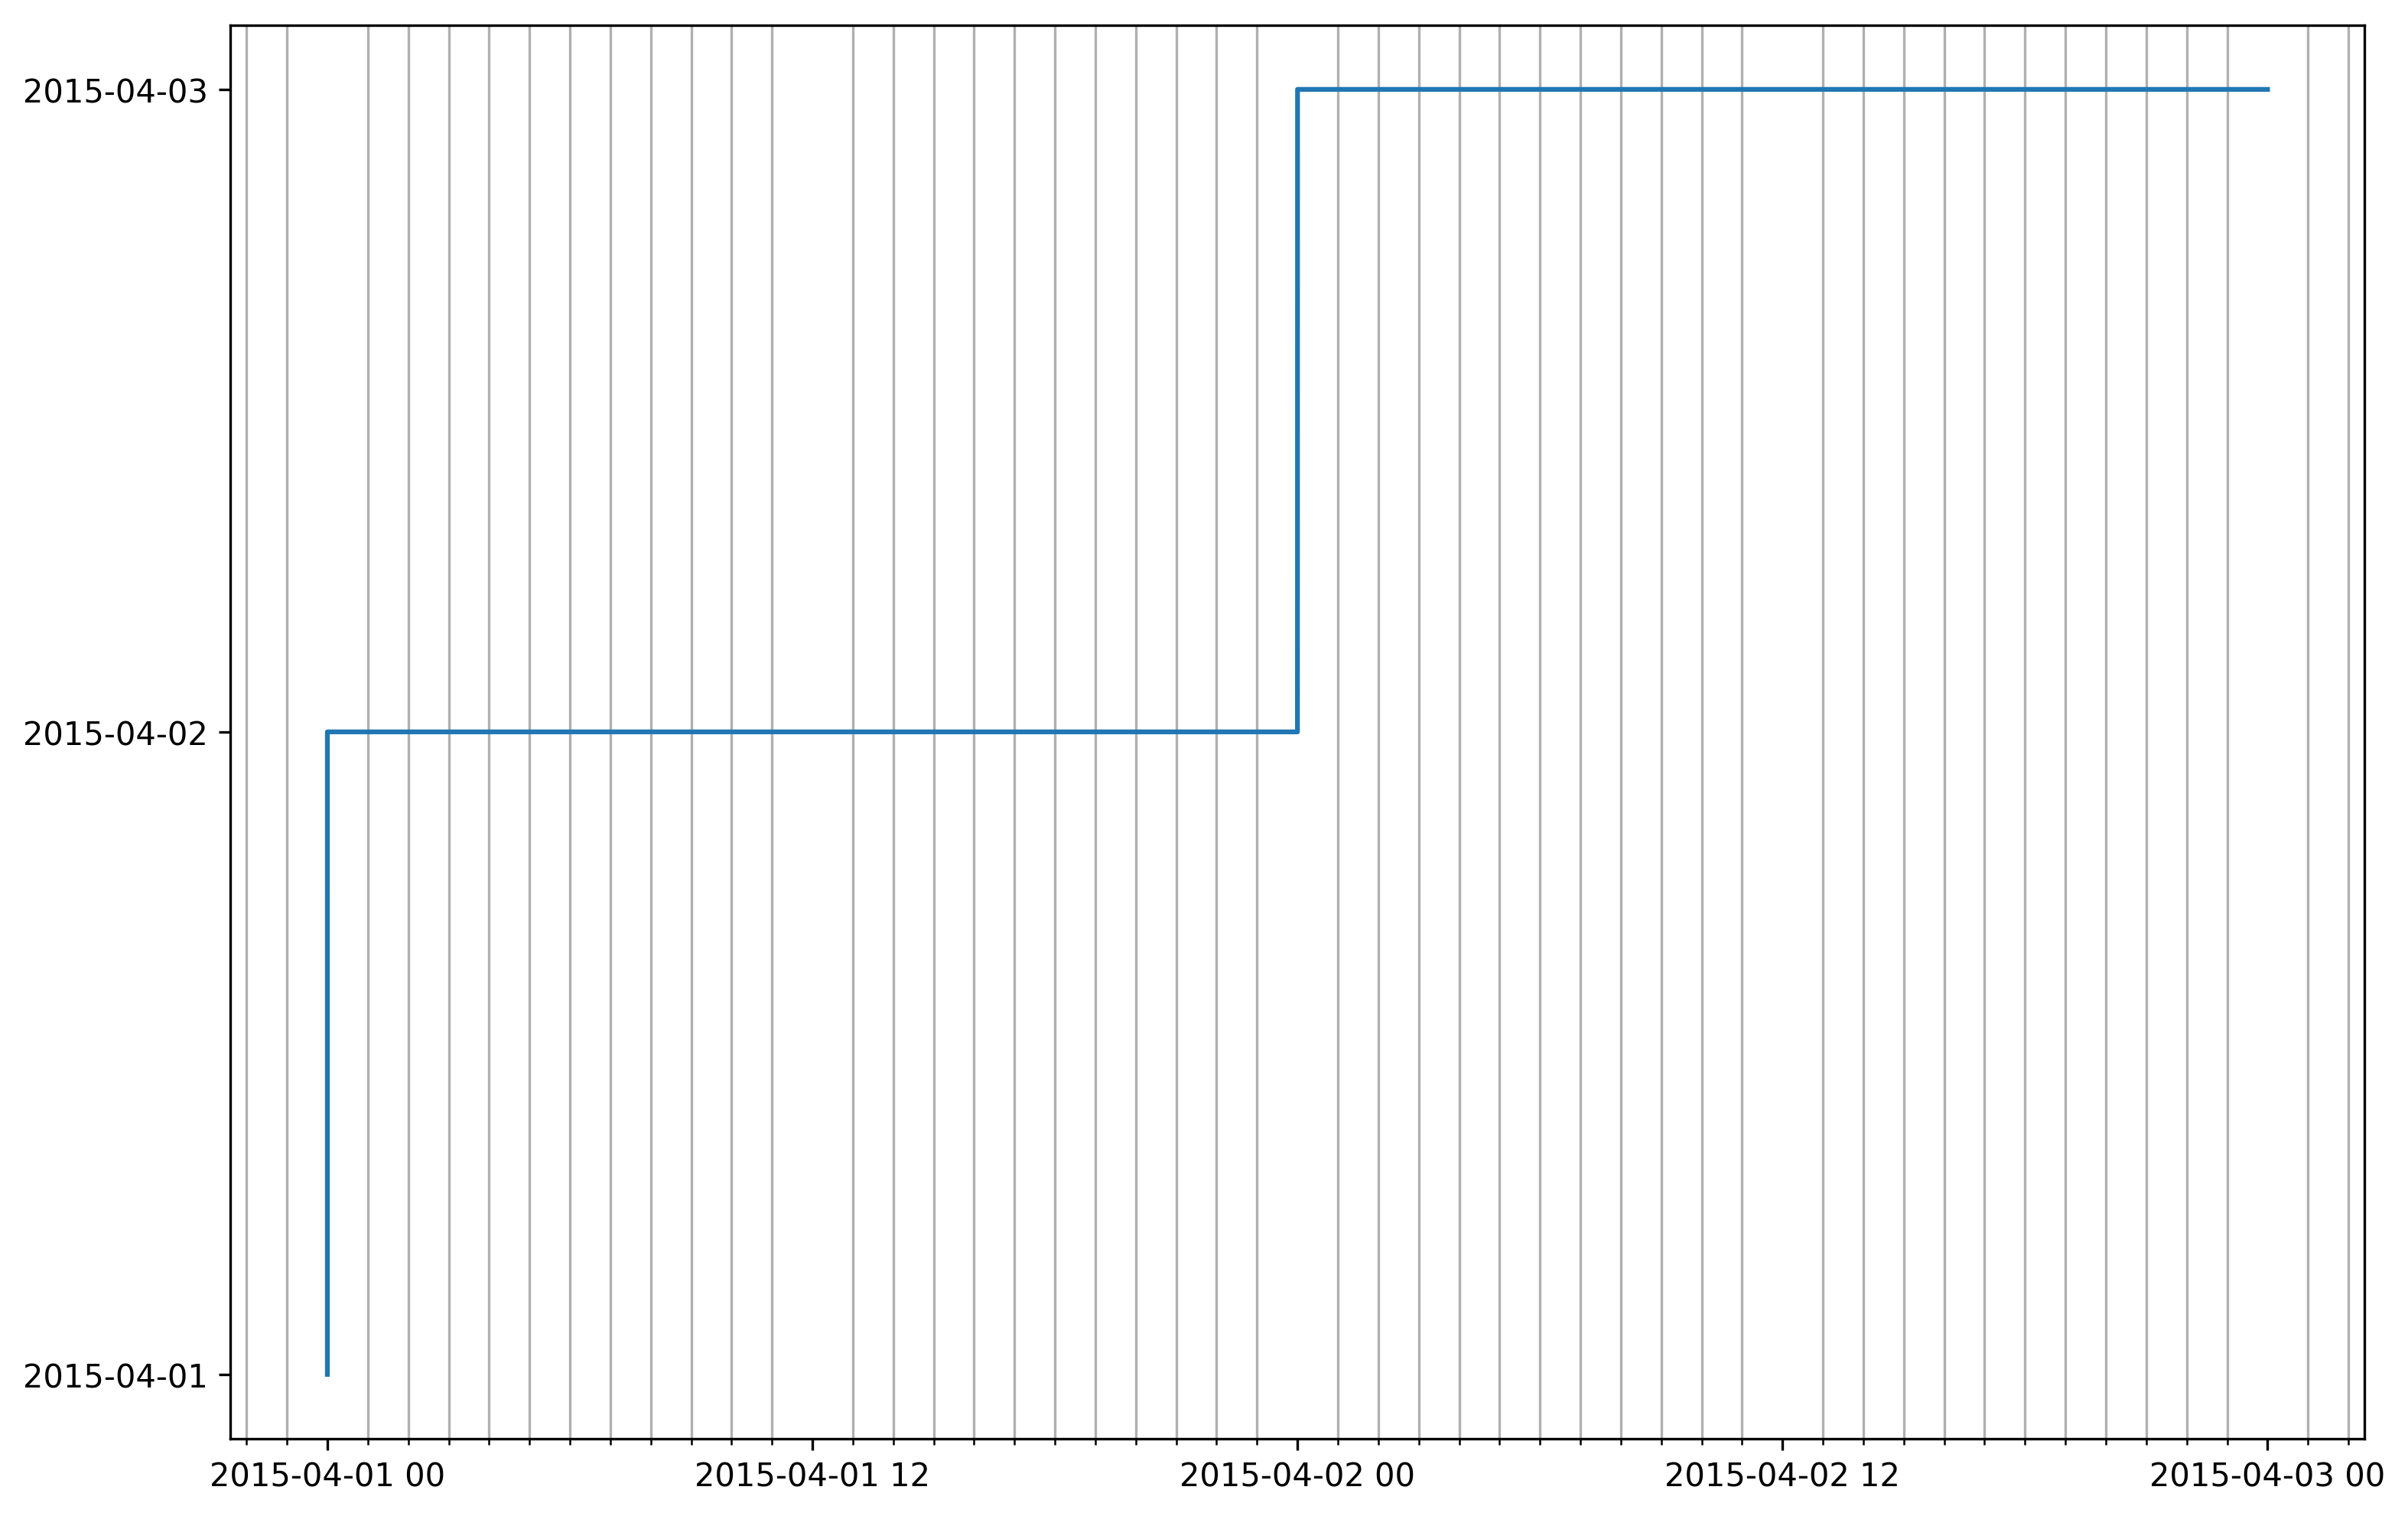

In [48]:
dt = DateTime(2015,4,1,0,0,0):Second(1):DateTime(2015,4,3,0,0,0)
day = TempModel.measurement_date.(dt, Hour(0))
plt.plot(dt, day)
plt.gca()[:yaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d"))
plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d %H"))
plt.yticks(DateTime(2015,4,1,0,0,0):Day(1):DateTime(2015,4,3,0,0,0))
plt.xticks(DateTime(2015,4,1,0,0,0):Hour(12):DateTime(2015,4,3,0,0,0))

minor_locator = plt.matplotlib[:ticker][:AutoMinorLocator](12)
plt.gca()[:xaxis][:set_minor_locator](minor_locator)
plt.grid(which="minor")

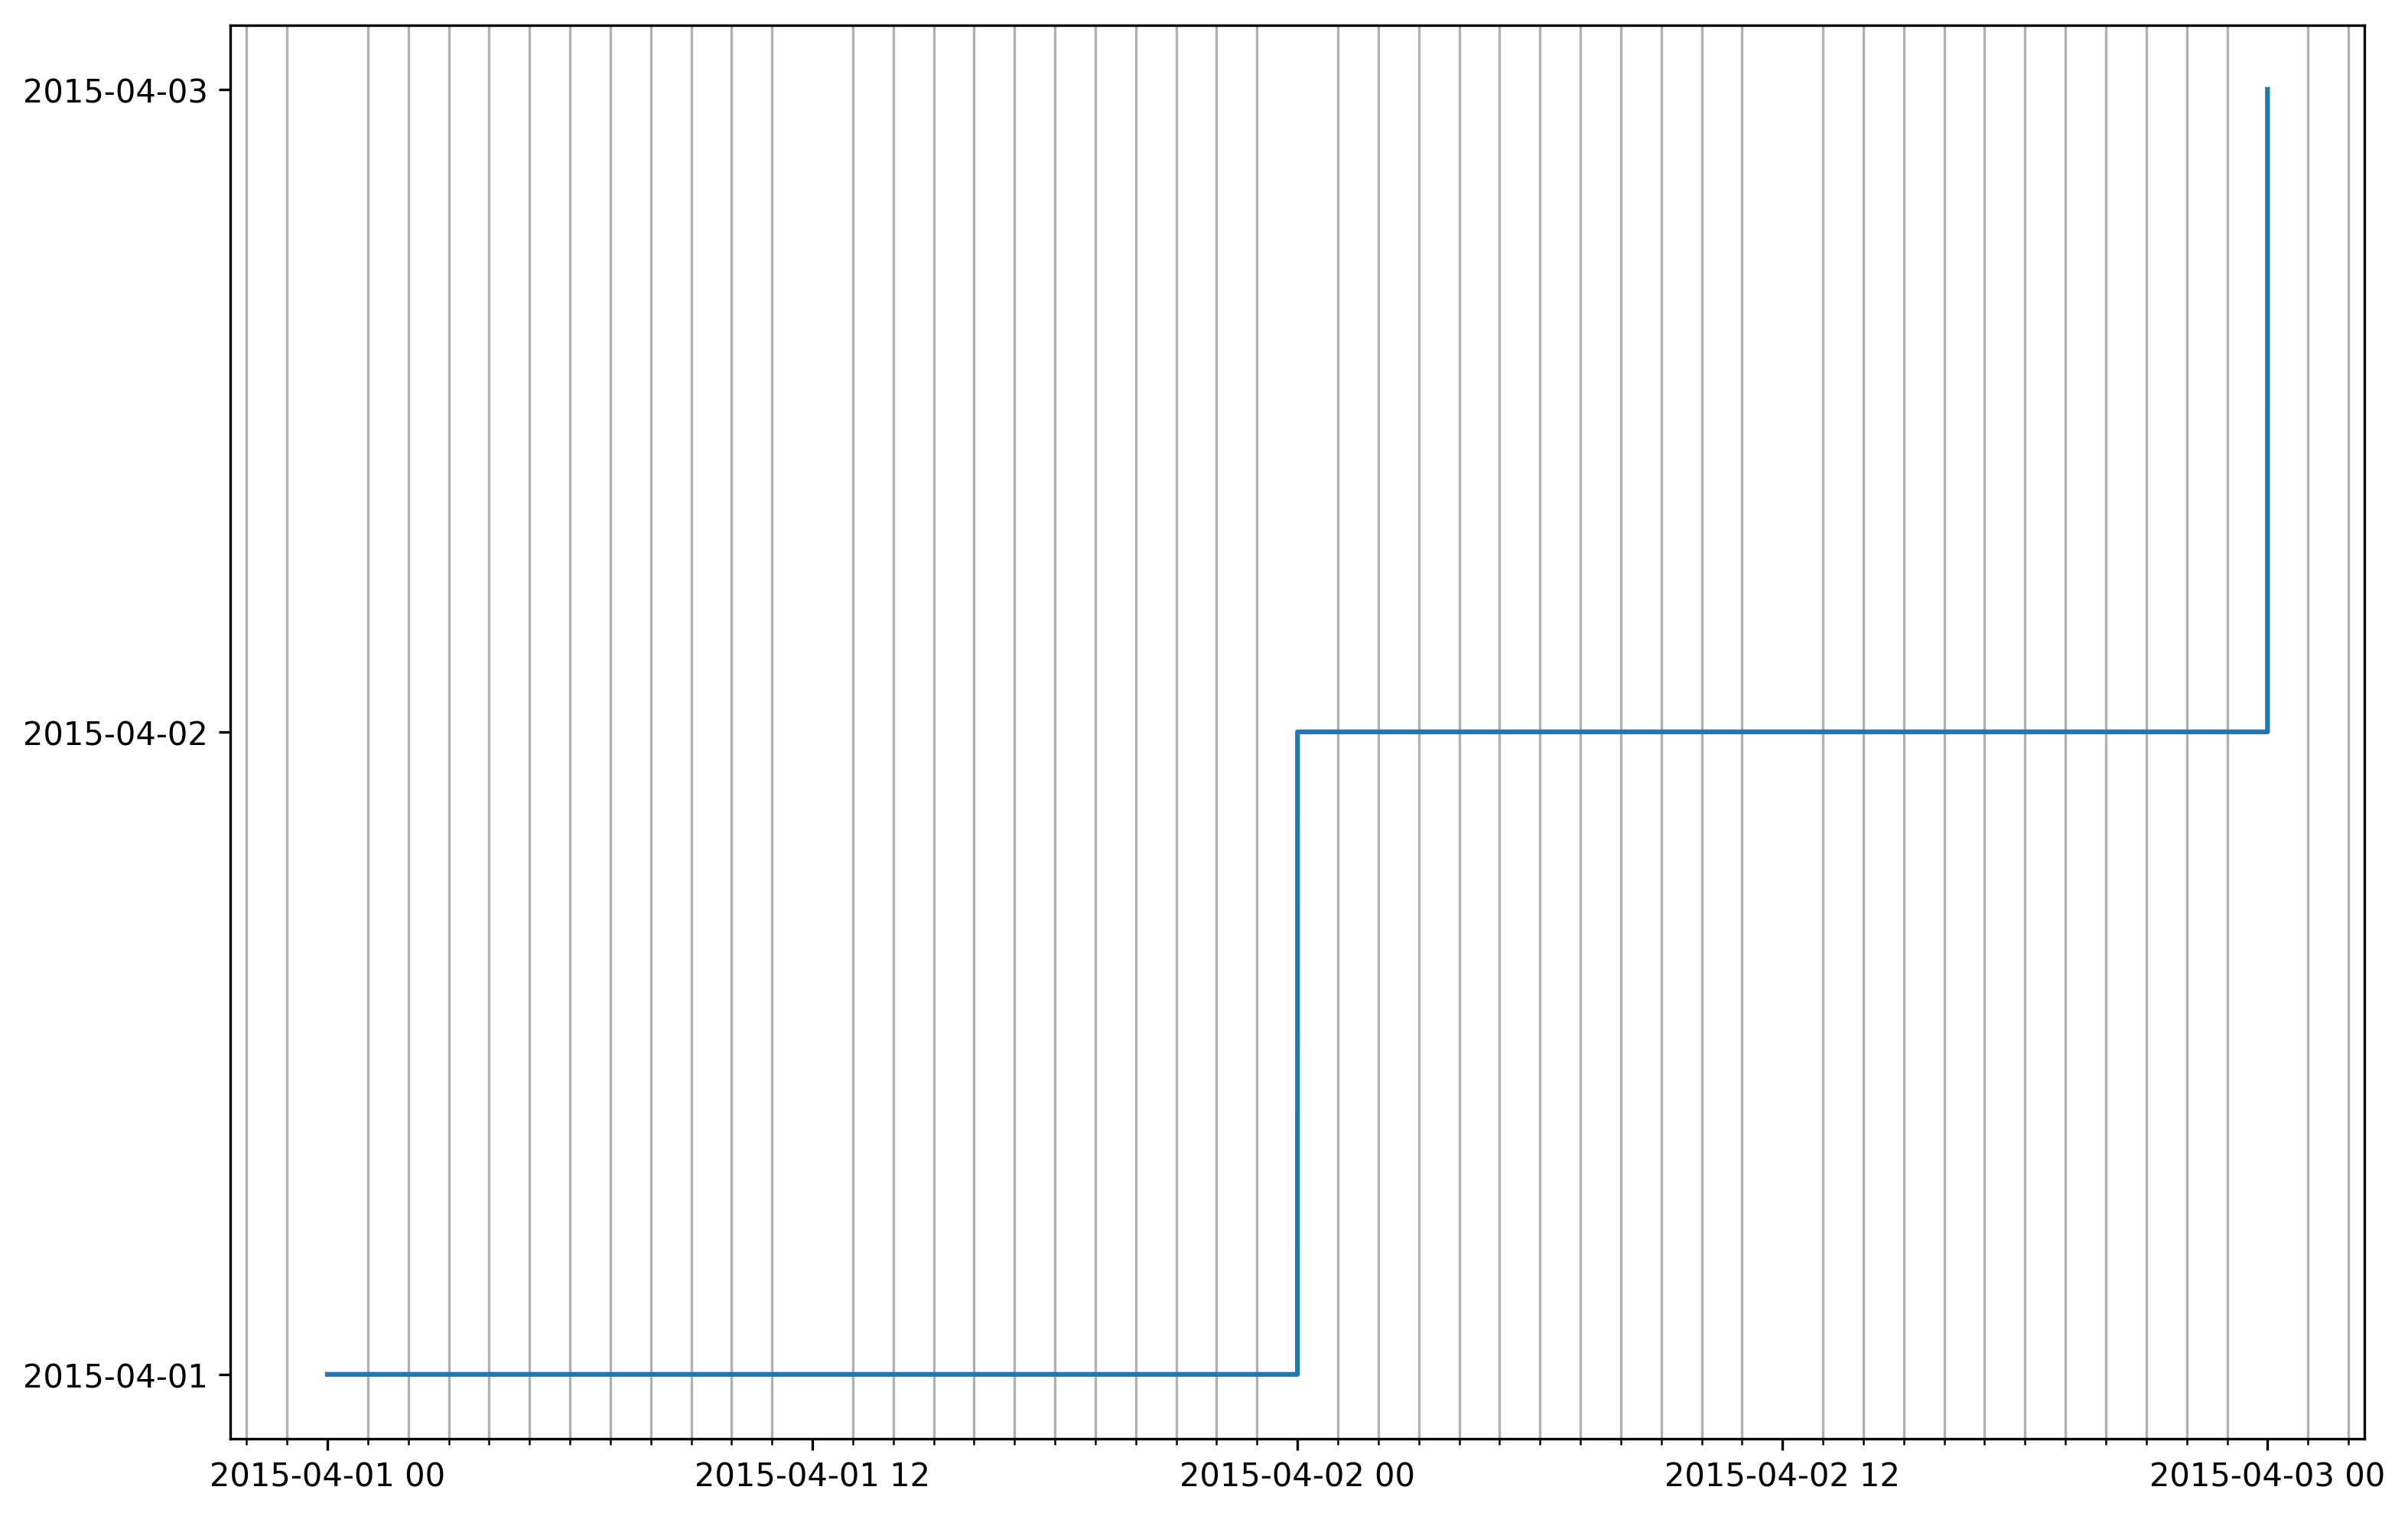

In [49]:
dt = DateTime(2015,4,1,0,0,0):Second(1):DateTime(2015,4,3,0,0,0)
day = TempModel.measurement_date.(dt, Hour(24))
plt.plot(dt, day)
plt.gca()[:yaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d"))
plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%Y-%m-%d %H"))
plt.yticks(DateTime(2015,4,1,0,0,0):Day(1):DateTime(2015,4,3,0,0,0))
plt.xticks(DateTime(2015,4,1,0,0,0):Hour(12):DateTime(2015,4,3,0,0,0))

minor_locator = plt.matplotlib[:ticker][:AutoMinorLocator](12)
plt.gca()[:xaxis][:set_minor_locator](minor_locator)
plt.grid(which="minor")